In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.losses import Huber
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer
import random
import tensorflow as tf
from sklearn.neighbors import KNeighborsRegressor
from haversine import haversine, Unit
from sklearn.impute import KNNImputer
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid

In [2]:
seed = 40  
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
#read the dataset
df = pd.read_csv("df.csv")
df = df.drop(columns = ['geometry', 'Unnamed: 0.1', 'Unnamed: 0',  'magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'place',
       'horizontalError', 'depthError', 'magError', 'magNst','index_right', 'LAYER', 'Code'])
print(f"df columns: {df.columns}")
print("#################")
# Convert the date column to a datetime type
df['time'] = pd.to_datetime(df['time']).dt.date
print(df.head())

df columns: Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'countries',
       'PlateName'],
      dtype='object')
#################
         time  latitude  longitude    depth  mag       countries  \
0  2024-01-31  -22.8316  -177.1381  185.482  5.8           Tonga   
1  2024-01-29   41.1867    78.7155   10.000  5.7           China   
2  2024-01-28   -8.2366   -71.4097  619.551  6.5          Brazil   
3  2024-01-27   14.1128   -90.5191  107.952  6.1       Guatemala   
4  2024-01-25   -1.1559   -13.9734   10.000  5.5  United Kingdom   

       PlateName  
0      Australia  
1        Eurasia  
2  South America  
3  North America  
4  South America  


## Visualizing

Indonesia                   4293
Japan                       3064
United States of America    2849
Russia                      2301
Papua New Guinea            2217
                            ... 
Scarborough Reef               1
Malta                          1
Namibia                        1
Guyana                         1
Slovakia                       1
Name: countries, Length: 152, dtype: int64
                    Country  Count
0                 Indonesia   4293
1                     Japan   3064
2  United States of America   2849
3                    Russia   2301
4          Papua New Guinea   2217
-------------
Total NaN, None, or empty string values in 'countries': 0


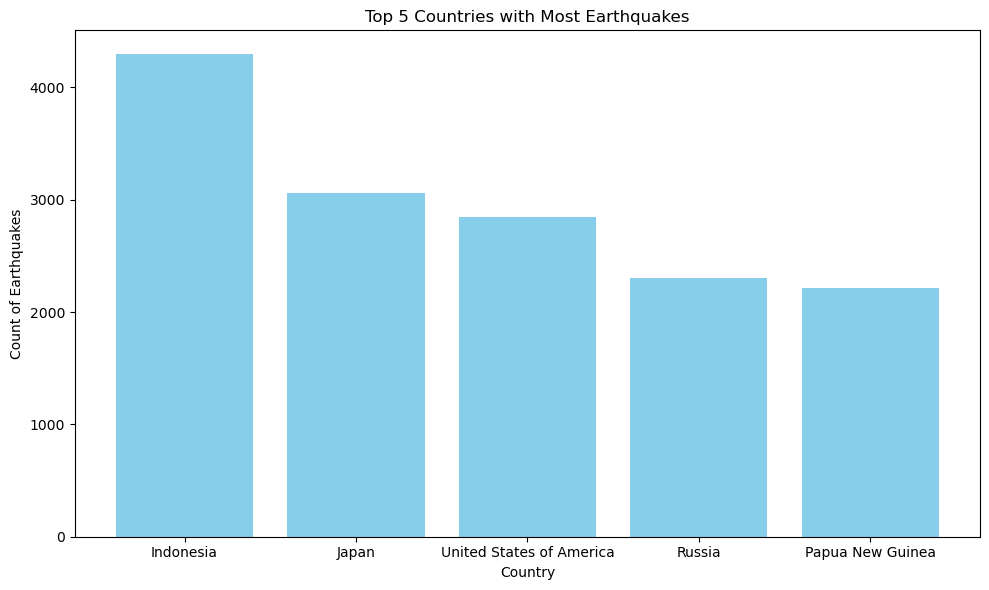

In [4]:
print(df["countries"].value_counts())
country_counts = df['countries'].value_counts()

# Convert the Series into a DataFrame
country_counts_df = country_counts.reset_index()
# Rename the columns to "Country" and "Count"
country_counts_df.columns = ['Country', 'Count']
# Display the resulting DataFrame
print(country_counts_df.head())

print("-------------")
# Count NaN, None, and empty string values in the 'countries' column
na_or_empty = df['countries'].isna() | (df['countries'] == '') | (df['countries'].isnull())
# Print the total count of NaN, None, and empty string values
print("Total NaN, None, or empty string values in 'countries':", na_or_empty.sum())

# Plotting the number of earthquakes by country
# Selecting the top 5 countries with the most earthquakes
top_5_countries = country_counts_df.head(5)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_5_countries['Country'], top_5_countries['Count'], color='skyblue')
plt.xlabel('Country')
plt.ylabel('Count of Earthquakes')
plt.title('Top 5 Countries with Most Earthquakes')
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

Okhotsk           3401
North America     3266
Sunda             3090
Pacific           2985
Eurasia           2737
South America     2269
Australia         1989
New Hebrides      1424
Philippine Sea    1399
Kermadec          1291
Antarctica        1190
Tonga             1104
South Bismarck    1077
Africa             658
Sandwich           590
Caribbean          589
Nazca              550
Okinawa            538
Birds Head         519
Banda Sea          511
North Bismarck     507
Burma              444
Altiplano          432
Mariana            407
India              386
Timor              363
Molucca Sea        362
Somalia            351
Amur               318
Aegean Sea         302
Woodlark           291
North Andes        256
Niuafo'ou          234
Panama             217
Maoke              207
Juan de Fuca       197
Anatolia           181
Cocos              131
Yangtze            127
Solomon Sea        114
Arabia             105
Scotia              78
Rivera              76
Conway Reef

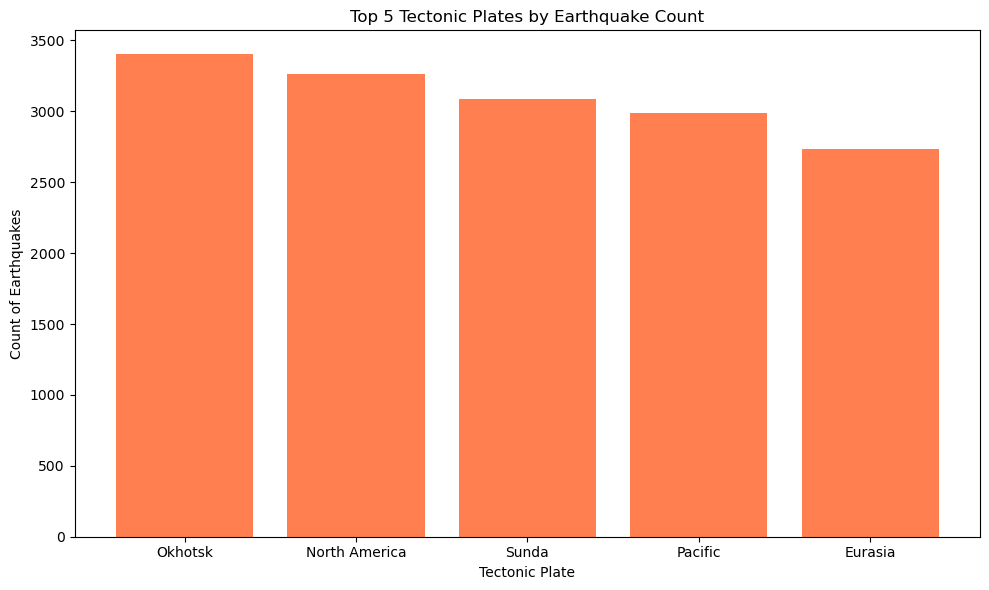

In [5]:
print(df["PlateName"].value_counts())
print(df["PlateName"].value_counts().mean())

# Getting the value counts for "PlateName"
plate_counts = df["PlateName"].value_counts()

# Convert the Series into a DataFrame
plate_counts_df = plate_counts.reset_index()
# Rename the columns to "Plate" and "Count"
plate_counts_df.columns = ['Plate', 'Count']

# Selecting the top 5 plates with the most earthquakes
top_5_plates = plate_counts_df.head(5)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_5_plates['Plate'], top_5_plates['Count'], color='coral')
plt.xlabel('Tectonic Plate')
plt.ylabel('Count of Earthquakes')
plt.title('Top 5 Tectonic Plates by Earthquake Count')
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()


C:\Users\Harrys\AppData\Local\Temp\ipykernel_16428\2560004831.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


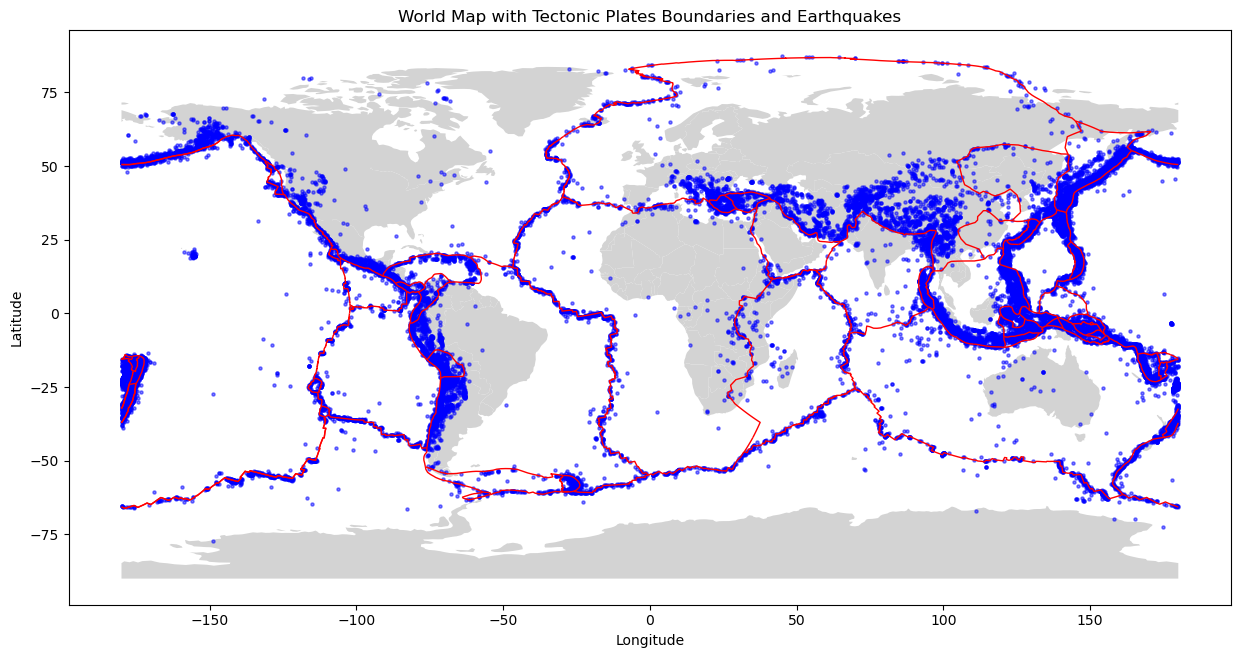

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the tectonic plates boundaries GeoJSON
gdf_plates_boundaries = gpd.read_file('C:/Users/Harrys/Desktop/Thesis/plates mapping/PB2002_boundaries.json')

# Read earthquakes data 
df_earthquakes = df[(df['latitude'] != -999) & (df['longitude'] != -999)].copy()

# Convert the filtered earthquake DataFrame to a GeoDataFrame
gdf_earthquakes = gpd.GeoDataFrame(df_earthquakes, geometry=gpd.points_from_xy(df_earthquakes.longitude, df_earthquakes.latitude), crs="EPSG:4326")

# Load a simple world map as the base
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Start plotting
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the world map
world.plot(ax=ax, color='lightgrey')

# Plot the tectonic plates boundaries
gdf_plates_boundaries.plot(ax=ax, color='red', linewidth=1)

# Plot the earthquakes, excluding those with placeholder coordinates
gdf_earthquakes.plot(ax=ax, color='blue', markersize=5, alpha=0.5)

# Set the title and axes labels
ax.set_title('World Map with Tectonic Plates Boundaries and Earthquakes')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


## Adding features

In [7]:
## Adding time features
df['time'] = pd.to_datetime(df['time'])

# Check the result
print(f"head of columns time: {df['time'].head()}")

# Extract time-based features
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek

# cyclical encoding for cyclical features like hour and day_of_week
df['day_of_week_sin'] = np.sin(df['day_of_week'] * (2 * np.pi / 7))
df['day_of_week_cos'] = np.cos(df['day_of_week'] * (2 * np.pi / 7))
df['month_sin'] = np.sin((df['month'] - 1) * (2 * np.pi / 12))  # -1 to adjust month index from 1-12 to 0-11
df['month_cos'] = np.cos((df['month'] - 1) * (2 * np.pi / 12))

df.drop(columns=["hour"])

#removing the year 2024 because it is unbalanced to include it
df = df[df['year'] != 2024.0]
 
print(f" df head : {df.head()}")
print("#################")
print(f"df columns: {df.columns}")

head of columns time: 0   2024-01-31
1   2024-01-29
2   2024-01-28
3   2024-01-27
4   2024-01-25
Name: time, dtype: datetime64[ns]
 df head :          time  latitude  longitude   depth  mag       countries  PlateName  \
37 2023-12-30   -2.9934   139.3720  33.000  6.3       Indonesia      Maoke   
38 2023-12-30   -3.2050   139.2890  10.000  6.5       Indonesia      Maoke   
39 2023-12-30    2.4949    92.9942  19.000  5.7       Indonesia      India   
40 2023-12-30  -49.2906  -116.2051  10.000  5.9           Chile    Pacific   
41 2023-12-29   -7.1134    67.9800   9.929  5.7  United Kingdom  Australia   

    year  month  day  hour  day_of_week  day_of_week_sin  day_of_week_cos  \
37  2023     12   30     0            5        -0.974928        -0.222521   
38  2023     12   30     0            5        -0.974928        -0.222521   
39  2023     12   30     0            5        -0.974928        -0.222521   
40  2023     12   30     0            5        -0.974928        -0.222521   
41  

Adding features

In [8]:
## Adding features

# Sort the DataFrame by the 'time' column in ascending order
df = df.sort_values(by='time', ascending=True)

# 'country_event_id' column is added to count events per country from oldest to newest
df['country_event_id'] = df.groupby('countries').cumcount() + 1

# Calculate the mean magnitude up to the current point in time for each country
df['mean mag'] = df.groupby('countries')['mag'].expanding().mean().reset_index(level=0, drop=True)

# Calculate the Magnitude Difference compared to the previous event within the same country
df['prev_mag'] = df.groupby('countries')['mag'].shift(1)
df['Magnitude Difference'] = df['mag'] - df['prev_mag']
# Handle NaN values that result from the shift operation for the first occurrence in each group
df['Magnitude Difference'] = df['Magnitude Difference'].fillna(0)

# Directly count earthquakes from oldest to newest for 'number of earthquakes' without reversing the DataFrame
df['number of earthquakes'] = df.groupby('countries').cumcount() + 1

# Drop the intermediate 'prev_mag' and 'country_event_id' columns as they are no longer needed
df.drop(['prev_mag', 'country_event_id'], axis=1, inplace=True)

# Display the DataFrame with the new columns
print(df[['countries', 'mean mag', 'number of earthquakes', 'Magnitude Difference']])
df.to_csv("check the features mean mag and # of quakes.csv")
print(f"df columns: {df.columns}")

                      countries  mean mag  number of earthquakes  \
37577  United States of America  7.860000                      1   
37576  United States of America  7.130000                      2   
37575  United States of America  7.086667                      3   
37574  United States of America  7.090000                      4   
37573  United States of America  7.072000                      5   
...                         ...       ...                    ...   
41               United Kingdom  5.860092                   1304   
40                        Chile  5.947672                   1761   
39                    Indonesia  5.924442                   4289   
38                    Indonesia  5.924576                   4290   
37                    Indonesia  5.924663                   4291   

       Magnitude Difference  
37577                  0.00  
37576                 -1.46  
37575                  0.60  
37574                  0.10  
37573                 -0.10  
...

transforming integers to floats

In [9]:
## Transforming integers to floats

# List of columns to convert from int64 to float64
int_columns = df.select_dtypes(include=['int64']).columns

# Convert each column in the list to float64
df[int_columns] = df[int_columns].astype('float64')

# Check the data types to confirm the conversion
print(df.dtypes)

time                     datetime64[ns]
latitude                        float64
longitude                       float64
depth                           float64
mag                             float64
countries                        object
PlateName                        object
year                            float64
month                           float64
day                             float64
hour                            float64
day_of_week                     float64
day_of_week_sin                 float64
day_of_week_cos                 float64
month_sin                       float64
month_cos                       float64
mean mag                        float64
Magnitude Difference            float64
number of earthquakes           float64
dtype: object


## Earthquakes per year and outliers

In [10]:
# Group by 'year' and count the occurrences
yearly_count = df.groupby('year').size().reset_index(name='count')
print(yearly_count)

# Calculate the mean and standard deviation of the yearly earthquake counts
mean_earthquakes = yearly_count['count'].mean()
std_earthquakes = yearly_count['count'].std()

# Define a threshold for what we consider an outlier
threshold = std_earthquakes

# Find years where the earthquake count is significantly lower than the mean minus the threshold
potential_outlier_years = yearly_count[yearly_count['count'] < mean_earthquakes - threshold]

print("Potential outlier years based on a low number of earthquakes:")
print(potential_outlier_years['year'])

       year  count
0    1900.0      1
1    1901.0      3
2    1902.0      2
3    1903.0      5
4    1904.0      9
..      ...    ...
119  2019.0    443
120  2020.0    405
121  2021.0    561
122  2022.0    446
123  2023.0    523

[124 rows x 2 columns]
Potential outlier years based on a low number of earthquakes:
0     1900.0
1     1901.0
2     1902.0
3     1903.0
4     1904.0
5     1905.0
6     1906.0
7     1907.0
8     1908.0
9     1909.0
10    1910.0
11    1911.0
12    1912.0
13    1913.0
14    1914.0
15    1915.0
16    1916.0
17    1917.0
18    1918.0
19    1919.0
20    1920.0
21    1921.0
22    1922.0
23    1923.0
24    1924.0
44    1944.0
45    1945.0
47    1947.0
Name: year, dtype: float64


In [11]:
# In 1961 The World Wide Standardized Seismographic Network (WWSSN) is started.
# With that information and from the above data we will only include the years from 1962 and above

# Filter the DataFrame to keep only rows where 'year' is 1962 or later
df = df[df['year'] >= 1962]

In [12]:
duplicates = df.duplicated(keep=False)

# Count the number of duplicates
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


In [13]:
# keep='first' marks all duplicates as True except for the first occurrence.
duplicates = df.duplicated(keep='first')

# To see the duplicate rows, we can filter df like this:
duplicate_rows = df[duplicates]

print("Duplicate Rows (except first occurrence):")
print(duplicate_rows)

Duplicate Rows (except first occurrence):
Empty DataFrame
Columns: [time, latitude, longitude, depth, mag, countries, PlateName, year, month, day, hour, day_of_week, day_of_week_sin, day_of_week_cos, month_sin, month_cos, mean mag, Magnitude Difference, number of earthquakes]
Index: []


## updating the features to start counting from 1962

In [14]:
# Reset the index
df.reset_index(drop=True, inplace=True)

# Recalculate the features for the filtered data
df['country_event_id'] = df.groupby('countries').cumcount() + 1
df['mean mag'] = df.groupby('countries')['mag'].expanding().mean().reset_index(level=0, drop=True)
df['prev_mag'] = df.groupby('countries')['mag'].shift(1)
df['Magnitude Difference'] = df['mag'] - df['prev_mag']
df['Magnitude Difference'] = df['Magnitude Difference'].fillna(0)
df['number of earthquakes'] = df.groupby('countries').cumcount() + 1

# Drop the 'prev_mag' column
df.drop(['prev_mag', 'country_event_id'], axis=1, inplace=True)

# Now DataFrame starts calculating features from 1962 onwards
df.to_csv("updated_features_post_1962.csv")
print(f"Updated df columns: {df.columns}")

# removing duplicated that were created
# keep='first' marks all duplicates as True except for the first occurrence.
duplicates = df.duplicated(keep='first')

# To see if there are duplicate rows, we filter the df
duplicate_rows = df[duplicates]

print("Duplicate Rows (except first occurrence):")
print(duplicate_rows)

Updated df columns: Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'countries',
       'PlateName', 'year', 'month', 'day', 'hour', 'day_of_week',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'mean mag', 'Magnitude Difference', 'number of earthquakes'],
      dtype='object')
Duplicate Rows (except first occurrence):
Empty DataFrame
Columns: [time, latitude, longitude, depth, mag, countries, PlateName, year, month, day, hour, day_of_week, day_of_week_sin, day_of_week_cos, month_sin, month_cos, mean mag, Magnitude Difference, number of earthquakes]
Index: []


## create target variable

target variable is the feature "counter" which is a counter for each country and specifies the days until the next earthquake 

In [15]:
# Create a copy of the relevant columns to calculate the counter without losing the original order
df_countries = df[['time', 'countries', 'mag', 'depth', 'hour', 'latitude', 'longitude']].copy()

# Sort by countries and time to prepare for the 'counter' calculation
df_countries.sort_values(['countries', 'time', 'mag', 'depth', 'hour', 'latitude', 'longitude'], inplace=True)

# Calculate the days until the next earthquake within each country
# shift(): for each row, the 'next_earthquake' column will hold the date of the next earthquake event in that country.
df_countries['next_earthquake'] = df_countries.groupby('countries')['time'].shift(-1)
df_countries['counter'] = (pd.to_datetime(df_countries['next_earthquake']) - df_countries['time']).dt.days

# Merge the 'counter' column back into the original dataframe using 'time' and 'countries' as keys
df = df.merge(df_countries[['time', 'countries', 'counter', 'mag', 'depth', 'hour', 'latitude', 'longitude']], on=['time', 'countries', 'mag', 'depth', 'hour', 'latitude', 'longitude'], how='left')

df['time'] = df['time'].dt.tz_localize(None)
# Remove microseconds by flooring to the nearest second
df['time'] = df['time'].dt.floor('S')

print(f"df columns: {df.columns}")
df.to_csv("check_of_the_counter_feature.csv")

# Removing duplicate rows, keeping the first occurrence of each duplicate
df = df.drop_duplicates(keep='first')
train_df = df

df columns: Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'countries',
       'PlateName', 'year', 'month', 'day', 'hour', 'day_of_week',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'mean mag', 'Magnitude Difference', 'number of earthquakes', 'counter'],
      dtype='object')


## missing values

In [16]:
# Check the number of missing values in each column of the train df
missing_values_train = train_df.isnull().sum()
# Print the number of missing values for each column
print(f" number of missing values for each column: {missing_values_train}")

# Calculate the total number of missing values in the train df
total_missing_values_train = train_df.isnull().sum().sum()
# Print the total number of missing values in the train df
print(f"Total missing values in train_df_encoded: {total_missing_values_train}")

 number of missing values for each column: time                       0
latitude                   0
longitude                  0
depth                      1
mag                        0
countries                  0
PlateName                  0
year                       0
month                      0
day                        0
hour                       0
day_of_week                0
day_of_week_sin            0
day_of_week_cos            0
month_sin                  0
month_cos                  0
mean mag                   0
Magnitude Difference       0
number of earthquakes      0
counter                  136
dtype: int64
Total missing values in train_df_encoded: 137


In [17]:
# marks all duplicates as True except for the first occurrence.
duplicates = df.duplicated(keep='first')

# To see the duplicate rows
duplicate_rows = df[duplicates]

print("Duplicate Rows (except first occurrence):")
print(duplicate_rows)

Duplicate Rows (except first occurrence):
Empty DataFrame
Columns: [time, latitude, longitude, depth, mag, countries, PlateName, year, month, day, hour, day_of_week, day_of_week_sin, day_of_week_cos, month_sin, month_cos, mean mag, Magnitude Difference, number of earthquakes, counter]
Index: []


## deleting countries that are outliers. Specifically the countries that have very few earthquakes

In [18]:
unique_countres = train_df["countries"].nunique()
print(f"number of unique countries: {unique_countres}")
print(train_df["number of earthquakes"].describe())

number of unique countries: 136
count    28063.000000
mean       705.997114
std        722.924361
min          1.000000
25%        154.000000
50%        496.000000
75%       1007.000000
max       3610.000000
Name: number of earthquakes, dtype: float64


In [19]:
# Count earthquakes for each country
earthquake_counts = train_df['countries'].value_counts()
print(f"number of earthquakes in each country: {earthquake_counts}")
# Determine percentile as the outlier threshold
threshold = earthquake_counts.quantile(0.5) # determining outliers by the median

# Filter for countries below the threshold
outlier_countries = earthquake_counts[earthquake_counts <= threshold]
print(f"size of outliers: {outlier_countries.size}")
# Print the outlier countries and their earthquake counts
print("Outlier Countries with Low Earthquake Counts:")
for country, count in outlier_countries.iteritems():
    print(f"{country}: {count}")


# Get the list of outlier countries
outlier_countries_list = outlier_countries.index.tolist()
#deleting outlier countries
train_df = train_df[~train_df["countries"].isin(outlier_countries_list)]

number of earthquakes in each country: Indonesia                   3610
Japan                       2040
United States of America    1930
Papua New Guinea            1822
Russia                      1541
                            ... 
Guinea                         1
Poland                         1
Vietnam                        1
Marshall Islands               1
Malta                          1
Name: countries, Length: 136, dtype: int64
size of outliers: 70
Outlier Countries with Low Earthquake Counts:
Haiti: 11
Mozambique: 11
Albania: 11
Georgia: 11
Azerbaijan: 11
Palau: 10
Uzbekistan: 10
Djibouti: 10
Egypt: 9
Kazakhstan: 9
Bosnia and Herzegovina: 9
Bangladesh: 8
Sri Lanka: 8
Cyprus: 8
Cuba: 7
Laos: 7
Turkmenistan: 7
Croatia: 7
Morocco: 7
Bhutan: 7
Eritrea: 7
Saudi Arabia: 6
Malawi: 6
Zambia: 6
Malaysia: 6
South Sudan: 6
Somaliland: 6
Oman: 5
North Korea: 5
South Korea: 5
Republic of Serbia: 4
Spain: 4
Montenegro: 4
Madagascar: 4
Uganda: 4
Libya: 3
Thailand: 3
Iraq: 3
Dominica: 2


C:\Users\Harrys\AppData\Local\Temp\ipykernel_16428\1174252201.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for country, count in outlier_countries.iteritems():


In [20]:
# Count unique countries in the 'countries' column
unique_countres = train_df["countries"].nunique()
print(f"number of unique countries: {unique_countres}")

number of unique countries: 66


## outliers of countries that have rarely earthquakes

In [21]:
# Calculate the overall IQR for 'counter'
overall_Q1 = train_df['counter'].quantile(0.25)
overall_Q3 = train_df['counter'].quantile(0.75)
overall_IQR = overall_Q3 - overall_Q1

# Define the outlier cutoffs for the overall data
overall_lower_bound = overall_Q1 - 3 * overall_IQR
overall_upper_bound = overall_Q3 + 3 * overall_IQR

# Calculate the median 'counter' for each country
median_counters = train_df.groupby('countries')['counter'].median()

# Determine which countries have a median 'counter' that is an outlier
outlier_countries = median_counters[(median_counters < overall_lower_bound) | (median_counters > overall_upper_bound)]

pd.set_option('display.max_rows', None) 
print("Countries considered as outliers based on their median 'counter':")
print(outlier_countries)
print(f"number of countries considered outliers: {outlier_countries.size}")


Countries considered as outliers based on their median 'counter':
countries
Algeria                             748.0
Antigua and Barbuda                 870.0
Barbados                            487.5
Bolivia                             213.0
Costa Rica                          152.0
Democratic Republic of the Congo    623.0
Denmark                             230.0
Dominican Republic                  391.0
East Timor                          756.0
El Salvador                         133.0
Federated States of Micronesia      166.0
Honduras                            475.0
Iceland                             448.0
Kyrgyzstan                          318.0
Maldives                            545.0
Mauritius                           229.0
Mongolia                            297.0
Romania                             670.5
South Africa                        140.0
Tajikistan                          423.0
United Republic of Tanzania         665.0
Venezuela                           393.0


In [22]:
# 'outlier_countries' is a Series with country names as the index and median 'counter' as the values
# Get the list of outlier country names
outlier_country_names = outlier_countries.index.tolist()

# Filter out the outliers
train_df = train_df[~train_df['countries'].isin(outlier_country_names)]

# Inspect the unique values in the "countries" column
remaining_countries = train_df['countries'].unique()

nu_countries = len(remaining_countries)
print(f"Number of unique countries: {nu_countries} and \nRemaining countries in the DataFrame: {remaining_countries}")

Number of unique countries: 43 and 
Remaining countries in the DataFrame: ['United States of America' 'Japan' 'France' 'Samoa' 'Greece' 'Tonga'
 'New Zealand' 'Indonesia' 'United Kingdom' 'Papua New Guinea' 'Chile'
 'Colombia' 'India' 'Myanmar' 'Solomon Islands' 'Philippines' 'Panama'
 'Brazil' 'Vanuatu' 'China' 'Iran' 'Peru' 'Russia' 'Mexico' 'Fiji'
 'Portugal' 'Canada' 'Antarctica' 'Afghanistan' 'Australia' 'Italy'
 'Pakistan' 'Argentina' 'Taiwan' 'Ecuador' 'Turkey' 'Nicaragua' 'Norway'
 'Guatemala' 'Nepal' 'Ethiopia' 'Kiribati' 'Trinidad and Tobago']


Checking the missing data in the data

In [23]:
# Check the number of missing values in each column of the train df
missing_values_train = train_df.isnull().sum()
# Print the number of missing values for each column
print(missing_values_train)

time                      0
latitude                  0
longitude                 0
depth                     1
mag                       0
countries                 0
PlateName                 0
year                      0
month                     0
day                       0
hour                      0
day_of_week               0
day_of_week_sin           0
day_of_week_cos           0
month_sin                 0
month_cos                 0
mean mag                  0
Magnitude Difference      0
number of earthquakes     0
counter                  43
dtype: int64


In [24]:
#The following is to assure that the countries that have NaN in "counter" are not countries with very small number of earthquakes.

# Filter the DataFrame to include only rows where 'counter' is missing
missing_counter_df = train_df[train_df['counter'].isnull()]

# Group by 'countries' and get the first occurrence to see the 'number of earthquakes' for those entries
missing_counter_countries = missing_counter_df.groupby('countries')['number of earthquakes'].first()

# Print the result
print(missing_counter_countries)

countries
Afghanistan                  178
Antarctica                   671
Argentina                    280
Australia                    279
Brazil                       238
Canada                       113
Chile                       1453
China                        401
Colombia                     180
Ecuador                      244
Ethiopia                      19
Fiji                        1057
France                       721
Greece                       193
Guatemala                    146
India                        276
Indonesia                   3609
Iran                         229
Italy                         54
Japan                       2040
Kiribati                      13
Mexico                       581
Myanmar                      112
Nepal                         27
New Zealand                 1262
Nicaragua                    125
Norway                       153
Pakistan                      99
Panama                       130
Papua New Guinea            1822


Boxplot of the feature "counter" for every country

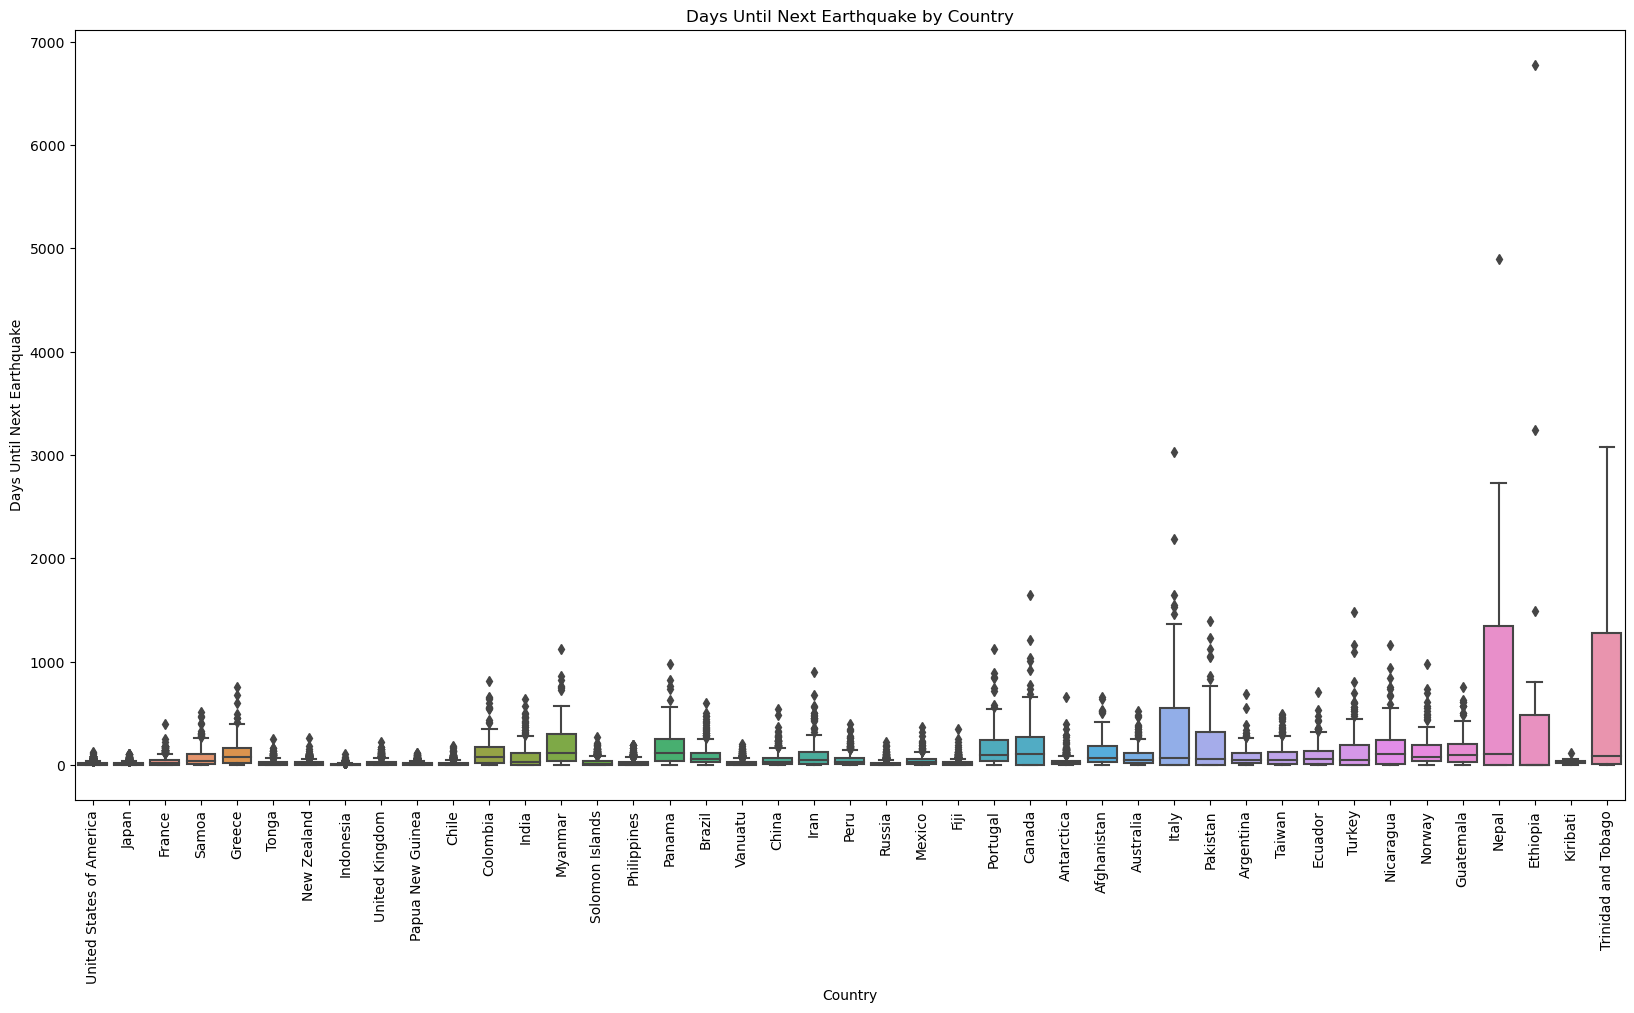

In [25]:
# Create the box plot
plt.figure(figsize=(20, 10))
sns.boxplot(x='countries', y='counter', data=train_df)

plt.xticks(rotation=90) 
plt.title('Days Until Next Earthquake by Country')
plt.xlabel('Country')
plt.ylabel('Days Until Next Earthquake')

plt.show()

dropping the uneccessary column of "hour"

In [26]:
print(f"train_df shape: {train_df.shape}")

train_df shape: (26763, 20)


In [27]:
train_df = train_df.drop(columns=["hour"])

## number of row and DAY gaps we have in the dataset

In [28]:
train_df['time'] = pd.to_datetime(train_df['time'])

# Calculate the difference in days between consecutive earthquake dates
train_df['date_diff'] = train_df['time'].diff().dt.days

# Find the number of gaps (where the difference in days is greater than 1)
num_gaps = (train_df['date_diff'] > 1).sum()

print(f"Number of gaps in train timeseries: {num_gaps}")
train_df.to_csv("train_df_without_filled_time_gaps.csv")

Number of gaps in train timeseries: 5016


In [29]:
def calculate_total_missing_days(df):
    # Convert the 'time' column to datetime if not already
    df['time'] = pd.to_datetime(df['time'])

    # Calculate the difference in days between consecutive earthquake dates
    df['date_diff'] = df['time'].diff().dt.days

    # Find total missing days by summing the days in gaps greater than 1 day
    total_missing_days = (df['date_diff'] - 1).where(df['date_diff'] > 1).sum()

    return total_missing_days

# Usage
train_total_missing_days = calculate_total_missing_days(train_df)
#test_total_missing_days = calculate_total_missing_days(test_df)

print(f"Total missing days in train timeseries: {train_total_missing_days}")
#print(f"Total missing days in test timeseries: {test_total_missing_days}")

Total missing days in train timeseries: 8199.0


In [30]:
# check that everything is okay
print(f"train shape: {train_df.shape}")
#print(f"test shape: {test_df.shape}")
print("############")

print(train_df.head(10))
print("###########")
#print(test_df.head(10))
print("###########")

print(train_df.dtypes)
#print(test_df.dtypes)

train shape: (26763, 20)
############
         time  latitude  longitude  depth   mag                 countries  \
0  1962-01-01    52.112    177.594   25.0  5.88  United States of America   
1  1962-01-04    33.623    135.317   50.0  6.18                     Japan   
2  1962-01-05   -15.356   -177.611   55.0  6.21                    France   
3  1962-01-05   -15.630   -172.436   25.0  5.88                     Samoa   
6  1962-01-09    42.753    145.152   49.0  6.04                     Japan   
8  1962-01-19    38.503     22.102   25.0  5.63                    Greece   
9  1962-01-26    35.191     22.769   25.0  5.96                    Greece   
10 1962-01-28   -17.104   -171.932   18.1  6.10                     Tonga   
11 1962-02-01   -31.642   -177.151   15.0  5.63               New Zealand   
12 1962-02-03    -1.311    137.474   23.0  6.31                 Indonesia   

        PlateName    year  month   day  day_of_week  day_of_week_sin  \
0   North America  1962.0    1.0   1.0    

## Filling the day gaps in our time series with NaN values and adding features about time

In [31]:
# function for filling the day gaps
def fill_date_gaps_and_add_features(df):
    # Ensure 'time' is in datetime format
    df['time'] = pd.to_datetime(df['time'])

    # Creating a complete date range from the start to the end of the dataset
    date_range = pd.date_range(start=df['time'].min(), end=df['time'].max(), freq='D')

    # Creating a new DataFrame with the complete date range
    df_complete = pd.DataFrame(date_range, columns=['time'])

    # Merging the complete date range DataFrame with the original DataFrame
    # This will introduce NaN values for days where there was no earthquake
    df_merged = df_complete.merge(df, on='time', how='left')

    # Extracting date-related features
    df_merged['year'] = df_merged['time'].dt.year
    df_merged['month'] = df_merged['time'].dt.month
    df_merged['day'] = df_merged['time'].dt.day
    df_merged['day_of_week'] = df_merged['time'].dt.dayofweek
    df_merged['day_of_week_sin'] = np.sin(df_merged['day_of_week'] * (2. * np.pi / 7))
    df_merged['day_of_week_cos'] = np.cos(df_merged['day_of_week'] * (2. * np.pi / 7))
    df_merged['month_sin'] = np.sin((df_merged['month'] - 1) * (2. * np.pi / 12))
    df_merged['month_cos'] = np.cos((df_merged['month'] - 1) * (2. * np.pi / 12))

    return df_merged

train_df = fill_date_gaps_and_add_features(train_df)

In [32]:
print(train_df.head(15))

         time  latitude  longitude  depth   mag                 countries  \
0  1962-01-01    52.112    177.594   25.0  5.88  United States of America   
1  1962-01-02       NaN        NaN    NaN   NaN                       NaN   
2  1962-01-03       NaN        NaN    NaN   NaN                       NaN   
3  1962-01-04    33.623    135.317   50.0  6.18                     Japan   
4  1962-01-05   -15.356   -177.611   55.0  6.21                    France   
5  1962-01-05   -15.630   -172.436   25.0  5.88                     Samoa   
6  1962-01-06       NaN        NaN    NaN   NaN                       NaN   
7  1962-01-07       NaN        NaN    NaN   NaN                       NaN   
8  1962-01-08       NaN        NaN    NaN   NaN                       NaN   
9  1962-01-09    42.753    145.152   49.0  6.04                     Japan   
10 1962-01-10       NaN        NaN    NaN   NaN                       NaN   
11 1962-01-11       NaN        NaN    NaN   NaN                       NaN   

In [33]:
print(train_df.columns)

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'countries',
       'PlateName', 'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'counter',
       'date_diff'],
      dtype='object')


## Time shifting for multiple earthuqakes in one day

Because in some days we had multiple earthquakes across the world (or across a country) we also have some rows with the same date of earthquake occurence.

Because we have to maintain continuity and because we can't afford to lose so many earthquakes from our dataset, we will not delete those rows. On the contrary we will perform a time shift for them with a small time window, so we do not effect negatively the real data.

Consequently, we will correct the issue with earthquakes having the same date and at the same time we will fill some day gaps we have by time shifting those multiple earthquakes that have happened in the same date.

In [34]:
def find_max_earthquakes_per_day(df):
    # Convert 'year', 'month', 'day' into a single 'date' column for easier grouping
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    # Count occurrences per day
    max_earthquakes = df['date'].value_counts().max()
    return max_earthquakes


max_earthquakes_per_day = find_max_earthquakes_per_day(train_df)
print(f"The maximum number of earthquakes on a single day is: {max_earthquakes_per_day}")


The maximum number of earthquakes on a single day is: 128


In [35]:
# Group by 'time' and count occurrences to find days with multiple earthquakes
earthquake_counts = train_df.groupby('time').size()

# Filter days with more than one earthquake
multiple_earthquake_days = earthquake_counts[earthquake_counts > 1]

# Number of days with multiple earthquakes
num_days_multiple_earthquakes = multiple_earthquake_days.count()

# Total number of earthquakes on days with multiple earthquakes
total_earthquakes_multiple_days = multiple_earthquake_days.sum()

# Print the results
print("Number of days with multiple earthquakes:", num_days_multiple_earthquakes)
print("Total number of earthquakes on these days:", total_earthquakes_multiple_days)


Number of days with multiple earthquakes: 6851
Total number of earthquakes on these days: 19169


In [36]:
print(train_df.columns)

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'countries',
       'PlateName', 'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'counter', 'date_diff',
       'date'],
      dtype='object')


In [37]:
train_df['time'] = pd.to_datetime(train_df['time'])

# Create a full DataFrame for every day in the date range
date_range = pd.date_range(start=train_df['time'].min(), end=train_df['time'].max())
full_df = pd.DataFrame(date_range, columns=['time'])
full_df = full_df.merge(train_df, on='time', how='left', sort=True)

# Split data into records with earthquakes and records without (NaN)
with_earthquakes = full_df.dropna(subset=['latitude', 'longitude', 'depth', 'mag'])
without_earthquakes = full_df[full_df['latitude'].isna()]

# Process excess earthquakes
duplicates = with_earthquakes[with_earthquakes.duplicated('time', keep=False)]
excess_earthquakes = duplicates.groupby('time').tail(-1)  # All but the first earthquake of each duplicated day
with_earthquakes = with_earthquakes.drop(excess_earthquakes.index)  # Drop excess from the main df initially

# Print number of excess earthquakes
print(f"Number of excess earthquakes to redistribute: {len(excess_earthquakes)}")

# Redistribute excess earthquakes to the nearest days without earthquakes within 10 days
for idx, row in excess_earthquakes.iterrows():
    # Calculate the time difference for eligible empty days
    without_earthquakes['time_diff'] = (without_earthquakes['time'] - row['time']).abs()
    
    # Filter for empty days within a 10-day window
    eligible_days = without_earthquakes[without_earthquakes['time_diff'] <= pd.Timedelta(days=10)]
    
    if not eligible_days.empty:
        nearest_index = eligible_days['time_diff'].idxmin()
        
        # Move the earthquake data to the closest empty date within the window
        for col in ['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName']:
            full_df.at[nearest_index, col] = row[col]
        
        # Remove the now filled date from the without_earthquakes dataframe to avoid refilling
        without_earthquakes = without_earthquakes.drop(nearest_index)
    else:
        continue

# Remove additional column we created
full_df.drop(columns=['time_diff'], inplace=True, errors='ignore')

# Ensure sorting by date
full_df.sort_values('time', inplace=True)

# Rename full_df to train_df 
train_df = full_df

# Result check
print(train_df.head(10))

Number of excess earthquakes to redistribute: 12317


C:\Users\Harrys\AppData\Local\Temp\ipykernel_16428\4026243980.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  without_earthquakes['time_diff'] = (without_earthquakes['time'] - row['time']).abs()


        time  latitude  longitude  depth   mag                 countries  \
0 1962-01-01    52.112    177.594   25.0  5.88  United States of America   
1 1962-01-02       NaN        NaN    NaN   NaN                       NaN   
2 1962-01-03       NaN        NaN    NaN   NaN                       NaN   
3 1962-01-04    33.623    135.317   50.0  6.18                     Japan   
4 1962-01-05   -15.356   -177.611   55.0  6.21                    France   
5 1962-01-05   -15.630   -172.436   25.0  5.88                     Samoa   
6 1962-01-06   -15.630   -172.436   25.0  5.88                     Samoa   
7 1962-01-07       NaN        NaN    NaN   NaN                       NaN   
8 1962-01-08       NaN        NaN    NaN   NaN                       NaN   
9 1962-01-09    42.753    145.152   49.0  6.04                     Japan   

       PlateName  year  month  day  ...  day_of_week_sin  day_of_week_cos  \
0  North America  1962      1    1  ...         0.000000         1.000000   
1        

In [38]:
print(train_df.shape)
# Count rows with NaN in the 'latitude' column
nan_latitude_count = train_df['latitude'].isna().sum()

# Print the result
print("Number of rows with NaN in the 'latitude' column:", nan_latitude_count)

"""
After time shifting some earthquakes in a small time window of 10 days, which would also be acceptable as an error, we end up with only 6% missing data. We will impute later on those missing data with KNN
"""

(34962, 21)
Number of rows with NaN in the 'latitude' column: 1385


'\nAfter time shifting some earthquakes in a small time window of 10 days, which would also be acceptable as an error, we end up with only 6% missing data. We will impute later on those missing data with KNN\n'

In [39]:
train_df = train_df.drop_duplicates(subset='time', keep='first')
# Reset the index of the training dataset
train_df = train_df.reset_index(drop=True)
print(train_df.head(10))
# Usage
print(train_df.shape)
# Count rows with NaN in the 'latitude' column
nan_latitude_count = train_df['latitude'].isna().sum()

# Print the result
print("Number of rows with NaN in the 'latitude' column:", nan_latitude_count)

        time  latitude  longitude  depth   mag                 countries  \
0 1962-01-01    52.112    177.594   25.0  5.88  United States of America   
1 1962-01-02       NaN        NaN    NaN   NaN                       NaN   
2 1962-01-03       NaN        NaN    NaN   NaN                       NaN   
3 1962-01-04    33.623    135.317   50.0  6.18                     Japan   
4 1962-01-05   -15.356   -177.611   55.0  6.21                    France   
5 1962-01-06   -15.630   -172.436   25.0  5.88                     Samoa   
6 1962-01-07       NaN        NaN    NaN   NaN                       NaN   
7 1962-01-08       NaN        NaN    NaN   NaN                       NaN   
8 1962-01-09    42.753    145.152   49.0  6.04                     Japan   
9 1962-01-10       NaN        NaN    NaN   NaN                       NaN   

       PlateName  year  month  day  ...  day_of_week_sin  day_of_week_cos  \
0  North America  1962      1    1  ...         0.000000         1.000000   
1        

## Now we will update the column "counter", after the time shifting

In [40]:

# First, ensure that 'time' is in datetime format if it's not already
train_df['time'] = pd.to_datetime(train_df['time'])

# Create a copy of the relevant columns to calculate the counter
df_temp = train_df[['time', 'countries']].copy()

# Sort the copy by 'countries' and 'time' to ensure proper sequential processing
df_temp.sort_values(by=['countries', 'time'], inplace=True)

# Calculate the time until the next earthquake within each country
# Use shift within the group to get the time of the next earthquake
df_temp['next_earthquake'] = df_temp.groupby('countries')['time'].shift(-1)

# Calculate the 'counter' as the difference in days between earthquakes
df_temp['counter'] = (df_temp['next_earthquake'] - df_temp['time']).dt.days

# Drop the temporary 'next_earthquake' column as it's no longer needed
df_temp.drop('next_earthquake', axis=1, inplace=True)

# Merge the new 'counter' column back to the original dataframe, matching on 'time' and 'countries'
train_df = train_df.merge(df_temp[['time', 'countries', 'counter']], on=['time', 'countries'], how='left')

# Drop the 'counter_x' column (the original counter) and rename 'counter_y' (the updated counter)
train_df.drop('counter_x', axis=1, inplace=True) # Drop the old counter column
train_df.rename(columns={'counter_y': 'counter'}, inplace=True)  # Rename the new counter column

# Reset the index of the training dataset
train_df = train_df.reset_index(drop=True)

In [41]:
# Now df contains the updated 'counter' column, with the original order preserved
print(train_df.head(15))

         time  latitude  longitude  depth   mag                 countries  \
0  1962-01-01    52.112    177.594   25.0  5.88  United States of America   
1  1962-01-02       NaN        NaN    NaN   NaN                       NaN   
2  1962-01-03       NaN        NaN    NaN   NaN                       NaN   
3  1962-01-04    33.623    135.317   50.0  6.18                     Japan   
4  1962-01-05   -15.356   -177.611   55.0  6.21                    France   
5  1962-01-06   -15.630   -172.436   25.0  5.88                     Samoa   
6  1962-01-07       NaN        NaN    NaN   NaN                       NaN   
7  1962-01-08       NaN        NaN    NaN   NaN                       NaN   
8  1962-01-09    42.753    145.152   49.0  6.04                     Japan   
9  1962-01-10       NaN        NaN    NaN   NaN                       NaN   
10 1962-01-11       NaN        NaN    NaN   NaN                       NaN   
11 1962-01-12       NaN        NaN    NaN   NaN                       NaN   

In [42]:
# Check the number of missing values in each column of the train df
missing_values_train = train_df.isnull().sum()
# Print the number of missing values for each column
print(missing_values_train)

"""
We end up with 6.3% missing data for the counter feature. There are 43 more missing data than latitude because there are 43 earthquakes that were the last recorded in those countries and therefore we dont know when the next earthquake will happen.
"""

time                        0
latitude                 1385
longitude                1385
depth                    1386
mag                      1385
countries                1385
PlateName                1385
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin             0
day_of_week_cos             0
month_sin                   0
month_cos                   0
mean mag                 8199
Magnitude Difference     8199
number of earthquakes    8199
date_diff                8200
date                        0
counter                  1428
dtype: int64


'\nWe end up with 6.3% missing data for the counter feature. There are 43 more missing data than latitude because there are 43 earthquakes that were the last recorded in those countries and therefore we dont know when the next earthquake will happen.\n'

In [43]:
print(train_df.head(10))

        time  latitude  longitude  depth   mag                 countries  \
0 1962-01-01    52.112    177.594   25.0  5.88  United States of America   
1 1962-01-02       NaN        NaN    NaN   NaN                       NaN   
2 1962-01-03       NaN        NaN    NaN   NaN                       NaN   
3 1962-01-04    33.623    135.317   50.0  6.18                     Japan   
4 1962-01-05   -15.356   -177.611   55.0  6.21                    France   
5 1962-01-06   -15.630   -172.436   25.0  5.88                     Samoa   
6 1962-01-07       NaN        NaN    NaN   NaN                       NaN   
7 1962-01-08       NaN        NaN    NaN   NaN                       NaN   
8 1962-01-09    42.753    145.152   49.0  6.04                     Japan   
9 1962-01-10       NaN        NaN    NaN   NaN                       NaN   

       PlateName  year  month  day  ...  day_of_week_sin  day_of_week_cos  \
0  North America  1962      1    1  ...         0.000000         1.000000   
1        

## transforming countries and Tectonic plates to categorical

In [44]:
list_to_categorical = ["countries", "PlateName"]
train_df[list_to_categorical] = train_df[list_to_categorical].astype('category')

## Checking the features in my data

In [45]:
# Sort by 'year', 'month', and 'day'
train_df_sorted = train_df.sort_values(by=['year', 'month', 'day'], ascending=True)
train_df_sorted = train_df_sorted.reset_index(drop=True)

In [46]:
print(train_df_sorted.head(10))
train_df_sorted.to_csv("train_df.csv")

        time  latitude  longitude  depth   mag                 countries  \
0 1962-01-01    52.112    177.594   25.0  5.88  United States of America   
1 1962-01-02       NaN        NaN    NaN   NaN                       NaN   
2 1962-01-03       NaN        NaN    NaN   NaN                       NaN   
3 1962-01-04    33.623    135.317   50.0  6.18                     Japan   
4 1962-01-05   -15.356   -177.611   55.0  6.21                    France   
5 1962-01-06   -15.630   -172.436   25.0  5.88                     Samoa   
6 1962-01-07       NaN        NaN    NaN   NaN                       NaN   
7 1962-01-08       NaN        NaN    NaN   NaN                       NaN   
8 1962-01-09    42.753    145.152   49.0  6.04                     Japan   
9 1962-01-10       NaN        NaN    NaN   NaN                       NaN   

       PlateName  year  month  day  ...  day_of_week_sin  day_of_week_cos  \
0  North America  1962      1    1  ...         0.000000         1.000000   
1        

In [47]:
# checking the types of our data
print(train_df_sorted.dtypes)

time                     datetime64[ns]
latitude                        float64
longitude                       float64
depth                           float64
mag                             float64
countries                      category
PlateName                      category
year                              int64
month                             int64
day                               int64
day_of_week                       int64
day_of_week_sin                 float64
day_of_week_cos                 float64
month_sin                       float64
month_cos                       float64
mean mag                        float64
Magnitude Difference            float64
number of earthquakes           float64
date_diff                       float64
date                     datetime64[ns]
counter                         float64
dtype: object


In [48]:
# Removing columns that we don't need
print(train_df_sorted.columns)
train_df_sorted = train_df_sorted.drop(columns=["time", "date_diff"])
print(train_df_sorted.columns)

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'countries',
       'PlateName', 'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date_diff', 'date',
       'counter'],
      dtype='object')
Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter'],
      dtype='object')


## By Plotting the main features of our dataset, we can clearly see that some features are heavily Right-skewed. Later on we will cope with that by cliping, log transforming and by standardizing them

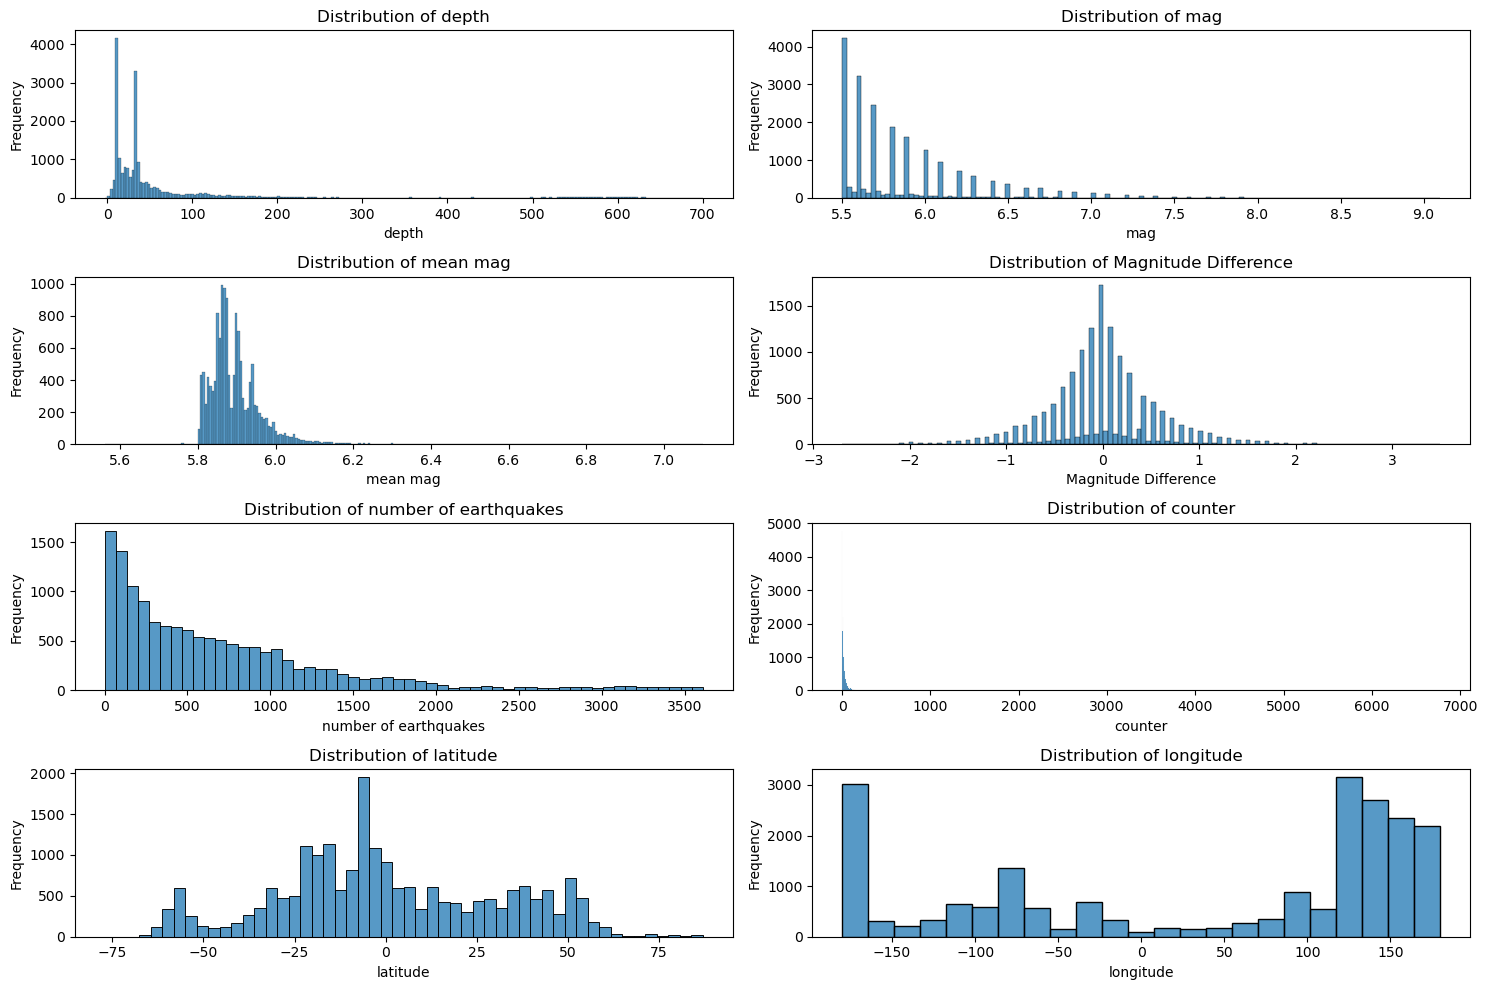

In [49]:
# Create a figure with a 2x3 grid of subplots
fig, axs = plt.subplots(4, 2, figsize=(15, 10))

# List of features to plot
features = ['depth', 'mag', 'mean mag', 'Magnitude Difference', 'number of earthquakes', 'counter', "latitude", "longitude"]

# Iterate through the grid and plot each feature
for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    sns.histplot(train_df_sorted[feature], kde=False, ax=axs[row, col])
    axs[row, col].set_title(f'Distribution of {feature}')
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [50]:
# List of features we want to describe
features = ['depth', 'mag', 'mean mag', 'Magnitude Difference', 'number of earthquakes', 'counter']

# Use describe() to get descriptive statistics for the selected features
description = train_df_sorted[features].describe()

# Print the description
print(description)

              depth           mag      mean mag  Magnitude Difference  \
count  21258.000000  21259.000000  14445.000000          14445.000000   
mean      74.176053      5.868092      5.897285              0.005846   
std      126.474892      0.407920      0.075734              0.554508   
min       -3.000000      5.500000      5.560000             -2.700000   
25%       15.000000      5.600000      5.853754             -0.300000   
50%       33.000000      5.700000      5.878519              0.000000   
75%       58.900000      6.000000      5.926902              0.300000   
max      700.000000      9.100000      7.100000              3.500000   

       number of earthquakes       counter  
count           14445.000000  21216.000000  
mean              707.190931     43.342572  
std               717.310194    130.020580  
min                 1.000000      1.000000  
25%               171.000000      4.000000  
50%               498.000000     12.000000  
75%               992.00000

## Final checks before splitting the data

In [51]:
print(train_df_sorted.head(10))
print("###########")
#print(test_df_sorted.head(10))
print("###########")
print(f"train shape: {train_df_sorted.shape}")
#print(f"test shape: {test_df_sorted.shape}")
print("############")
print(train_df_sorted.dtypes)
#print(test_df_sorted.dtypes)

   latitude  longitude  depth   mag                 countries      PlateName  \
0    52.112    177.594   25.0  5.88  United States of America  North America   
1       NaN        NaN    NaN   NaN                       NaN            NaN   
2       NaN        NaN    NaN   NaN                       NaN            NaN   
3    33.623    135.317   50.0  6.18                     Japan           Amur   
4   -15.356   -177.611   55.0  6.21                    France         Futuna   
5   -15.630   -172.436   25.0  5.88                     Samoa          Tonga   
6       NaN        NaN    NaN   NaN                       NaN            NaN   
7       NaN        NaN    NaN   NaN                       NaN            NaN   
8    42.753    145.152   49.0  6.04                     Japan        Okhotsk   
9       NaN        NaN    NaN   NaN                       NaN            NaN   

   year  month  day  day_of_week  day_of_week_sin  day_of_week_cos  month_sin  \
0  1962      1    1            0      

In [52]:
df = train_df_sorted.copy()

## Seperate the test set from the rest 

In [53]:
# Fidning the cutoff year for spliting the test set from the rest of the data.

total_years = train_df_sorted['year'].nunique()
# To find the unique years
total_years = train_df_sorted['year'].max() - train_df_sorted['year'].min() + 1

# Calculate the index for the cutoff year which represents the most recent 20% of the data
cutoff_year_index = int(total_years * 0.8)
# Use the cutoff index to find the actual year from the 'year' column
cutoff_year = train_df_sorted['year'].sort_values().unique()[cutoff_year_index]
print(cutoff_year)

2011


In [54]:
# Split the data into training and test sets based on the year

#test set
test_df_sorted = train_df_sorted[train_df_sorted['year'] >= 2011]
# Select the remaining data as the training set
train_df_sorted = train_df_sorted[train_df_sorted['year'] < 2011]

# Reset the index of the training dataset
test_df_sorted = test_df_sorted.reset_index(drop=True)

# Display the first few rows of the train and test dataframes
print(f"train_df_sorted head: {train_df_sorted.head()}")
print(f" test_df_sorted head: {test_df_sorted.head()}")

print(f"train_df_sorted shape is: {train_df_sorted.shape}")
print(f"test_df_sorted shape is: {test_df_sorted.shape}")

test_df_sorted.to_csv("check the test set.csv")
print(f"train_df_sorted columns are: {train_df_sorted.columns}")
print(f"test_df_sorted columns are: {test_df_sorted.columns}")

train_df_sorted head:    latitude  longitude  depth   mag                 countries      PlateName  \
0    52.112    177.594   25.0  5.88  United States of America  North America   
1       NaN        NaN    NaN   NaN                       NaN            NaN   
2       NaN        NaN    NaN   NaN                       NaN            NaN   
3    33.623    135.317   50.0  6.18                     Japan           Amur   
4   -15.356   -177.611   55.0  6.21                    France         Futuna   

   year  month  day  day_of_week  day_of_week_sin  day_of_week_cos  month_sin  \
0  1962      1    1            0         0.000000         1.000000        0.0   
1  1962      1    2            1         0.781831         0.623490        0.0   
2  1962      1    3            2         0.974928        -0.222521        0.0   
3  1962      1    4            3         0.433884        -0.900969        0.0   
4  1962      1    5            4        -0.433884        -0.900969        0.0   

   month_c

## Our test set has some missing values. Specifically:
1) 159 rows (latitude, longitude, dept, mag, countries and PlateName) which are the day gaps we have in our time serries. Later on we will use knn for those
2) 1655 rows (for mean mag, magnitide difference, number of earthquakes and counter) which are rows (previously time gaps) that we filled with time shifitng and therefore we have later on to recalculate those values
3) 200 rows for counter (159 rows caused by the day gaps and 41 rows which are the last recorded earthquakes of countries)

In [55]:
# Check the number of missing values in each column of the train df
missing_values_train = test_df_sorted.isnull().sum()
# Print the number of missing values for each column
print(missing_values_train)

latitude                  159
longitude                 159
depth                     159
mag                       159
countries                 159
PlateName                 159
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin             0
day_of_week_cos             0
month_sin                   0
month_cos                   0
mean mag                 1655
Magnitude Difference     1655
number of earthquakes    1655
date                        0
counter                   200
dtype: int64


We have 41 more missing data on the counter feature (than day gaps that we filled) because those 41 rows are earthquakes last recorded in a specific country. We will remove those rows as the next earthquake in those countries has not been recorded and we can't know the value of the feature "counter".

In [56]:
# Condition to check where 'counter' is NaN and 'latitude' is not NaN
condition = test_df_sorted['counter'].isna() & test_df_sorted['latitude'].notna()

# Count the rows meeting the condition
count_nan_counter = condition.sum()
print("Number of rows where 'counter' is NaN and 'latitude' is not NaN:", count_nan_counter)

# Print rows meeting the condition
print(test_df_sorted[condition])

Number of rows where 'counter' is NaN and 'latitude' is not NaN: 41
      latitude  longitude    depth  mag                 countries  \
2166   11.0316   -60.9005   31.750  5.9       Trinidad and Tobago   
4023   11.9367   -87.1371   17.000  6.1                 Nicaragua   
4229   25.1448    63.5694   27.110  5.6                  Pakistan   
4330   43.9315    13.3152    8.000  5.6                     Italy   
4407   35.7086    28.4965   29.590  5.9                    Greece   
4467   28.5073   -43.5932   10.000  5.5                  Portugal   
4571   21.9267   121.5692    4.000  5.6                    Taiwan   
4586   37.5794    35.9482   13.116  5.5                    Turkey   
4593   12.8061   -90.9046    9.000  5.7                 Guatemala   
4594   10.5368    93.5418   88.891  5.9                     India   
4621    5.3394   -76.6839   24.036  5.7                  Colombia   
4627    9.9367   -78.4562   33.948  5.5                    Panama   
4642   50.8131  -130.3127   10.000 

In [57]:
# Columns to fill with NaN
columns_to_fill_nan = ['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName', 'mean mag', 'Magnitude Difference', 'number of earthquakes']

# Fill specified columns with NaN for rows meeting the condition
test_df_sorted.loc[condition, columns_to_fill_nan] = pd.NA

In [58]:
# Check the number of missing values in each column of the train df
missing_values_train = test_df_sorted.isnull().sum()
# Print the number of missing values for each column
print(missing_values_train)

"""
The other columns (mean mag, mag difference, number of earthquakes) that have missing data are not really missing, we will just recompute them later when we impute the missing data, as those features are calculated from our data.
"""

latitude                  200
longitude                 200
depth                     200
mag                       200
countries                 200
PlateName                 200
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin             0
day_of_week_cos             0
month_sin                   0
month_cos                   0
mean mag                 1684
Magnitude Difference     1684
number of earthquakes    1684
date                        0
counter                   200
dtype: int64


'\nThe other columns (mean mag, mag difference, number of earthquakes) that have missing data are not really missing, we will just recompute them later when we impute the missing data, as those features are calculated from our data.\n'

In [59]:
print(test_df_sorted.head())

   latitude  longitude  depth   mag   countries      PlateName  year  month  \
0   -26.851    -63.217  592.9  5.78   Argentina  South America  2011      1   
1   -38.355    -73.326   24.0  7.20       Chile  South America  2011      1   
2   -59.791    149.897   10.0  5.60  Antarctica     Antarctica  2011      1   
3   -19.307    168.002   10.0  5.50     Vanuatu   New Hebrides  2011      1   
4   -22.260    171.631  112.2  6.10      France   New Hebrides  2011      1   

   day  day_of_week  day_of_week_sin  day_of_week_cos  month_sin  month_cos  \
0    1            5        -0.974928        -0.222521        0.0        1.0   
1    2            6        -0.781831         0.623490        0.0        1.0   
2    3            0         0.000000         1.000000        0.0        1.0   
3    4            1         0.781831         0.623490        0.0        1.0   
4    5            2         0.974928        -0.222521        0.0        1.0   

   mean mag  Magnitude Difference  number of earth

## Splitting the train_df to train and val.

## We end up witht he following:
1) Original dataset: 100%
2) Training: 75% of 80% = 60% of the original dataset
3) Validation: 25% of 80% = 20% of the original dataset
4) Testing: 20% of the original dataset

In [60]:
# Fidning the cutoff year for spliting the test set from the rest of the data.

total_years = train_df_sorted['year'].nunique()
# Calculate the index for the cutoff year which represents the most recent 75% of the data
cutoff_year_index = int(total_years * 0.75)
# Use the cutoff index to find the actual year from the 'year' column
cutoff_year = train_df_sorted['year'].sort_values().unique()[cutoff_year_index]
print(cutoff_year)

1998


In [61]:
# Split the data into training and val sets based on the year
val = train_df_sorted[train_df_sorted['year'] >= 1998]
# Select the remaining data as the training set
train = train_df_sorted[train_df_sorted['year'] < 1998]
# Reset the index of the training dataset
train = train.reset_index(drop=True)

# Reset the index of the validation dataset
val = val.reset_index(drop=True)

# Example: Display the first few rows of the train and test dataframes
print(f"train head: {train.head()}")
print(f"val head: {val.head()}")

print(f"train shape is: {train.shape}")
print(f"val shape is: {val.shape}")

val.to_csv("check the val set.csv")
print(f"train columns are: {train.columns}")
print(f"val columns are: {val.columns}")

train head:    latitude  longitude  depth   mag                 countries      PlateName  \
0    52.112    177.594   25.0  5.88  United States of America  North America   
1       NaN        NaN    NaN   NaN                       NaN            NaN   
2       NaN        NaN    NaN   NaN                       NaN            NaN   
3    33.623    135.317   50.0  6.18                     Japan           Amur   
4   -15.356   -177.611   55.0  6.21                    France         Futuna   

   year  month  day  day_of_week  day_of_week_sin  day_of_week_cos  month_sin  \
0  1962      1    1            0         0.000000         1.000000        0.0   
1  1962      1    2            1         0.781831         0.623490        0.0   
2  1962      1    3            2         0.974928        -0.222521        0.0   
3  1962      1    4            3         0.433884        -0.900969        0.0   
4  1962      1    5            4        -0.433884        -0.900969        0.0   

   month_cos  mean m

In [62]:
# Check for missing values in all columns
missing_values = val.isnull().sum()
print("Missing values in each column of val set:")
print(missing_values)

Missing values in each column of val set:
latitude                   79
longitude                  79
depth                      79
mag                        79
countries                  79
PlateName                  79
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin             0
day_of_week_cos             0
month_sin                   0
month_cos                   0
mean mag                 1527
Magnitude Difference     1527
number of earthquakes    1527
date                        0
counter                    80
dtype: int64


In [63]:
# Check for missing values in all columns
missing_values = train.isnull().sum()
print("Missing train in each column of val set:")
print(missing_values)

Missing train in each column of val set:
latitude                 1147
longitude                1147
depth                    1148
mag                      1147
countries                1147
PlateName                1147
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin             0
day_of_week_cos             0
month_sin                   0
month_cos                   0
mean mag                 5017
Magnitude Difference     5017
number of earthquakes    5017
date                        0
counter                  1148
dtype: int64


As we did for the test set we will make the last recorded earthquake of each country a NaN row as we dont have the record of the feature "counter" for those countries.

In [64]:
# Condition to check where 'counter' is NaN and 'latitude' is not NaN
condition = train['counter'].isna() & train['latitude'].notna()

# Count the rows meeting the condition
count_nan_counter = condition.sum()
print("Number of rows where 'counter' is NaN and 'latitude' is not NaN:", count_nan_counter)

# Print rows meeting the condition
print(train[condition])

# Columns to fill with NaN
columns_to_fill_nan = ['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName', 'mean mag', 'Magnitude Difference', 'number of earthquakes']

# Fill specified columns with NaN for rows meeting the condition
train.loc[condition, columns_to_fill_nan] = pd.NA

Number of rows where 'counter' is NaN and 'latitude' is not NaN: 1
      latitude  longitude  depth  mag countries PlateName  year  month  day  \
7736    -3.471    177.628   33.0  5.8  Kiribati   Pacific  1983      3    8   

      day_of_week  day_of_week_sin  day_of_week_cos  month_sin  month_cos  \
7736            1         0.781831          0.62349   0.866025        0.5   

      mean mag  Magnitude Difference  number of earthquakes       date  \
7736  5.646154                   0.0                   13.0 1983-03-08   

      counter  
7736      NaN  


In [65]:
# Condition to check where 'counter' is NaN and 'latitude' is not NaN
condition = val['counter'].isna() & val['latitude'].notna()

# Count the rows meeting the condition
count_nan_counter = condition.sum()
print("Number of rows where 'counter' is NaN and 'latitude' is not NaN:", count_nan_counter)

# Optional: print rows meeting the condition
print(val[condition])

# Columns to fill with NaN
columns_to_fill_nan = ['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName', 'mean mag', 'Magnitude Difference', 'number of earthquakes']

# Fill specified columns with NaN for rows meeting the condition
val.loc[condition, columns_to_fill_nan] = pd.NA

Number of rows where 'counter' is NaN and 'latitude' is not NaN: 1
      latitude  longitude  depth  mag countries PlateName  year  month  day  \
2823    12.471     40.634   11.8  5.5  Ethiopia    Arabia  2005      9   24   

      day_of_week  day_of_week_sin  day_of_week_cos  month_sin  month_cos  \
2823            5        -0.974928        -0.222521  -0.866025       -0.5   

      mean mag  Magnitude Difference  number of earthquakes       date  \
2823  5.890526                   0.0                   19.0 2005-09-24   

      counter  
2823      NaN  


In [66]:
# Check for missing values in all columns
missing_values = train.isnull().sum()
print("Missing train in each column of val set:")
print(missing_values)

# Check for missing values in all columns
missing_values = val.isnull().sum()
print("Missing val in each column of val set:")
print(missing_values)

"""
train: 8% missing data
val: 1% missing data
"""

Missing train in each column of val set:
latitude                 1148
longitude                1148
depth                    1149
mag                      1148
countries                1148
PlateName                1148
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin             0
day_of_week_cos             0
month_sin                   0
month_cos                   0
mean mag                 5018
Magnitude Difference     5018
number of earthquakes    5018
date                        0
counter                  1148
dtype: int64
Missing val in each column of val set:
latitude                   80
longitude                  80
depth                      80
mag                        80
countries                  80
PlateName                  80
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin             0
day_of_

'\ntrain: 8% missing data\nval: 1% missing data\n'

In [67]:
# Numeric features for standardization
numeric_features = [ 'depth', "mag", "year", "month", "day", 'day_of_week', 'day_of_week_sin', 'day_of_week_cos', 
                    'month_sin','month_cos', 'mean mag', 'Magnitude Difference', 'number of earthquakes']

# List of features to check distribution
features_to_check = ['latitude', 'longitude', 'depth', "counter", "Magnitude Difference", "number of earthquakes", "mean mag"]


In [68]:
print(train.columns)

Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter'],
      dtype='object')


# Feature Transformation
We will clip, log transform and standardize properly our features

In [69]:
def cap_and_log_transform(df, feature_name):
    if feature_name == "depth":
        IQR = df['depth'].quantile(0.75) - df['depth'].quantile(0.25)
        upper_bound = df['depth'].quantile(0.75) + 1.5 * IQR
        df['depth'] = df['depth'].clip(lower=0, upper=upper_bound)
    
    elif feature_name == "counter":
        upper_bound = df['counter'].quantile(0.90)
        df['counter'] = df['counter'].clip(upper=upper_bound)

    elif feature_name == "mag":
        upper_bound = df['mag'].quantile(0.99)
        df['mag'] = df['mag'].clip(upper=upper_bound)

    transformed_series = np.log1p(df[feature_name])
    return transformed_series

In [70]:
numeric_features = [ 'depth', "mag", "year", "month", "day", 'day_of_week', 'day_of_week_sin', 'day_of_week_cos', 
                    'month_sin','month_cos', 'mean mag', 'Magnitude Difference', 'number of earthquakes']

# cap and log transform the numeric features
# features for cap and log
features_for_cap_and_log = [ 'depth', 'mag']
for feature in features_for_cap_and_log:
    train[feature] = cap_and_log_transform(train, feature)
    val[feature] = cap_and_log_transform(val, feature)


# After the imputation of missing data we will update the columns counter, mean mag, magnitude difference and number of earthquakes and then standardize them as well
# month_sin and month_cos... which already encode the cyclical nature in a bounded range (typically -1 to 1), additional scaling wont be necessary

# List of features to be standardized excluding latitude and longitude. We will first impute the missing data of latitude/longitude and then standarize them.
numeric_features_to_standardize = ['depth', "mag", "year", "month", "day", 'day_of_week']


# Initialize a dictionary to hold the scalers for each feature
scalers = {feature: StandardScaler() for feature in numeric_features_to_standardize}

# Fit and transform each feature separately for the training data
for feature in numeric_features_to_standardize:
    train[feature] = scalers[feature].fit_transform(train[[feature]])

# Transform each feature separately for the validation data using the fitted scalers
for feature in numeric_features_to_standardize:
    val[feature] = scalers[feature].transform(val[[feature]])

In [71]:
# check that everything is okay
print(train.head(10))
print("###########")
print(val.head(10))
print("###########")
print(f"train shape: {train.shape}")
print(f"test shape: {val.shape}")
print("############")
print(train.dtypes)
print(val.dtypes)


   latitude  longitude     depth       mag                 countries  \
0    52.112    177.594 -0.469894  0.061066  United States of America   
1       NaN        NaN       NaN       NaN                       NaN   
2       NaN        NaN       NaN       NaN                       NaN   
3    33.623    135.317  0.410154  0.832517                     Japan   
4   -15.356   -177.611  0.532321  0.907882                    France   
5   -15.630   -172.436 -0.469894  0.061066                     Samoa   
6       NaN        NaN       NaN       NaN                       NaN   
7       NaN        NaN       NaN       NaN                       NaN   
8    42.753    145.152  0.384287  0.476600                     Japan   
9       NaN        NaN       NaN       NaN                       NaN   

       PlateName      year     month       day  day_of_week  day_of_week_sin  \
0  North America -1.684627 -1.601451 -1.673805    -1.499743         0.000000   
1            NaN -1.684627 -1.601451 -1.560170 

##  Imputting the missing data of latitude and longitude in train and val.
To do that, we will use knn and specifically we will use the haversine function of distance. The Haversine distance is a formula used to calculate the distance between two points on a sphere (such as the Earth) given their latitude and longitude coordinates. We have to emphasize that we can't use Euclidean distance calculations for latitude and longitude as Euclidian distance assumes a flat surface

In [72]:
# Define the haversine distance function
def haversine_distance(latlon1, latlon2):
    # Unpack latitude/longitude
    lat1, lon1 = latlon1[:, 0], latlon1[:, 1]
    lat2, lon2 = latlon2[:, 0], latlon2[:, 1]
    
    # Initialize an array to hold distances
    dist = np.zeros((latlon1.shape[0], 1), dtype=float)
    
    # Compute haversine distance for each set of points
    for i in range(latlon1.shape[0]):
        dist[i] = haversine((lat1[i], lon1[i]), (lat2[i], lon2[i]), unit=Unit.KILOMETERS)
    
    return dist

# Separate out rows that have complete geospatial data
complete_cases = train.dropna(subset=['latitude', 'longitude'])

print(complete_cases.head(15))

    latitude  longitude     depth       mag                 countries  \
0     52.112    177.594 -0.469894  0.061066  United States of America   
3     33.623    135.317  0.410154  0.832517                     Japan   
4    -15.356   -177.611  0.532321  0.907882                    France   
5    -15.630   -172.436 -0.469894  0.061066                     Samoa   
8     42.753    145.152  0.384287  0.476600                     Japan   
18    38.503     22.102 -0.469894 -0.607958                    Greece   
25    35.191     22.769 -0.469894  0.270027                    Greece   
27   -17.104   -171.932 -0.872747  0.629995                     Tonga   
31   -31.642   -177.151 -1.104081 -0.607958               New Zealand   
33    -1.311    137.474 -0.574448  1.156852                 Indonesia   
34    -0.680    -20.152 -1.104081  0.321892            United Kingdom   
38    -3.117    141.265 -0.044816  0.450907          Papua New Guinea   
44   -37.845    -72.885 -0.240140  3.011717        

In [73]:
# Find the index of rows with missing geospatial data
missing_geo_index = train[train['latitude'].isna() | train['longitude'].isna()].index

# Randomly sample non-missing coordinates for latitude and longitude
random_sample = complete_cases.sample(len(missing_geo_index), random_state=42)
print(random_sample.head())
# Temporarily fill missing values
train.loc[missing_geo_index, 'latitude'] = random_sample["latitude"].values
train.loc[missing_geo_index, 'longitude'] = random_sample["longitude"].values


# Instantiate the KNN regressor with haversine distance
knn = KNeighborsRegressor(n_neighbors=3, metric='haversine')

# Fit the KNN regressor on the non-missing data
# Convert degrees to radians for haversine distance calculation
knn.fit(np.radians(complete_cases[['latitude', 'longitude']]), complete_cases[['latitude', 'longitude']])

# Now apply KNN
imputed_values = knn.predict(np.radians(train.loc[missing_geo_index, ['latitude', 'longitude']]))
train.loc[missing_geo_index, ['latitude', 'longitude']] = imputed_values

       latitude  longitude     depth       mag    countries      PlateName  \
2801    -27.786    -66.573  1.558115 -0.499236    Argentina  South America   
4093     13.372    122.787 -0.119478  2.787181  Philippines          Sunda   
11379   -23.996   -177.218  1.558115 -0.418122        Tonga          Tonga   
6572      0.964    125.990  0.156541 -0.150340    Indonesia          Sunda   
576     -29.776   -176.963 -0.748872 -0.662565  New Zealand       Kermadec   

           year     month       day  day_of_week  day_of_week_sin  \
2801  -1.010789  0.718261 -1.560170    -0.999753         0.781831   
4093  -0.625739 -1.021523  0.144358     1.000209        -0.974928   
11379  1.299511 -1.311487  1.167074     0.500219        -0.433884   
6572  -0.048164  1.588154  1.621615     1.500200        -0.781831   
576   -1.588364  0.138333  1.735250    -0.499762         0.974928   

       day_of_week_cos     month_sin  month_cos  mean mag  \
2801          0.623490 -8.660254e-01  -0.500000  5.9900

In [74]:
# check that everything is okay
print(train.head(10))
print("###########")
print(val.head(10))
print("###########")
print(f"train shape: {train.shape}")
print(f"test shape: {val.shape}")
print("############")
print(train.dtypes)
print(val.dtypes)


    latitude   longitude     depth       mag                 countries  \
0  52.112000  177.594000 -0.469894  0.061066  United States of America   
1 -27.795000  -66.655667       NaN       NaN                       NaN   
2  13.314667  122.829667       NaN       NaN                       NaN   
3  33.623000  135.317000  0.410154  0.832517                     Japan   
4 -15.356000 -177.611000  0.532321  0.907882                    France   
5 -15.630000 -172.436000 -0.469894  0.061066                     Samoa   
6 -23.952000 -177.243667       NaN       NaN                       NaN   
7   0.997000  126.048667       NaN       NaN                       NaN   
8  42.753000  145.152000  0.384287  0.476600                     Japan   
9 -29.772333 -176.971000       NaN       NaN                       NaN   

       PlateName      year     month       day  day_of_week  day_of_week_sin  \
0  North America -1.684627 -1.601451 -1.673805    -1.499743         0.000000   
1            NaN -1.68462

In [75]:
# Check for missing values in all columns
missing_values = train.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
latitude                    0
longitude                   0
depth                    1149
mag                      1148
countries                1148
PlateName                1148
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin             0
day_of_week_cos             0
month_sin                   0
month_cos                   0
mean mag                 5018
Magnitude Difference     5018
number of earthquakes    5018
date                        0
counter                  1148
dtype: int64


validation set

In [76]:
# do the same for the val set

# Find the index of rows with missing geospatial data in the validation dataset
missing_geo_index_val = val[val['latitude'].isna() | val['longitude'].isna()].index

random_sample_val = complete_cases.sample(len(missing_geo_index_val), random_state=42)
val.loc[missing_geo_index_val, 'latitude'] = random_sample_val["latitude"].values
val.loc[missing_geo_index_val, 'longitude'] = random_sample_val["longitude"].values

# Apply the KNN model to impute missing latitude and longitude in the validation dataset
# Convert degrees to radians for haversine distance calculation
imputed_values_val = knn.predict(np.radians(val.loc[missing_geo_index_val, ['latitude', 'longitude']]))

# Replace the missing values with the imputed values
val.loc[missing_geo_index_val, ['latitude', 'longitude']] = imputed_values_val

# Print for checking results
print(val.head(10))

   latitude  longitude     depth       mag                 countries  \
0    -6.338    154.870  0.309010  0.113533          Papua New Guinea   
1    51.310    178.802 -0.119478 -0.689930  United States of America   
2    54.224   -164.177 -1.593518 -0.150340  United States of America   
3   -22.301    170.911  1.310434  3.669060                    France   
4    23.913    141.907  1.244515  1.132109                     Japan   
5    54.224   -164.177 -1.593518 -0.150340  United States of America   
6    37.264     20.793 -0.119478 -0.965889                    Greece   
7    14.374    -91.473 -0.119478  1.860057                 Guatemala   
8   -14.525    166.771 -0.119478 -0.689930                   Vanuatu   
9    37.264     20.793 -0.119478 -0.965889                    Greece   

        PlateName      year     month       day  day_of_week  day_of_week_sin  \
0         Pacific  1.780823 -1.601451 -1.673805     0.000228         0.433884   
1   North America  1.780823 -1.601451 -1.5601

## impute the missing values of depth and mag with knn
Here we will use the default distance function

In [77]:
def perform_knn_imputation(train, val, features_to_impute):
    # Identify indices with missing values for depth and mag
    missing_features_index = train[train['depth'].isna() | train['mag'].isna()].index
    
    # Separate out rows that have complete data
    complete_cases = train.dropna(subset=['depth', 'mag'])
    
    # Randomly sample non-missing depth and mag values
    random_sample = complete_cases.sample(len(missing_features_index), random_state=42)
    
    # Temporarily fill missing values
    train.loc[missing_features_index, 'depth'] = random_sample["depth"].values
    train.loc[missing_features_index, 'mag'] = random_sample["mag"].values
    
    # Create KNNImputer 
    imputer = KNNImputer(n_neighbors=3)
    
    # Concatenate features to impute with additional features
    features = features_to_impute
    
    # Impute the training data
    train[features] = imputer.fit_transform(train[features])
    
    # Impute the validation data using the same imputer fitted on the training data
    val[features_to_impute] = imputer.transform(val[features])
    
    return train, val

to_impute = ["depth", "mag"]
train, val = perform_knn_imputation(train, val, to_impute)

In [78]:

# check that everything is okay
print(train.head(10))
print("###########")
print(val.head(10))
print("###########")
print(f"train shape: {train.shape}")
print(f"test shape: {val.shape}")
print("############")
print(train.dtypes)
print(val.dtypes)
train.to_csv("are the knn imputation the same value.csv")

    latitude   longitude     depth       mag                 countries  \
0  52.112000  177.594000 -0.469894  0.061066  United States of America   
1 -27.795000  -66.655667 -0.748872  1.206237                       NaN   
2  13.314667  122.829667 -0.198668  0.882795                       NaN   
3  33.623000  135.317000  0.410154  0.832517                     Japan   
4 -15.356000 -177.611000  0.532321  0.907882                    France   
5 -15.630000 -172.436000 -0.469894  0.061066                     Samoa   
6 -23.952000 -177.243667  0.644033  0.191949                       NaN   
7   0.997000  126.048667 -1.593518 -0.150340                       NaN   
8  42.753000  145.152000  0.384287  0.476600                     Japan   
9 -29.772333 -176.971000 -0.748872 -0.662565                       NaN   

       PlateName      year     month       day  day_of_week  day_of_week_sin  \
0  North America -1.684627 -1.601451 -1.673805    -1.499743         0.000000   
1            NaN -1.68462

## mapping the coordinates that we imputed earlier with a country and a tectonic plate

In [79]:
# Function to find the nearest country
def find_nearest_country(point, countries_gdf):
    min_dist = np.inf
    nearest_country = None
    for _, country in countries_gdf.iterrows():
        if country['geometry'].contains(point):
            return country['SOVEREIGNT']
        dist = point.distance(country['geometry'])
        if dist < min_dist:
            min_dist = dist
            nearest_country = country['SOVEREIGNT']
    return nearest_country

# Function to find the nearest tectonic plate
def find_nearest_plate(point, plates_gdf):
    min_dist = np.inf
    nearest_plate = None
    for _, plate in plates_gdf.iterrows():
        if plate['geometry'].contains(point):
            return plate['PlateName']
        dist = point.distance(plate['geometry'])
        if dist < min_dist:
            min_dist = dist
            nearest_plate = plate['PlateName']
    return nearest_plate


# Load the GeoJSON files for countries and tectonic plates
gdf_countries = gpd.read_file('C:/Users/Harrys/Desktop/Thesis/states and countries/ne_10m_admin_0_countries.geojson')
gdf_plates = gpd.read_file('C:/Users/Harrys/Desktop/Thesis/plates mapping/PB2002_plates.json')


In [80]:
# Identify the rows with NaN in "countries"
missing_counter_train  = train['countries'].isna()
missing_counter_val  = val['countries'].isna()


# Create GeoDataFrames from filtered data
geo_train = gpd.GeoDataFrame(train.loc[missing_counter_train], 
                             geometry=gpd.points_from_xy(train.loc[missing_counter_train, 'longitude'], train.loc[missing_counter_train, 'latitude']), 
                             crs="EPSG:4326")
geo_val = gpd.GeoDataFrame(val.loc[missing_counter_val], 
                           geometry=gpd.points_from_xy(val.loc[missing_counter_val, 'longitude'], val.loc[missing_counter_val, 'latitude']), 
                           crs="EPSG:4326")


# Perform the mapping using the apply function
geo_train['countries'] = geo_train.geometry.apply(lambda x: find_nearest_country(x, gdf_countries))
geo_train['PlateName'] = geo_train.geometry.apply(lambda x: find_nearest_plate(x, gdf_plates))
geo_val['countries'] = geo_val.geometry.apply(lambda x: find_nearest_country(x, gdf_countries))
geo_val['PlateName'] = geo_val.geometry.apply(lambda x: find_nearest_plate(x, gdf_plates))

# Update the original dataframes
train.update(geo_train[['countries', 'PlateName']])
val.update(geo_val[['countries', 'PlateName']])

In [81]:
# Check for missing values in all columns
missing_values = train.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
latitude                    0
longitude                   0
depth                       0
mag                         0
countries                   0
PlateName                   0
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin             0
day_of_week_cos             0
month_sin                   0
month_cos                   0
mean mag                 5018
Magnitude Difference     5018
number of earthquakes    5018
date                        0
counter                  1148
dtype: int64


In [82]:

# Check for missing values in all columns
missing_values = val.isnull().sum()
print("Missing values in each column of val set:")
print(missing_values)

Missing values in each column of val set:
latitude                    0
longitude                   0
depth                       0
mag                         0
countries                   0
PlateName                   0
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin             0
day_of_week_cos             0
month_sin                   0
month_cos                   0
mean mag                 1528
Magnitude Difference     1528
number of earthquakes    1528
date                        0
counter                    80
dtype: int64


## scaling the features latitude and longitude

In [83]:
# Instantiate separate scalers for each feature
latitude_scale = StandardScaler()
longitude_scale = StandardScaler()

# Fit and transform the 'latitude' feature on the training data
train['latitude'] = latitude_scale.fit_transform(train[['latitude']])

# Transform the 'latitude' feature on the validation data
val['latitude'] = latitude_scale.transform(val[['latitude']])

# Fit and transform the 'longitude' feature on the training data
train['longitude'] = longitude_scale.fit_transform(train[['longitude']])

# Transform the 'longitude' feature on the validation data
val['longitude'] = longitude_scale.transform(val[['longitude']])

# View the first few rows to verify the scaling
print(train[['latitude', 'longitude']].head())
print(val[['latitude', 'longitude']].head())

   latitude  longitude
0  1.648084   1.065922
1 -0.989956  -0.842723
2  0.367234   0.637976
3  1.037691   0.735556
4 -0.579297  -1.709764
   latitude  longitude
0 -0.281577   0.888349
1  1.621607   1.075362
2  1.717810  -1.604786
3 -0.808578   1.013699
4  0.717126   0.787052


In [84]:
# check that everything is okay
print(train.head(10))
print("###########")
print(val.head(10))
print("###########")
print(f"train shape: {train.shape}")
print(f"test shape: {val.shape}")
print("############")
print(train.dtypes)
print(val.dtypes)
train.to_csv("train_completly_imputed_values_knn.csv")
val.to_csv("val_completly_imputed_values_knn.csv")


   latitude  longitude     depth       mag                 countries  \
0  1.648084   1.065922 -0.469894  0.061066  United States of America   
1 -0.989956  -0.842723 -0.748872  1.206237                 Argentina   
2  0.367234   0.637976 -0.198668  0.882795               Philippines   
3  1.037691   0.735556  0.410154  0.832517                     Japan   
4 -0.579297  -1.709764  0.532321  0.907882                    France   
5 -0.588342  -1.669325 -0.469894  0.061066                     Samoa   
6 -0.863084  -1.706893  0.644033  0.191949                     Tonga   
7 -0.039421   0.663130 -1.593518 -0.150340                 Indonesia   
8  1.339107   0.812410  0.384287  0.476600                     Japan   
9 -1.055236  -1.704763 -0.748872 -0.662565               New Zealand   

       PlateName      year     month       day  day_of_week  day_of_week_sin  \
0  North America -1.684627 -1.601451 -1.673805    -1.499743         0.000000   
1  South America -1.684627 -1.601451 -1.560170 

## Update also the columns "mean mag", "Magnitude Difference", "number of earthquakes", "counter as they are derived from the data. Then scale them as well


In [85]:
# Extract mean and scale for 'mag'
mag_mean = scalers['mag'].mean_[0]  # the mean of 'mag'
mag_scale = scalers['mag'].scale_[0]  # the scale of 'mag'

# Function to calculate new features after reversing transformations
def calculate_new_features(df, mean, scale):
    # Manually reverse transformations for 'mag' 
    df['mag_original'] = np.expm1(df['mag'] * scale + mean)
    
    # Calculate new features based on 'mag_original'
    df['mean mag'] = df.groupby('countries')['mag_original'].expanding().mean().reset_index(level=0, drop=True)
    df['prev_mag'] = df.groupby('countries')['mag_original'].shift(1)
    df['Magnitude Difference'] = df['mag_original'] - df['prev_mag']
    df['Magnitude Difference'].fillna(0, inplace=True)
    df['number of earthquakes'] = df.groupby('countries').cumcount() + 1
    
    # Calculate the number of days until the next earthquake
    df['next_date'] = df.groupby('countries')['date'].shift(-1)
    df['counter'] = (df['next_date'] - df['date']).dt.days
    df['counter'].fillna(0, inplace=True)  # Fill NaN if no next date is available

    # Drop temporary columns
    df.drop(['prev_mag', 'mag_original', 'next_date'], axis=1, inplace=True)
    
    return df

# Apply the function using the manually specified mean and scale
train = calculate_new_features(train, mag_mean, mag_scale)
val = calculate_new_features(val, mag_mean, mag_scale)

#check if the new features are corect
train.to_csv("check of new_features function.csv")

# Define the features to be scaled separately
features_to_scale_separately = ['mean mag', 'Magnitude Difference', 'number of earthquakes']

# Initialize a dictionary to hold the scalers for each feature
individual_scalers = {feature: StandardScaler() for feature in features_to_scale_separately}

# Fit and transform each feature separately for the training data
for feature in features_to_scale_separately:
    train[feature] = individual_scalers[feature].fit_transform(train[[feature]])

# Transform each feature separately for the validation data using the fitted scalers
for feature in features_to_scale_separately:
    val[feature] = individual_scalers[feature].transform(val[[feature]])


In [86]:
# check that everything is okay
print(train.head(10))
print("###########")
print(val.head(10))
print("###########")
print(f"train shape: {train.shape}")
print(f"test shape: {val.shape}")
print("############")
print(train.dtypes)
print(val.dtypes)


   latitude  longitude     depth       mag                 countries  \
0  1.648084   1.065922 -0.469894  0.061066  United States of America   
1 -0.989956  -0.842723 -0.748872  1.206237                 Argentina   
2  0.367234   0.637976 -0.198668  0.882795               Philippines   
3  1.037691   0.735556  0.410154  0.832517                     Japan   
4 -0.579297  -1.709764  0.532321  0.907882                    France   
5 -0.588342  -1.669325 -0.469894  0.061066                     Samoa   
6 -0.863084  -1.706893  0.644033  0.191949                     Tonga   
7 -0.039421   0.663130 -1.593518 -0.150340                 Indonesia   
8  1.339107   0.812410  0.384287  0.476600                     Japan   
9 -1.055236  -1.704763 -0.748872 -0.662565               New Zealand   

       PlateName      year     month       day  day_of_week  day_of_week_sin  \
0  North America -1.684627 -1.601451 -1.673805    -1.499743         0.000000   
1  South America -1.684627 -1.601451 -1.560170 

In [87]:
train.to_csv("train_before_semivariogram.csv")
val.to_csv("val_before_semivariogram.csv")

In [88]:
""" train = pd.read_csv("train_before_semivariogram.csv")
val = pd.read_csv("val_before_semivariogram.csv") """

' train = pd.read_csv("train_before_semivariogram.csv")\nval = pd.read_csv("val_before_semivariogram.csv") '

## Semivarigoram Analysis

reverting the features to their original values so we can have their real correlation

In [89]:
# Create Temporary DataFrames with Reverted Latitude and Longitude

# Create temporary dataframes for semivariogram analysis
temp_train = train.copy()
temp_val = val.copy()

# Function to revert standardization
def revert_standardization(df, features, scalers):
    for feature, scaler in zip(features, scalers):
        df[feature] = scaler.inverse_transform(df[[feature]])
    return df

# Reverting transformations for latitude and longitude
temp_train = revert_standardization(temp_train, ['latitude', 'longitude'], [latitude_scale, longitude_scale])
temp_val = revert_standardization(temp_val, ['latitude', 'longitude'], [latitude_scale, longitude_scale])


In [90]:
# revert also the depth mag features

# Function to revert standardization and log transformation
def revert_transformations(df, feature_name, scaler):
    # Inverse transform standardization
    df[feature_name] = scaler.inverse_transform(df[[feature_name]])
    # Inverse log transformation
    df[feature_name] = np.expm1(df[feature_name])
    return df[feature_name]

# Reverting transformations for depth and mag
features_to_revert = ['depth', 'mag']
for feature in features_to_revert:
    revert_transformations(temp_train, feature, scalers[feature])
    revert_transformations(temp_val, feature, scalers[feature])

In [91]:
print(temp_train.columns)

Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter'],
      dtype='object')


In [92]:
temp_train.to_csv("temp_train_before_krigging.csv")

In [93]:
temp_train.describe()

latitude     longitude         depth           mag          year  \
count  13149.000000  13149.000000  1.314900e+04  13149.000000  1.314900e+04   
mean       2.191058     41.187779  4.825011e+01      5.867097 -4.841785e-15   
std       30.291435    127.975054  3.697892e+01      0.394779  1.000038e+00   
min      -72.448000   -179.997000  4.440892e-16      5.500000 -1.684627e+00   
25%      -17.889000    -77.501000  2.250000e+01      5.600000 -8.182642e-01   
50%       -3.904000    120.706000  3.300000e+01      5.710000  4.809830e-02   
75%       27.462000    146.861000  6.280000e+01      6.000000  8.181983e-01   
max       86.681000    179.992000  1.218125e+02      7.300000  1.684561e+00   

              month           day   day_of_week  day_of_week_sin  \
count  1.314900e+04  1.314900e+04  1.314900e+04     13149.000000   
mean  -1.123986e-16  4.755324e-17  1.034317e-16         0.000134   
std    1.000038e+00  1.000038e+00  1.000038e+00         0.707137   
min   -1.601451e+00 -1.673805e+00 -1.499743e+00        -0.974928   
25%   -7.315589e-01 -8.783587e-01 -9.997529e-01        -0.781831   
50%    1.383333e-01  3.072272e-02  2.281499e-04         0.000000   
75%    1.008226e+00  8.261689e-01  1.000209e+00         0.781831   
max    1.588154e+00  1.735250e+00  1.500200e+00         0.974928   

       day_of_week_cos     month_sin     month_cos      mean mag  \
count     13149.000000  13149.000000  1.314900e+04  1.314900e+04   
mean          0.000107     -0.003129 -4.149335e-03  6.484533e-15   
std           0.707130      0.707006  7.072425e-01  1.000038e+00   
min          -0.900969     -1.000000 -1.000000e+00 -5.197452e+00   
25%          -0.900969     -0.500000 -8.660254e-01 -6.892059e-01   
50%          -0.222521      0.000000 -1.836970e-16 -1.733197e-01   
75%           0.623490      0.866025  5.000000e-01  4.876139e-01   
max           1.000000      1.000000  1.000000e+00  1.359377e+01   

       Magnitude Difference  number of earthquakes       counter  
count          1.314900e+04           13149.000000  13149.000000  
mean          -1.486039e-17               0.000000     41.004715  
std            1.000038e+00               1.000038    133.954004  
min           -3.330162e+00              -1.010278      0.000000  
25%           -5.364198e-01              -0.759071      4.000000  
50%            1.266366e-04              -0.297615     12.000000  
75%            5.181715e-01               0.401395     35.000000  
max            3.330415e+00               3.926480   6773.000000

Krigging method

In [94]:
""" import geopandas as gpd
from pykrige.uk import UniversalKriging
from shapely.ops import nearest_points
from geopandas.tools import sjoin

# Load tectonic plates data
gdf_plates = gpd.read_file('C:/Users/Harrys/Desktop/Thesis/plates mapping/PB2002_plates.json')

# Convert temp_train to a GeoDataFrame
temp_train['geometry'] = gpd.points_from_xy(temp_train.longitude, temp_train.latitude)
gdf_earthquakes = gpd.GeoDataFrame(temp_train, geometry='geometry', crs=gdf_plates.crs)

relevant_plates = gdf_plates[gdf_plates['PlateName'].isin(temp_train['PlateName'].unique())]

# Convert plate boundaries into a linestring if they are not already.
gdf_plates['geometry'] = gdf_plates.geometry.apply(lambda x: x.boundary)

# Create a spatial index for the plates for quicker lookup
gdf_plates.sindex

def calculate_optimized_distance(earthquake_point, plate_boundaries):
    # Use the nearest_points function from Shapely which is more efficient
    nearest_geom = nearest_points(earthquake_point, plate_boundaries.unary_union)[1]
    return earthquake_point.distance(nearest_geom)

# Apply optimized distance function
gdf_earthquakes['distance_to_boundary'] = gdf_earthquakes.geometry.apply(
    lambda x: calculate_optimized_distance(x, relevant_plates)
)

# Extract coordinates and values for kriging
coordinates = np.array(list(zip(gdf_earthquakes.geometry.x, gdf_earthquakes.geometry.y)))
values = gdf_earthquakes['mag'].values
external_drift = gdf_earthquakes['distance_to_boundary'].values

# Set up Universal Kriging with the external drift
UK = UniversalKriging(
    coordinates[:, 0], coordinates[:, 1], values,
    variogram_model='spherical',  # Choose the model based on our data specifics
    drift_terms=['external'],
    external_drift=external_drift[:, np.newaxis]  # Convert to 2D for compatibility
)

# Define grid points for prediction over our area of interest
grid_x = np.linspace(-180, 180, 12)  # Longitude
grid_y = np.linspace(-73, 87, 6)    # Latitude
grid_x, grid_y = np.meshgrid(grid_x, grid_y)

# Execute kriging over the defined grid
z, ss = UK.execute('grid', grid_x, grid_y) """

" import geopandas as gpd\nfrom pykrige.uk import UniversalKriging\nfrom shapely.ops import nearest_points\nfrom geopandas.tools import sjoin\n\n# Load tectonic plates data\ngdf_plates = gpd.read_file('C:/Users/Harrys/Desktop/Thesis/plates mapping/PB2002_plates.json')\n\n# Convert temp_train to a GeoDataFrame\ntemp_train['geometry'] = gpd.points_from_xy(temp_train.longitude, temp_train.latitude)\ngdf_earthquakes = gpd.GeoDataFrame(temp_train, geometry='geometry', crs=gdf_plates.crs)\n\nrelevant_plates = gdf_plates[gdf_plates['PlateName'].isin(temp_train['PlateName'].unique())]\n\n# Convert plate boundaries into a linestring if they are not already.\ngdf_plates['geometry'] = gdf_plates.geometry.apply(lambda x: x.boundary)\n\n# Create a spatial index for the plates for quicker lookup\ngdf_plates.sindex\n\ndef calculate_optimized_distance(earthquake_point, plate_boundaries):\n    # Use the nearest_points function from Shapely which is more efficient\n    nearest_geom = nearest_points(eart

In [95]:
""" import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.contourf(grid_x, grid_y, z, cmap='viridis')
plt.colorbar(label='Predicted Magnitude')
plt.title('Kriging Prediction with External Drift of Tectonic Plate Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show() """

" import matplotlib.pyplot as plt\n\nplt.figure(figsize=(10, 8))\nplt.contourf(grid_x, grid_y, z, cmap='viridis')\nplt.colorbar(label='Predicted Magnitude')\nplt.title('Kriging Prediction with External Drift of Tectonic Plate Boundaries')\nplt.xlabel('Longitude')\nplt.ylabel('Latitude')\nplt.show() "

calculating dynamic global semivariogram parameters. To calculate dynamic semivariogram parameters we will calculate the semivariogram params for every year

In [96]:
""" # This is CORRECT but the group year month is better

# Features of interest for semivariogram analysis
features_of_interest = ['depth', 'mag']


def calculate_yearly_variogram_params_global(df, features):
    grouped = df.groupby('year')  # Group data by year
    yearly_params = {}

    for year, group in grouped:
        yearly_results = {}
        for feature in features:
            valid_data = group[['latitude', 'longitude', feature]].dropna()
            if len(valid_data) < 3:
                print(f"Not enough data to calculate variogram for {feature} in {year}")
                yearly_results[f'{feature}_nugget_global'] = np.nan
                yearly_results[f'{feature}_sill_global'] = np.nan
                yearly_results[f'{feature}_range_global'] = np.nan
                continue

            coordinates = valid_data[['latitude', 'longitude']].values
            values = valid_data[feature].values

            try:
                OK = OrdinaryKriging(
                    coordinates[:, 0], coordinates[:, 1], values,
                    variogram_model='spherical',
                    verbose=False,
                    enable_plotting=False
                )

                if OK.variogram_model_parameters is not None:
                    nugget, sill, range_ = OK.variogram_model_parameters
                    yearly_results[f'{feature}_nugget_global'] = nugget
                    yearly_results[f'{feature}_sill_global'] = sill + nugget
                    yearly_results[f'{feature}_range_global'] = range_
                else:
                    print(f"Failed to compute variogram parameters for {feature} in {year}")
                    yearly_results[f'{feature}_nugget_global'] = np.nan
                    yearly_results[f'{feature}_sill_global'] = np.nan
                    yearly_results[f'{feature}_range_global'] = np.nan
            except Exception as e:
                print(f"Error computing variogram for {feature} in {year}: {e}")
                yearly_results[f'{feature}_nugget_global'] = np.nan
                yearly_results[f'{feature}_sill_global'] = np.nan
                yearly_results[f'{feature}_range_global'] = np.nan

        yearly_params[year] = yearly_results

    return pd.DataFrame(yearly_params).transpose().reset_index().rename(columns={'index': 'year'})

# Computing global variogram parameters for training and validation datasets
global_params_train = calculate_yearly_variogram_params_global(temp_train, features_of_interest)
global_params_val = calculate_yearly_variogram_params_global(temp_val, features_of_interest)

# Merging global parameters into the training and validation datasets
temp_train = temp_train.merge(global_params_train, on='year', how='left')
temp_val = temp_val.merge(global_params_val, on='year', how='left')

# Function to compute interaction terms with semivariogram parameters
def compute_interactions(df, features):
    for feature in features:
        for param in ['nugget_global', 'sill_global', 'range_global']:
            param_name = f'{feature}_{param}'
            interaction_name = f'{param_name}_interaction'
            df[interaction_name] = df[feature] * df[param_name]
    return df

# Applying interaction computation
temp_train = compute_interactions(temp_train, features_of_interest)
temp_val = compute_interactions(temp_val, features_of_interest) """

In [97]:
""" #### semivariogram yearly but with saving the variograms

from pykrige.ok import OrdinaryKriging
import numpy as np
import pandas as pd
# Features of interest for semivariogram analysis
features_of_interest = ['depth', 'mag']

def calculate_yearly_variogram_params_global(df, features):
    grouped = df.groupby('year')
    yearly_params = {}
    empirical_variograms = {}  # Store empirical variograms

    for year, group in grouped:
        yearly_results = {}
        for feature in features:
            valid_data = group[['latitude', 'longitude', feature]].dropna()
            if len(valid_data) < 3:
                print(f"Not enough data to calculate variogram for {feature} in {year}")
                continue

            coordinates = valid_data[['latitude', 'longitude']].values
            values = valid_data[feature].values

            try:
                OK = OrdinaryKriging(
                    coordinates[:, 0], coordinates[:, 1], values,
                    variogram_model='spherical',
                    verbose=False,
                    enable_plotting=False
                )
                if OK.variogram_model_parameters is not None:
                    nugget, sill, range_ = OK.variogram_model_parameters
                    yearly_results[f'{feature}_nugget_global'] = nugget
                    yearly_results[f'{feature}_sill_global'] = sill + nugget
                    yearly_results[f'{feature}_range_global'] = range_
                    empirical_variograms[f"{feature}_{year}"] = (OK.lags, OK.semivariance)  # Storing lags and semivariance
                else:
                    print(f"Failed to compute variogram parameters for {feature} in {year}")
            except Exception as e:
                print(f"Error computing variogram for {feature} in {year}: {e}")

        yearly_params[year] = yearly_results

    return pd.DataFrame(yearly_params).transpose().reset_index().rename(columns={'index': 'year'}), empirical_variograms

# Use the function to compute and retrieve empirical variograms
global_params_train, empirical_variograms_train = calculate_yearly_variogram_params_global(temp_train, features_of_interest)
global_params_val, _ = calculate_yearly_variogram_params_global(temp_val, features_of_interest)

# Merging global parameters into the training and validation datasets
temp_train = temp_train.merge(global_params_train, on='year', how='left')
temp_val = temp_val.merge(global_params_val, on='year', how='left')

# Function to compute interaction terms with semivariogram parameters
def compute_interactions(df, features):
    for feature in features:
        for param in ['nugget_global', 'sill_global', 'range_global']:
            param_name = f'{feature}_{param}'
            interaction_name = f'{param_name}_interaction'
            df[interaction_name] = df[feature] * df[param_name]
    return df

# Applying interaction computation
temp_train = compute_interactions(temp_train, features_of_interest)
temp_val = compute_interactions(temp_val, features_of_interest)
 """

KeyError: 'depth_nugget_global'

semivariogram for each month

In [94]:
from pykrige.ok import OrdinaryKriging
import numpy as np
import pandas as pd

# Features of interest for semivariogram analysis
features_of_interest = ['depth', 'mag']

def calculate_monthly_variogram_params_global(df, features):
    # Group by both year and month
    grouped = df.groupby(['year', 'month'])
    monthly_params = {}
    empirical_variograms = {}  # Store empirical variograms

    for (year, month), group in grouped:
        monthly_results = {}
        for feature in features:
            valid_data = group[['latitude', 'longitude', feature]].dropna()
            if len(valid_data) < 3:
                print(f"Not enough data to calculate variogram for {feature} in {year}-{month}")
                continue

            coordinates = valid_data[['latitude', 'longitude']].values
            values = valid_data[feature].values

            try:
                OK = OrdinaryKriging(
                    coordinates[:, 0], coordinates[:, 1], values,
                    variogram_model='spherical',
                    verbose=False,
                    enable_plotting=False
                )
                if OK.variogram_model_parameters is not None:
                    nugget, sill, range_ = OK.variogram_model_parameters
                    monthly_results[f'{feature}_nugget_global'] = nugget
                    monthly_results[f'{feature}_sill_global'] = sill + nugget
                    monthly_results[f'{feature}_range_global'] = range_
                    empirical_variograms[f"{feature}_{year}_{month}"] = (OK.lags, OK.semivariance)  # Storing lags and semivariance
                else:
                    print(f"Failed to compute variogram parameters for {feature} in {year}-{month}")
            except Exception as e:
                print(f"Error computing variogram for {feature} in {year}-{month}: {e}")

        monthly_params[(year, month)] = monthly_results

    # Convert results to DataFrame and reset index
    result_df = pd.DataFrame.from_dict(monthly_params, orient='index').reset_index()
    result_df.columns = ['year', 'month'] + list(result_df.columns[2:])
    return result_df, empirical_variograms

# Use the function to compute and retrieve empirical variograms
global_params_train, empirical_variograms_train = calculate_monthly_variogram_params_global(temp_train, features_of_interest)
global_params_val, _ = calculate_monthly_variogram_params_global(temp_val, features_of_interest)

# Merging global parameters into the training and validation datasets
temp_train = temp_train.merge(global_params_train, on=['year', 'month'], how='left')
temp_val = temp_val.merge(global_params_val, on=['year', 'month'], how='left')

# Function to compute interaction terms with semivariogram parameters
def compute_interactions(df, features):
    for feature in features:
        for param in ['nugget_global', 'sill_global', 'range_global']:
            param_name = f'{feature}_{param}'
            interaction_name = f'{param_name}_interaction'
            df[interaction_name] = df[feature] * df[param_name]
    return df

# Applying interaction computation
temp_train = compute_interactions(temp_train, features_of_interest)
temp_val = compute_interactions(temp_val, features_of_interest)


In [95]:
# Sum of NaN values in the train dataset
print("Missing data in country dataset:")
print(temp_train.isna().sum())

# Sum of NaN values in the val dataset
print("Missing data in plate dataset:")
print(temp_val.isna().sum())

Missing data in country dataset:
latitude                           0
longitude                          0
depth                              0
mag                                0
countries                          0
PlateName                          0
year                               0
month                              0
day                                0
day_of_week                        0
day_of_week_sin                    0
day_of_week_cos                    0
month_sin                          0
month_cos                          0
mean mag                           0
Magnitude Difference               0
number of earthquakes              0
date                               0
counter                            0
depth_nugget_global                0
depth_sill_global                  0
depth_range_global                 0
mag_nugget_global                  0
mag_sill_global                    0
mag_range_global                   0
depth_nugget_global_interaction    0
depth

In [96]:
print(temp_train.columns)
temp_train.to_csv("temp_train.csv")

Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter',
       'depth_nugget_global', 'depth_sill_global', 'depth_range_global',
       'mag_nugget_global', 'mag_sill_global', 'mag_range_global',
       'depth_nugget_global_interaction', 'depth_sill_global_interaction',
       'depth_range_global_interaction', 'mag_nugget_global_interaction',
       'mag_sill_global_interaction', 'mag_range_global_interaction'],
      dtype='object')


In [97]:
# Identifying new columns with "_global" and "_interaction" suffixes
new_columns = [col for col in temp_train.columns if '_global' in col or '_interaction' in col]
print(new_columns)

# Transferring these new columns to the original train and validation DataFrames
train[new_columns] = temp_train[new_columns]
val[new_columns] = temp_val[new_columns]

print(train.shape)
print(val.shape)

['depth_nugget_global', 'depth_sill_global', 'depth_range_global', 'mag_nugget_global', 'mag_sill_global', 'mag_range_global', 'depth_nugget_global_interaction', 'depth_sill_global_interaction', 'depth_range_global_interaction', 'mag_nugget_global_interaction', 'mag_sill_global_interaction', 'mag_range_global_interaction']
(13149, 31)
(4748, 31)


In [98]:
print(f"train columns: {train.columns}")
print(f"val columns: {val.columns}")

train columns: Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter',
       'depth_nugget_global', 'depth_sill_global', 'depth_range_global',
       'mag_nugget_global', 'mag_sill_global', 'mag_range_global',
       'depth_nugget_global_interaction', 'depth_sill_global_interaction',
       'depth_range_global_interaction', 'mag_nugget_global_interaction',
       'mag_sill_global_interaction', 'mag_range_global_interaction'],
      dtype='object')
val columns: Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter',
       'depth_nugget_global', 'dep

Calculating dynamic semivariogram parameters by country and by tectonic plate

In [99]:
# Features of interest for semivariogram analysis
features_of_interest = ['depth', 'mag']

def calculate_variogram_params_for_groups(df, features):
    results = {}  
    empirical_variograms = {}  # Store empirical variograms
    for feature in features:
        valid_data = df[['latitude', 'longitude', feature]].dropna()
        if len(valid_data) < 3:  
            print(f"Not enough data to calculate variogram for {feature}")
            results[f'{feature}_nugget'] = np.nan
            results[f'{feature}_sill'] = np.nan
            results[f'{feature}_range'] = np.nan
            continue
        
        coordinates = valid_data[['latitude', 'longitude']].values
        values = valid_data[feature].values

        try:
            OK = OrdinaryKriging(
                coordinates[:, 0], coordinates[:, 1], values,
                variogram_model='spherical',
                verbose=True, 
                enable_plotting=False
            )

            if OK.variogram_model_parameters is not None:
                nugget = OK.variogram_model_parameters[0]
                sill = OK.variogram_model_parameters[1]
                range_ = OK.variogram_model_parameters[2]

                results[f'{feature}_nugget'] = nugget
                results[f'{feature}_sill'] = sill + nugget
                results[f'{feature}_range'] = range_
                empirical_variograms[f"{feature}"] = (OK.lags, OK.semivariance)  # Storing lags and semivariance
            else:
                print(f"Failed to compute variogram parameters for {feature}")
                results[f'{feature}_nugget'] = np.nan
                results[f'{feature}_sill'] = np.nan
                results[f'{feature}_range'] = np.nan
        except Exception as e:
            print(f"Error computing variogram for {feature}: {e}")
            results[f'{feature}_nugget'] = np.nan
            results[f'{feature}_sill'] = np.nan
            results[f'{feature}_range'] = np.nan
    
    return results

#for train set
# Apply the function year-wise for each country
country_train_semivariogram_params = temp_train.groupby(['countries', 'year']).apply(lambda df: calculate_variogram_params_for_groups(df, features_of_interest))

# Apply the function year-wise for each PlateName
plate_train_semivariogram_params = temp_train.groupby(['PlateName', 'year']).apply(lambda df: calculate_variogram_params_for_groups(df, features_of_interest))

# for val set
# Apply the function year-wise for each country
country_val_semivariogram_params = temp_val.groupby(['countries', 'year']).apply(lambda df: calculate_variogram_params_for_groups(df, features_of_interest))

# Apply the function year-wise for each PlateName
plate_val_semivariogram_params = temp_val.groupby(['PlateName', 'year']).apply(lambda df: calculate_variogram_params_for_groups(df, features_of_interest))

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 1525.7479729441213
Full Sill: 1526.6041108397696
Range: 0.12410815530806785
Nugget: 0.8561378956482047 

Calculating statistics on variogram model fit...
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.151751679148663
Full Sill: 0.16607481916963202
Range: 0.24307625997835164
Nugget: 0.014323140020969008 

Calculating statistics on variogram model fit...
Not enough data to calculate variogram for depth
Not enough data to calculate variogram for mag
Not enough data to calculate variogram for depth
Not enough data to calculate variogram for mag
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 201.2051379923503
Full Sill: 2052.8008568762343
Range: 0.008321

In [100]:
country_train_semivariogram_params.to_csv("country_train_semivariogram_params.csv")
plate_train_semivariogram_params.to_csv("plate_train_semivariogram_params.csv")

In [101]:
#train set
# Convert the Series of dictionaries into a DataFrame
df_train_params_country = country_train_semivariogram_params.apply(pd.Series)
df_train_params_plate = plate_train_semivariogram_params.apply(pd.Series)

#val set
# Convert the Series of dictionaries into a DataFrame
df_val_params_country = country_val_semivariogram_params.apply(pd.Series)
df_val_params_plate = plate_val_semivariogram_params.apply(pd.Series)


# Reseting index to make 'countries' and 'year' columns
df_train_params_country.reset_index(inplace=True)
df_train_params_plate.reset_index(inplace=True)
df_val_params_country.reset_index(inplace=True)
df_val_params_plate.reset_index(inplace=True)

print(df_train_params_country.head())
print(df_val_params_country.head())

     countries      year  depth_nugget   depth_sill  depth_range  mag_nugget  \
0  Afghanistan -1.684627   1525.747973  1525.872081     0.856138    0.151752   
1  Afghanistan -1.492102           NaN          NaN          NaN         NaN   
2  Afghanistan -1.395839           NaN          NaN          NaN         NaN   
3  Afghanistan -1.299577    201.205138   201.213459  1851.595719    0.218568   
4  Afghanistan -1.107052           NaN          NaN          NaN         NaN   

   mag_sill  mag_range  
0  0.394828   0.014323  
1       NaN        NaN  
2       NaN        NaN  
3  1.147361   0.105349  
4       NaN        NaN  
     countries      year  depth_nugget   depth_sill   depth_range  mag_nugget  \
0  Afghanistan  1.780823   2839.656956  2840.032944  5.241500e-02    0.077500   
1  Afghanistan  1.877086   3785.006610  3788.020686  1.668263e-13    0.150095   
2  Afghanistan  1.973348           NaN          NaN           NaN         NaN   
3  Afghanistan  2.069611           NaN       

In [102]:
# Here we have some missing values as in some situations there were not enought data (earthquakes in the same country or tectonic plate) to calulcate the semivaiogram params

# Sum of NaN values in the train params
print("Missing data in country dataset:")
print(df_train_params_country.isna().sum())

# Sum of NaN values in the val params
print("Missing data in plate dataset:")
print(df_val_params_country.isna().sum())

Missing data in country dataset:
countries         0
year              0
depth_nugget    380
depth_sill      380
depth_range     380
mag_nugget      332
mag_sill        332
mag_range       332
dtype: int64
Missing data in plate dataset:
countries         0
year              0
depth_nugget    150
depth_sill      150
depth_range     150
mag_nugget      123
mag_sill        123
mag_range       123
dtype: int64


In [103]:
print("Columns in df_train_params_country:", df_train_params_country.columns)
print("Columns in df_train_params_plate:", df_train_params_plate.columns)


Columns in df_train_params_country: Index(['countries', 'year', 'depth_nugget', 'depth_sill', 'depth_range',
       'mag_nugget', 'mag_sill', 'mag_range'],
      dtype='object')
Columns in df_train_params_plate: Index(['PlateName', 'year', 'depth_nugget', 'depth_sill', 'depth_range',
       'mag_nugget', 'mag_sill', 'mag_range'],
      dtype='object')


In [104]:
df_train_params_country.to_csv("train_params_country.csv")


In [105]:
# Merge country parameters
temp_train = temp_train.merge(df_train_params_country, on=['countries', 'year'], how='left')
temp_val = temp_val.merge(df_val_params_country, on=['countries', 'year'], how='left')

# Merge plate parameters
temp_train = temp_train.merge(df_train_params_plate, on=['PlateName', 'year'], how='left', suffixes=('_country', '_plate'))
temp_val = temp_val.merge(df_val_params_plate, on=['PlateName', 'year'], how='left', suffixes=('_country', '_plate'))

In [106]:
def compute_interactions_for_groups(df, features, suffixes):
    """Compute interaction terms for each semivariogram parameter and a given suffix."""
    for feature in features:
        for suffix in suffixes:
            for param in ['nugget', 'sill', 'range']:
                param_name = f'{feature}_{param}{suffix}'
                interaction_name = f'{param_name}_interaction'
                if param_name in df.columns:
                    df[interaction_name] = df[feature] * df[param_name]
    return df

# Defining suffixes corresponding to each parameter type
suffixes = ['_country', '_plate'] 

# Appling interaction computation for each dataset
temp_train = compute_interactions_for_groups(temp_train, features_of_interest, suffixes)
temp_val = compute_interactions_for_groups(temp_val, features_of_interest, suffixes)

print(temp_train.head())
print(temp_val.head())


    latitude   longitude  depth   mag                 countries  \
0  52.112000  177.594000   25.0  5.88  United States of America   
1 -27.795000  -66.655667   20.0  6.33                 Argentina   
2  13.314667  122.829667   31.0  6.20               Philippines   
3  33.623000  135.317000   50.0  6.18                     Japan   
4 -15.356000 -177.611000   55.0  6.21                    France   

       PlateName      year     month       day  day_of_week  ...  \
0  North America -1.684627 -1.601451 -1.673805    -1.499743  ...   
1  South America -1.684627 -1.601451 -1.560170    -0.999753  ...   
2          Sunda -1.684627 -1.601451 -1.446535    -0.499762  ...   
3           Amur -1.684627 -1.601451 -1.332899     0.000228  ...   
4         Futuna -1.684627 -1.601451 -1.219264     0.500219  ...   

   depth_range_country_interaction  depth_nugget_plate_interaction  \
0                     6.460708e+03                    9.352156e+03   
1                     3.265989e-12              

In [107]:
print(temp_train.columns)
print(temp_val.columns)

Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter',
       'depth_nugget_global', 'depth_sill_global', 'depth_range_global',
       'mag_nugget_global', 'mag_sill_global', 'mag_range_global',
       'depth_nugget_global_interaction', 'depth_sill_global_interaction',
       'depth_range_global_interaction', 'mag_nugget_global_interaction',
       'mag_sill_global_interaction', 'mag_range_global_interaction',
       'depth_nugget_country', 'depth_sill_country', 'depth_range_country',
       'mag_nugget_country', 'mag_sill_country', 'mag_range_country',
       'depth_nugget_plate', 'depth_sill_plate', 'depth_range_plate',
       'mag_nugget_plate', 'mag_sill_plate', 'mag_range_plate',
       'depth_nugget_country_interaction', 'depth_sill_country_interaction',
      

In [108]:
# Sum of NaN values in the temp train dataset
print("Missing data in temp train  dataset:")
print(temp_train.isna().sum())

# Sum of NaN values in the temp val dataset
print("Missing data in temp val dataset:")
print(temp_val.isna().sum())

Missing data in temp train  dataset:
latitude                              0
longitude                             0
depth                                 0
mag                                   0
countries                             0
PlateName                             0
year                                  0
month                                 0
day                                   0
day_of_week                           0
day_of_week_sin                       0
day_of_week_cos                       0
month_sin                             0
month_cos                             0
mean mag                              0
Magnitude Difference                  0
number of earthquakes                 0
date                                  0
counter                               0
depth_nugget_global                   0
depth_sill_global                     0
depth_range_global                    0
mag_nugget_global                     0
mag_sill_global                       0
mag

In [109]:
print(temp_train.columns)
print(temp_val.columns)

Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter',
       'depth_nugget_global', 'depth_sill_global', 'depth_range_global',
       'mag_nugget_global', 'mag_sill_global', 'mag_range_global',
       'depth_nugget_global_interaction', 'depth_sill_global_interaction',
       'depth_range_global_interaction', 'mag_nugget_global_interaction',
       'mag_sill_global_interaction', 'mag_range_global_interaction',
       'depth_nugget_country', 'depth_sill_country', 'depth_range_country',
       'mag_nugget_country', 'mag_sill_country', 'mag_range_country',
       'depth_nugget_plate', 'depth_sill_plate', 'depth_range_plate',
       'mag_nugget_plate', 'mag_sill_plate', 'mag_range_plate',
       'depth_nugget_country_interaction', 'depth_sill_country_interaction',
      

In [110]:
print(temp_train.shape)
print(temp_val.shape)

(13149, 55)
(4748, 55)


In [111]:
print(train.columns)
print(val.columns)

Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter',
       'depth_nugget_global', 'depth_sill_global', 'depth_range_global',
       'mag_nugget_global', 'mag_sill_global', 'mag_range_global',
       'depth_nugget_global_interaction', 'depth_sill_global_interaction',
       'depth_range_global_interaction', 'mag_nugget_global_interaction',
       'mag_sill_global_interaction', 'mag_range_global_interaction'],
      dtype='object')
Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter',
       'depth_nugget_global', 'depth_sill_global', 'depth_rang

merging the new columns we exctracted from semivariogram analysis to our original dataframes

In [112]:
# List of columns in temp dataframes that are not in our original dataframes
columns_to_add = ['depth_nugget_country', 'depth_sill_country', 'depth_range_country',
       'mag_nugget_country', 'mag_sill_country', 'mag_range_country',
       'depth_nugget_plate', 'depth_sill_plate', 'depth_range_plate',
       'mag_nugget_plate', 'mag_sill_plate', 'mag_range_plate',
       'depth_nugget_country_interaction', 'depth_sill_country_interaction',
       'depth_range_country_interaction', 'depth_nugget_plate_interaction',
       'depth_sill_plate_interaction', 'depth_range_plate_interaction',
       'mag_nugget_country_interaction', 'mag_sill_country_interaction',
       'mag_range_country_interaction', 'mag_nugget_plate_interaction',
       'mag_sill_plate_interaction', 'mag_range_plate_interaction']

# Filter columns from temp_train
additional_data_train = temp_train[columns_to_add]
# Filter columns from temp_val
additional_data_val = temp_val[columns_to_add]

# Add these columns to train dataframe
train = pd.concat([train, additional_data_train], axis=1)
val = pd.concat([val, additional_data_val], axis=1)

In [113]:
print(train.columns)
print(val.columns)

Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter',
       'depth_nugget_global', 'depth_sill_global', 'depth_range_global',
       'mag_nugget_global', 'mag_sill_global', 'mag_range_global',
       'depth_nugget_global_interaction', 'depth_sill_global_interaction',
       'depth_range_global_interaction', 'mag_nugget_global_interaction',
       'mag_sill_global_interaction', 'mag_range_global_interaction',
       'depth_nugget_country', 'depth_sill_country', 'depth_range_country',
       'mag_nugget_country', 'mag_sill_country', 'mag_range_country',
       'depth_nugget_plate', 'depth_sill_plate', 'depth_range_plate',
       'mag_nugget_plate', 'mag_sill_plate', 'mag_range_plate',
       'depth_nugget_country_interaction', 'depth_sill_country_interaction',
      

Imputting the missing data of semivariogram parameters. The missing data are below 8%

In [114]:
# Sum of NaN values in the train dataset
print("Missing data in train dataset:")
print(train.isna().sum())

# Sum of NaN values in the val dataset
print("Missing data in val dataset:")
print(val.isna().sum())

Missing data in train dataset:
latitude                              0
longitude                             0
depth                                 0
mag                                   0
countries                             0
PlateName                             0
year                                  0
month                                 0
day                                   0
day_of_week                           0
day_of_week_sin                       0
day_of_week_cos                       0
month_sin                             0
month_cos                             0
mean mag                              0
Magnitude Difference                  0
number of earthquakes                 0
date                                  0
counter                               0
depth_nugget_global                   0
depth_sill_global                     0
depth_range_global                    0
mag_nugget_global                     0
mag_sill_global                       0
mag_range

In [115]:
# Knn imputer
imputer = KNNImputer(n_neighbors=3)

# Perform imputation on the train dataset
train[columns_to_add] = imputer.fit_transform(train[columns_to_add])

# Perform imputation on the val dataset using the same imputer fitted on the train data
val[columns_to_add] = imputer.transform(val[columns_to_add])

# Check if imputation was successful
print("After imputation, missing values in train dataset:")
print(train[columns_to_add].isna().sum())

print("After imputation, missing values in val dataset:")
print(val[columns_to_add].isna().sum())

After imputation, missing values in train dataset:
depth_nugget_country                0
depth_sill_country                  0
depth_range_country                 0
mag_nugget_country                  0
mag_sill_country                    0
mag_range_country                   0
depth_nugget_plate                  0
depth_sill_plate                    0
depth_range_plate                   0
mag_nugget_plate                    0
mag_sill_plate                      0
mag_range_plate                     0
depth_nugget_country_interaction    0
depth_sill_country_interaction      0
depth_range_country_interaction     0
depth_nugget_plate_interaction      0
depth_sill_plate_interaction        0
depth_range_plate_interaction       0
mag_nugget_country_interaction      0
mag_sill_country_interaction        0
mag_range_country_interaction       0
mag_nugget_plate_interaction        0
mag_sill_plate_interaction          0
mag_range_plate_interaction         0
dtype: int64
After imputation, missin

Standardizing the new features we extracted from semivariogram analysies

In [116]:
scalers = {col: StandardScaler() for col in columns_to_add}

# Standardize each feature with its own scaler
for col in columns_to_add:
    # Fit on train data
    train[col] = scalers[col].fit_transform(train[[col]])
    # Transform val data
    val[col] = scalers[col].transform(val[[col]])

Feature transform the target feature as well

In [117]:
# scale the "counter"
train["counter"] = cap_and_log_transform(train, "counter")
val["counter"] = cap_and_log_transform(val, "counter")

# Initialize a scaler for the target variable
target_scaler = StandardScaler()

# Fit the scaler on the training data's 'counter' column
train['counter'] = target_scaler.fit_transform(train[['counter']])
# Transform the 'counter' column in the validation dataset using the fitted scaler
val['counter'] = target_scaler.transform(val[['counter']])

In [118]:
# check that everything is okay
print(train.head(10))
print("###########")
print(val.head(10))
print("###########")
print(f"train shape: {train.shape}")
print(f"test shape: {val.shape}")
print("############")
print(train.dtypes)
print(val.dtypes)
train.to_csv("train_ready_for_model.csv")
val.to_csv("val_ready_for_model.csv")

   latitude  longitude     depth       mag                 countries  \
0  1.648084   1.065922 -0.469894  0.061066  United States of America   
1 -0.989956  -0.842723 -0.748872  1.206237                 Argentina   
2  0.367234   0.637976 -0.198668  0.882795               Philippines   
3  1.037691   0.735556  0.410154  0.832517                     Japan   
4 -0.579297  -1.709764  0.532321  0.907882                    France   
5 -0.588342  -1.669325 -0.469894  0.061066                     Samoa   
6 -0.863084  -1.706893  0.644033  0.191949                     Tonga   
7 -0.039421   0.663130 -1.593518 -0.150340                 Indonesia   
8  1.339107   0.812410  0.384287  0.476600                     Japan   
9 -1.055236  -1.704763 -0.748872 -0.662565               New Zealand   

       PlateName      year     month       day  day_of_week  ...  \
0  North America -1.684627 -1.601451 -1.673805    -1.499743  ...   
1  South America -1.684627 -1.601451 -1.560170    -0.999753  ...   
2  

In [119]:
""" train = pd.read_csv("train_ready_for_model.csv")
val = pd.read_csv("val_ready_for_model.csv") """

' train = pd.read_csv("train_ready_for_model.csv")\nval = pd.read_csv("val_ready_for_model.csv") '

## Distributions and One-hot encoding the categorical data

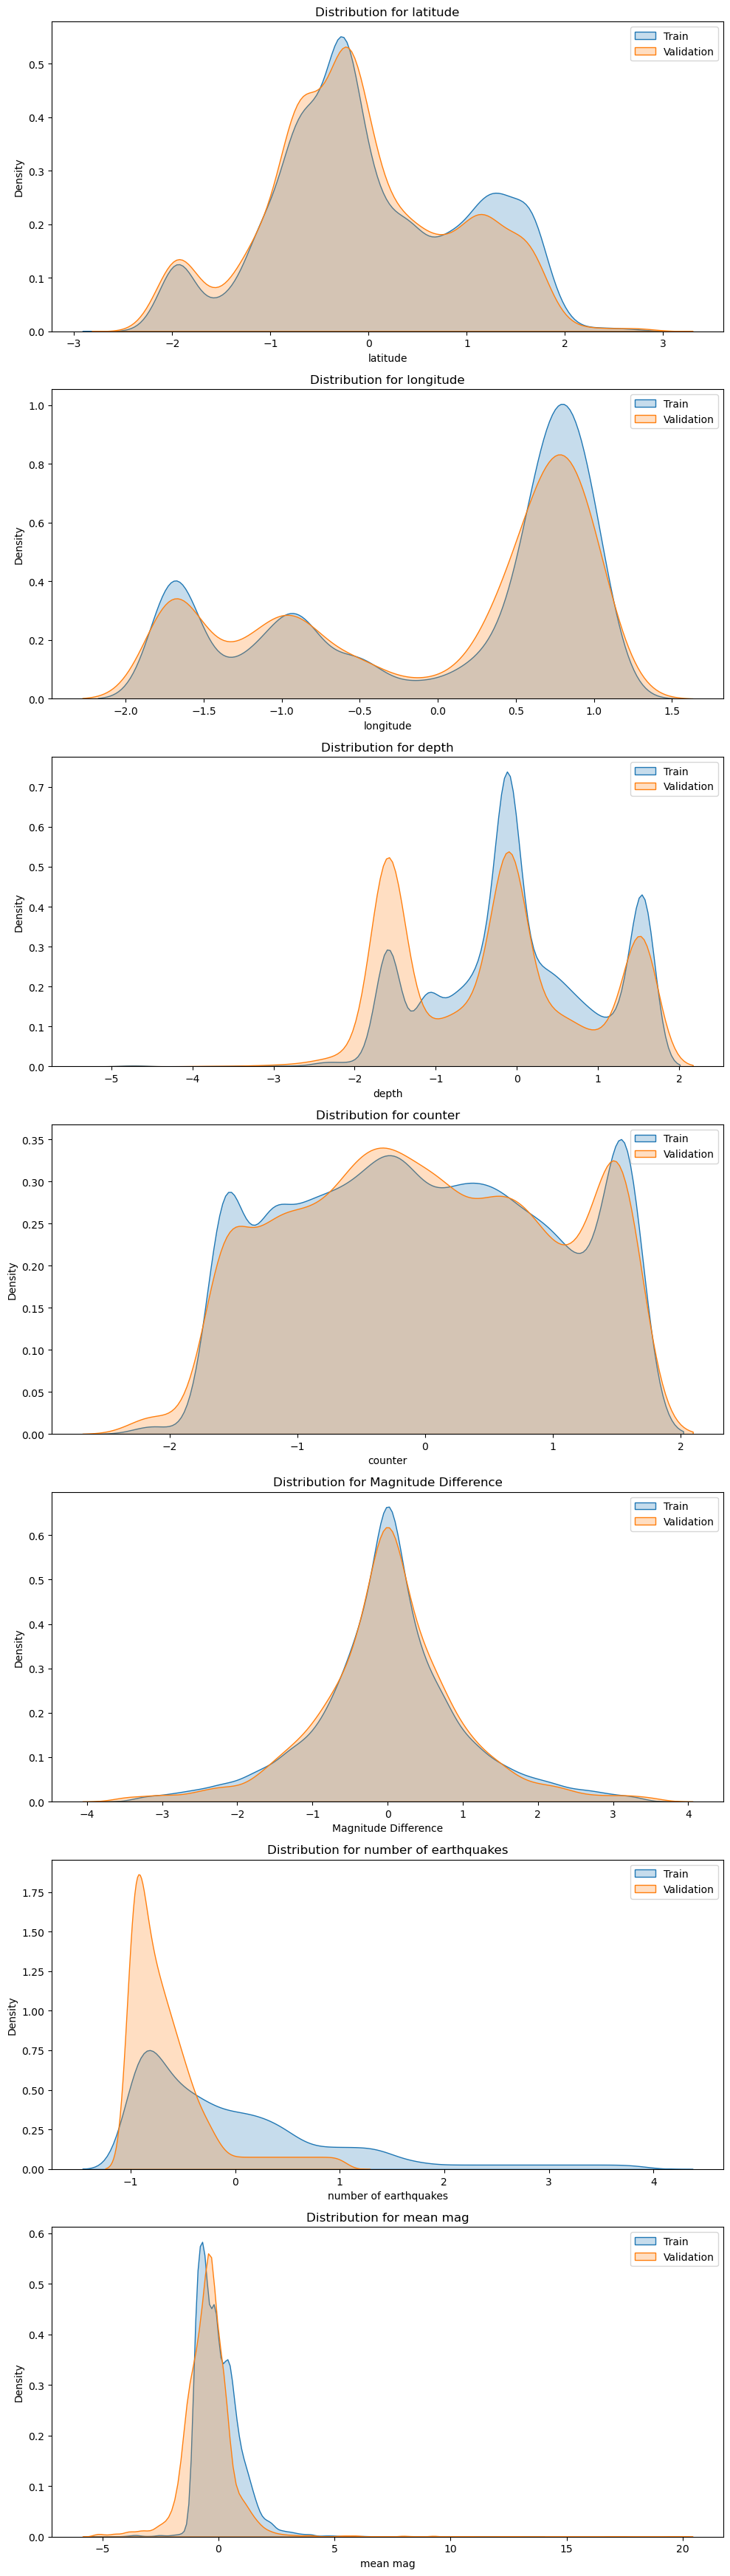

In [120]:
# Check the distribution of the features
fig, axs = plt.subplots(len(features_to_check), figsize=(10, 5 * len(features_to_check)))
for i, feature in enumerate(features_to_check):
    # Plot the density plot for each feature
    sns.kdeplot(train[feature], ax=axs[i], label='Train', fill=True)
    sns.kdeplot(val[feature], ax=axs[i], label='Validation', fill=True)
    axs[i].set_title(f'Distribution for {feature}')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [121]:
train = train.drop(columns=["date"])
val = val.drop(columns=["date"])

# Final check that everything is okay
print(train.head(10))
print("###########")
print(val.head(10))
print("###########")
print(f"train shape: {train.shape}")
print(f"test shape: {val.shape}")
print("############")
print(train.dtypes)
print(val.dtypes)


   latitude  longitude     depth       mag                 countries  \
0  1.648084   1.065922 -0.469894  0.061066  United States of America   
1 -0.989956  -0.842723 -0.748872  1.206237                 Argentina   
2  0.367234   0.637976 -0.198668  0.882795               Philippines   
3  1.037691   0.735556  0.410154  0.832517                     Japan   
4 -0.579297  -1.709764  0.532321  0.907882                    France   
5 -0.588342  -1.669325 -0.469894  0.061066                     Samoa   
6 -0.863084  -1.706893  0.644033  0.191949                     Tonga   
7 -0.039421   0.663130 -1.593518 -0.150340                 Indonesia   
8  1.339107   0.812410  0.384287  0.476600                     Japan   
9 -1.055236  -1.704763 -0.748872 -0.662565               New Zealand   

       PlateName      year     month       day  day_of_week  ...  \
0  North America -1.684627 -1.601451 -1.673805    -1.499743  ...   
1  South America -1.684627 -1.601451 -1.560170    -0.999753  ...   
2  

In [122]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def fit_encoder(*dataframes):
    # Combining the 'countries' and 'PlateName' columns from all dataframes for fitting
    combined_cats = pd.concat([df[['countries', 'PlateName']] for df in dataframes], ignore_index=True)
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(combined_cats)
    return encoder

def encode_data(encoder, df):
    cats = df[['countries', 'PlateName']]
    encoded_cats = encoder.transform(cats)
    encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(), index=df.index)
    df.drop(['countries', 'PlateName'], axis=1, inplace=True)
    return pd.concat([df, encoded_df], axis=1)

# # Fit encoder on all categories seen across datasets
encoder = fit_encoder(train, val, test_df_sorted)  

train = encode_data(encoder, train)
val= encode_data(encoder, val)

c:\Anacoda\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [123]:
train.to_csv("train_knn_ready_for_model.csv")
val.to_csv("val_knn_ready_for_model.csv")

## Functions for plotting the results of the model

In [124]:
## LOSS-ACC GRAPHS for training and evaluation
def loss_acc_graphs(history):

    #Training/Validation Accuracy
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('mae')
    plt.ylabel('mae')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()


## Preparing the data for the LSTM model

In [125]:
# Define the function to create sequences
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)
# Time steps for LSTM
time_steps = 7

In [126]:
""" # Ensure all required features are selected
feature_columns = train.columns.tolist()  # This will include all features after preprocessing

# Create sequences for LSTM
X_train, y_train = create_sequences(train[feature_columns].values, train['counter'].values.flatten(), time_steps)
X_val, y_val = create_sequences(val[feature_columns].values, val['counter'].values.flatten(), time_steps) """

" # Ensure all required features are selected\nfeature_columns = train.columns.tolist()  # This will include all features after preprocessing\n\n# Create sequences for LSTM\nX_train, y_train = create_sequences(train[feature_columns].values, train['counter'].values.flatten(), time_steps)\nX_val, y_val = create_sequences(val[feature_columns].values, val['counter'].values.flatten(), time_steps) "

In [127]:
# Ensure 'counter' is excluded from feature columns
feature_columns = [col for col in train.columns if col != 'counter']

# Print to verify feature columns
print("Feature columns:", feature_columns)
print("Number of features in feature_columns:", len(feature_columns))

# Recreate sequences for LSTM with correct features
X_train, y_train = create_sequences(train[feature_columns].values, train['counter'].values.flatten(), time_steps)
X_val, y_val = create_sequences(val[feature_columns].values, val['counter'].values.flatten(), time_steps)

Feature columns: ['latitude', 'longitude', 'depth', 'mag', 'year', 'month', 'day', 'day_of_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag', 'Magnitude Difference', 'number of earthquakes', 'depth_nugget_global', 'depth_sill_global', 'depth_range_global', 'mag_nugget_global', 'mag_sill_global', 'mag_range_global', 'depth_nugget_global_interaction', 'depth_sill_global_interaction', 'depth_range_global_interaction', 'mag_nugget_global_interaction', 'mag_sill_global_interaction', 'mag_range_global_interaction', 'depth_nugget_country', 'depth_sill_country', 'depth_range_country', 'mag_nugget_country', 'mag_sill_country', 'mag_range_country', 'depth_nugget_plate', 'depth_sill_plate', 'depth_range_plate', 'mag_nugget_plate', 'mag_sill_plate', 'mag_range_plate', 'depth_nugget_country_interaction', 'depth_sill_country_interaction', 'depth_range_country_interaction', 'depth_nugget_plate_interaction', 'depth_sill_plate_interaction', 'depth_range_plate_interaction

In [128]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)

Training data shape: (13142, 7, 148)
Training labels shape: (13142,)
Validation data shape: (4741, 7, 148)
Validation labels shape: (4741,)


## Model

In [129]:
""" def baseline_model(input_shape, l2_reg=0.001, learning_rate=0.00001, delta=20):
    regularizer = regularizers.l2(l2_reg)
    optimizer = Adam(learning_rate=learning_rate)

    # Custom Huber loss with the delta
    loss = Huber(delta=delta)

    model = Sequential([
        LSTM(32, input_shape=input_shape, return_sequences=False, kernel_regularizer=regularizer),
        Dense(32, activation="relu"),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer=optimizer, loss=loss, metrics=["mae"])
    return model  """

' def baseline_model(input_shape, l2_reg=0.001, learning_rate=0.00001, delta=20):\n    regularizer = regularizers.l2(l2_reg)\n    optimizer = Adam(learning_rate=learning_rate)\n\n    # Custom Huber loss with the delta\n    loss = Huber(delta=delta)\n\n    model = Sequential([\n        LSTM(32, input_shape=input_shape, return_sequences=False, kernel_regularizer=regularizer),\n        Dense(32, activation="relu"),\n        Dense(1, activation="linear")\n    ])\n    model.compile(optimizer=optimizer, loss=loss, metrics=["mae"])\n    return model  '

In [130]:
""" #LSTM model
model = baseline_model((time_steps, X_train.shape[2]))
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50) """

' #LSTM model\nmodel = baseline_model((time_steps, X_train.shape[2]))\nhistory = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50) '

In [131]:
""" # Plotting the results
loss_acc_graphs(history) """

' # Plotting the results\nloss_acc_graphs(history) '

Predictions on the original scale of days

In [132]:
""" # Make predictions on the validation set
predictions_scaled = model.predict(X_val)

# Inverse scale the predictions
predictions_inverse_scaled = target_scaler.inverse_transform(predictions_scaled)

# Inverse the log transform
predictions_original = np.expm1(predictions_inverse_scaled).flatten()

# For the validation set, we need to inverse scale and then inverse log transform as well
y_val_inverse_scaled = target_scaler.inverse_transform(y_val.reshape(-1, 1))
y_val_original_values = np.expm1(y_val_inverse_scaled).flatten()

# Evaluate the error using MAE on the original scale
mae_original = mean_absolute_error(y_val_original_values, predictions_original)
print(f"Original Mean Absolute Error: {mae_original}")

# Compare the first few predictions to the actual values
for pred, actual in zip(predictions_original[:15], y_val_original_values[:15]):
    print(f"Predicted: {pred}, Actual: {actual}") """

' # Make predictions on the validation set\npredictions_scaled = model.predict(X_val)\n\n# Inverse scale the predictions\npredictions_inverse_scaled = target_scaler.inverse_transform(predictions_scaled)\n\n# Inverse the log transform\npredictions_original = np.expm1(predictions_inverse_scaled).flatten()\n\n# For the validation set, we need to inverse scale and then inverse log transform as well\ny_val_inverse_scaled = target_scaler.inverse_transform(y_val.reshape(-1, 1))\ny_val_original_values = np.expm1(y_val_inverse_scaled).flatten()\n\n# Evaluate the error using MAE on the original scale\nmae_original = mean_absolute_error(y_val_original_values, predictions_original)\nprint(f"Original Mean Absolute Error: {mae_original}")\n\n# Compare the first few predictions to the actual values\nfor pred, actual in zip(predictions_original[:15], y_val_original_values[:15]):\n    print(f"Predicted: {pred}, Actual: {actual}") '

## heper paramter tuning

In [133]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras import regularizers
from keras_tuner import RandomSearch, HyperParameters
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import HyperModel
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [134]:
import datetime
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import Huber
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, TensorBoard
from keras_self_attention import SeqSelfAttention
from tensorboard.plugins.hparams import api as hp
import datetime
from keras_tuner import HyperModel, RandomSearch
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import HyperModel, HyperParameters, RandomSearch
from tensorflow.keras.callbacks import Callback

# Define hyperparameters
HP_UNITS = hp.HParam('units', hp.Discrete([16, 32, 64]))
HP_L2_REG = hp.HParam('l2_reg', hp.Discrete([0.01, 0.001, 0.0001]))
HP_DROPOUT_RATE = hp.HParam('dropout_rate', hp.Discrete([0.1, 0.2, 0.3, 0.4]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.0001, 0.001, 0.01]))
HP_DELTA = hp.HParam('delta', hp.Discrete([5, 10, 20, 30]))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([16, 32, 64]))

METRIC_MAE = 'mae'

with tf.summary.create_file_writer('logs/hparam_tuning_semivariogram_attention_correct').as_default():
    hp.hparams_config(
        hparams=[HP_UNITS, HP_L2_REG, HP_DROPOUT_RATE, HP_LEARNING_RATE, HP_DELTA, HP_BATCH_SIZE],
        metrics=[hp.Metric(METRIC_MAE, display_name='Mean Absolute Error')],
    )

class TensorBoardHParams(Callback):
    def __init__(self, log_dir, hparams):
        super(TensorBoardHParams, self).__init__()
        self.log_dir = log_dir
        self.hparams = hparams
        self.writer = tf.summary.create_file_writer(self.log_dir)

    def on_train_end(self, logs=None):
        logs = logs or {}
        with self.writer.as_default():
            hp.hparams(self.hparams)  # log the hyperparameters
            for metric, value in logs.items():
                tf.summary.scalar(metric, value, step=1)
        self.writer.flush()



class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential([
            LSTM(
                units=hp.Choice('units', values=[16, 32, 64]),
                input_shape=self.input_shape,
                return_sequences=True,  # Enable return sequences for attention layer
                kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.0001, 0.001, 0.01]))
            ),
            SeqSelfAttention(attention_activation='sigmoid'),
            Dropout(rate=hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3, 0.4])),
            LSTM(units=8, return_sequences=False),
            Dense(1, activation='linear')
        ])
        delta_value = float(hp.Choice('delta', values=[5, 10, 20, 30]))
        model.compile(
            optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01])),
            loss=Huber(delta=delta_value),
            metrics=['mae']
        )
        return model

    def fit(self, hp, model, x, y, validation_data, **kwargs):
        batch_size = hp.Choice('batch_size', values=[16, 32, 64])
        log_dir = "./logs/hparam_tuning_semivariogram_attention_correct/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        callbacks = [
            EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True),
            TensorBoard(log_dir=log_dir),
            TensorBoardHParams(log_dir, {
                'units': hp.get('units'),
                'l2_reg': hp.get('l2_reg'),
                'dropout_rate': hp.get('dropout_rate'),
                'learning_rate': hp.get('learning_rate'),
                'delta': hp.get('delta'),
                'batch_size': batch_size 
            })
        ]
        history = model.fit(
            x, y,
            validation_data=validation_data,
            batch_size=batch_size,
            epochs=40,
            callbacks=callbacks
        )
        return history

hypermodel = MyHyperModel(input_shape=(time_steps, X_train.shape[2]))

# Configure and execute the random search
tuner = RandomSearch(
    hypermodel,
    objective='val_mae',
    max_trials=30,
    executions_per_trial=1,
    directory='hyperparam_tuning_semivariogram_attention_layer_LSTM_monthly_year_correct',
    project_name='LSTM_tuning_semivariogram_attention_LSTM_monthly_year_correct'
)


"""
    directory='hyperparam_tuning_semivariogram_attention_layer_LSTM_monthly_year',
    project_name='LSTM_tuning_semivariogram_attention_LSTM_monthly_year'
)
"""
tuner.search(X_train, y_train, validation_data=(X_val, y_val))

# Extract the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Rebuild the model with the best hyperparameters
best_model = hypermodel.build(best_hps)
best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, callbacks=[EarlyStopping(monitor='val_mae', patience=6, restore_best_weights=True)])

# Predict and evaluate the model
predictions_scaled = best_model.predict(X_val)
predictions_inverse_scaled = target_scaler.inverse_transform(predictions_scaled)
predictions_original = np.expm1(predictions_inverse_scaled).flatten()
y_val_inverse_scaled = target_scaler.inverse_transform(y_val.reshape(-1, 1))
y_val_original_values = np.expm1(y_val_inverse_scaled).flatten()
mae_original = mean_absolute_error(y_val_original_values, predictions_original)
print(f"Original Mean Absolute Error: {mae_original}")


Trial 30 Complete [00h 01m 14s]
val_mae: 0.8520441651344299

Best val_mae So Far: 0.8501313924789429
Total elapsed time: 00h 45m 16s
Epoch 1/40
411/411 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 1.9986 - mae: 0.8657 - val_loss: 1.1629 - val_mae: 0.8534
Epoch 2/40
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.0218 - mae: 0.8611 - val_loss: 0.7136 - val_mae: 0.8516
Epoch 3/40
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.6697 - mae: 0.8615 - val_loss: 0.5667 - val_mae: 0.8513
Epoch 4/40
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.5576 - mae: 0.8598 - val_loss: 0.5277 - val_mae: 0.8520
Epoch 5/40
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.5280 - mae: 0.8597 - val_loss: 0.5185 - val_mae: 0.8509
Epoch 6/40
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.5216 - mae: 0.8600 - val_loss: 0.5169 - val_mae: 0.8517
Epoch 7/40
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.5194 - mae: 0.8589 - val_loss: 0.5144 - val_mae: 0.8511
Epoch 8/40
411/411 ━━━━━━━━━━━━━━

In [135]:
tuner.results_summary()

Results summary
Results in hyperparam_tuning_semivariogram_attention_layer_LSTM_monthly_year_correct\LSTM_tuning_semivariogram_attention_LSTM_monthly_year_correct
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 26 summary
Hyperparameters:
units: 64
l2_reg: 0.01
dropout_rate: 0.1
delta: 5
learning_rate: 0.0001
batch_size: 16
Score: 0.8501313924789429

Trial 08 summary
Hyperparameters:
units: 32
l2_reg: 0.01
dropout_rate: 0.2
delta: 30
learning_rate: 0.0001
batch_size: 16
Score: 0.850163459777832

Trial 12 summary
Hyperparameters:
units: 64
l2_reg: 0.0001
dropout_rate: 0.3
delta: 10
learning_rate: 0.0001
batch_size: 64
Score: 0.8501890897750854

Trial 11 summary
Hyperparameters:
units: 64
l2_reg: 0.01
dropout_rate: 0.3
delta: 5
learning_rate: 0.001
batch_size: 64
Score: 0.8502163290977478

Trial 25 summary
Hyperparameters:
units: 16
l2_reg: 0.0001
dropout_rate: 0.3
delta: 5
learning_rate: 0.0001
batch_size: 64
Score: 0.8504971861839294

Trial 06 summary
Hyperpara

In [136]:
# Extract the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best hyperparameters:")
print(f"Units: {best_hps.get('units')}")
print(f"L2 Regularization: {best_hps.get('l2_reg')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Huber Delta: {best_hps.get('delta')}")
print(f"Batch Size: {best_hps.get('batch_size')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")

Best hyperparameters:
Units: 64
L2 Regularization: 0.01
Learning Rate: 0.0001
Huber Delta: 5
Batch Size: 16
Dropout Rate: 0.1


In [137]:
"""
Best hyperparameters:
Units: 64
L2 Regularization: 0.01
Learning Rate: 0.0001
Huber Delta: 10
Batch Size: 64
"""

'\nBest hyperparameters:\nUnits: 64\nL2 Regularization: 0.01\nLearning Rate: 0.0001\nHuber Delta: 10\nBatch Size: 64\n'

In [138]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras


tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

In [139]:
%reload_ext tensorboard

In [140]:
# After tuning, visualize the tuning process using:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 10716), started 5:02:30 ago. (Use '!kill 10716' to kill it.)

   units  l2_reg  dropout_rate  delta  learning_rate  batch_size   val_mae
0     16  0.0100           0.4     10         0.0001          16  0.851348
1     64  0.0100           0.3     30         0.0100          16  0.851882
2     64  0.0100           0.1     30         0.0100          16  0.852024
3     16  0.0001           0.3     10         0.0100          64  0.851469
4     64  0.0100           0.3     20         0.0100          64  0.851589


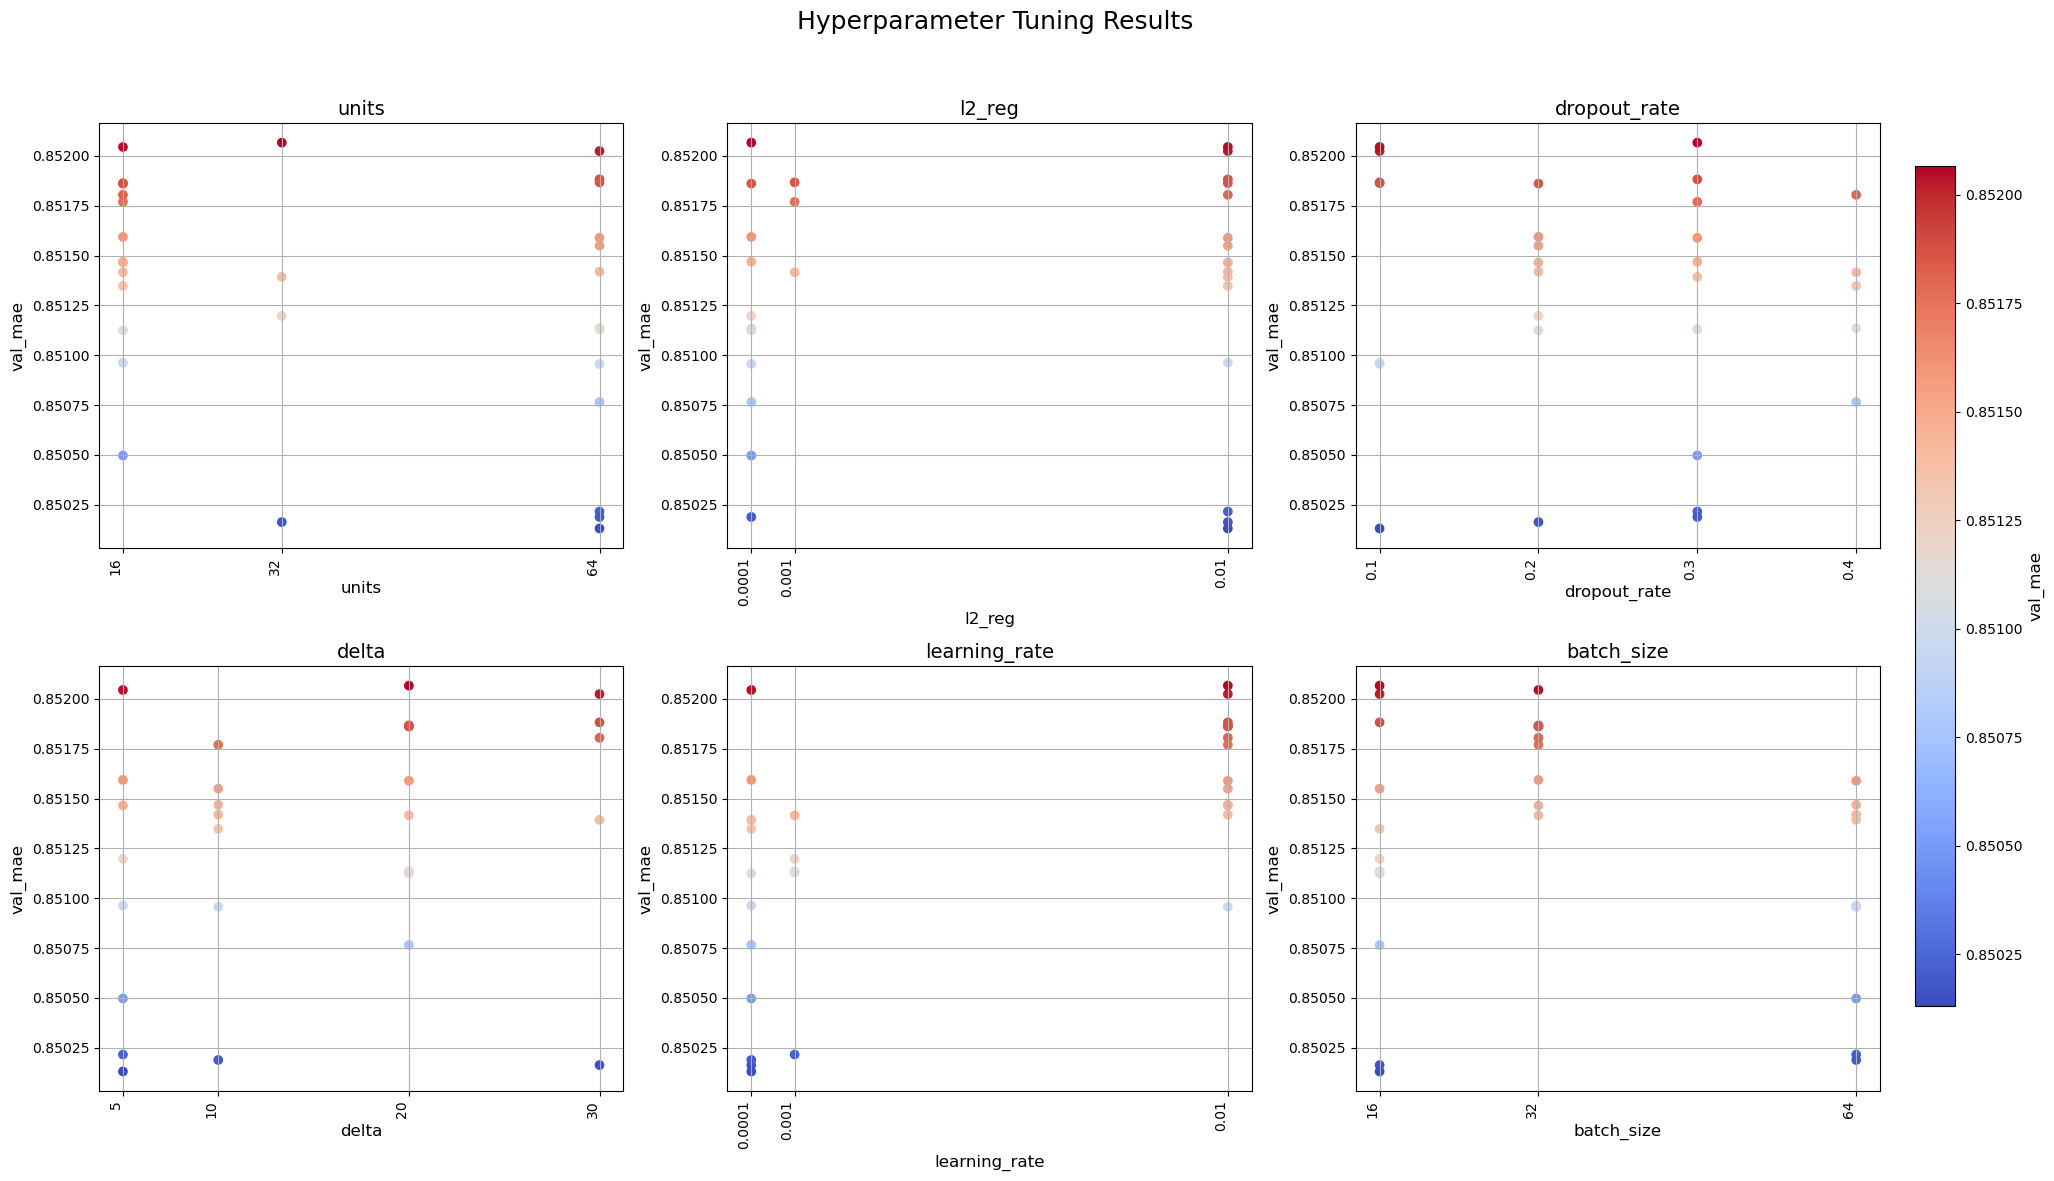

In [141]:
import os
import json
import pandas as pd

# Path to the directory where TensorBoard logs are stored
log_dir = 'hyperparam_tuning_semivariogram_attention_layer_LSTM_monthly_year_correct'

# Function to extract data from the JSON files
def extract_data_from_json(log_dir):
    data = []
    for root, dirs, files in os.walk(log_dir):
        for file in files:
            if file == 'trial.json':
                trial_file = os.path.join(root, file)
                with open(trial_file, 'r') as f:
                    trial_data = json.load(f)
                    hyperparameters = trial_data['hyperparameters']['values']
                    metrics = trial_data['metrics']['metrics']
                    # Extract the last value of the validation mean absolute error
                    val_mae = metrics['val_mae']['observations'][-1]['value'][0]
                    hyperparameters['val_mae'] = val_mae
                    data.append(hyperparameters)
    df = pd.DataFrame(data)
    return df

# Extract data
df = extract_data_from_json(log_dir)
print(df.head())


# Prepare the DataFrame for plotting
df_hyperparams = df.dropna(axis=1, how='all')

# List of hyperparameters
hyperparams = [col for col in df_hyperparams.columns if col != 'val_mae']

# Hyperparameter values for setting tickvals and ticktext
hyperparam_values = {
    'units': [16, 32, 64],
    'l2_reg': [0.01, 0.001, 0.0001],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4],
    'learning_rate': [0.0001, 0.001, 0.01],
    'delta': [5, 10, 20, 30],
    'batch_size': [16, 32, 64],
    
}


# Calculate the number of rows and columns needed
num_plots = len(hyperparams)
cols = 3
rows = (num_plots // cols) + (num_plots % cols > 0)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Define the colormap
cmap = plt.get_cmap("coolwarm")
norm = plt.Normalize(vmin=df_hyperparams['val_mae'].min(), vmax=df_hyperparams['val_mae'].max())

for i, param in enumerate(hyperparams):
    ax = axes[i]
    sc = ax.scatter(df_hyperparams[param], df_hyperparams['val_mae'], c=df_hyperparams['val_mae'], cmap=cmap, norm=norm, marker='o')
    ax.set_title(param, fontsize=14)
    ax.set_xlabel(param, fontsize=12)
    ax.set_ylabel('val_mae', fontsize=12)
    ax.grid(True)
    # Set x-axis ticks
    if param in hyperparam_values:
        ax.set_xticks(hyperparam_values[param])
        ax.set_xticklabels([str(val) for val in hyperparam_values[param]], fontsize=10, rotation=90, ha='right')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
fig.suptitle('Hyperparameter Tuning Results', fontsize=18)
plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for the title

# Add a color bar
cbar_ax = fig.add_axes([0.96, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('val_mae', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Save the figure as PDF
plt.savefig("Scatter_Plot_Matrix_Hyperparameter_Tuning_Attention_Semivariogram.pdf")
plt.show()

In [142]:
# Rebuild the model with the best hyperparameters
best_model = hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[EarlyStopping(monitor='val_mae', patience=6, restore_best_weights=True)])

c:\Anacoda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 1.9920 - mae: 0.8625 - val_loss: 1.1606 - val_mae: 0.8534
Epoch 2/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1.0160 - mae: 0.8593 - val_loss: 0.7112 - val_mae: 0.8523
Epoch 3/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.6658 - mae: 0.8601 - val_loss: 0.5669 - val_mae: 0.8538
Epoch 4/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.5539 - mae: 0.8587 - val_loss: 0.5287 - val_mae: 0.8531
Epoch 5/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.5265 - mae: 0.8583 - val_loss: 0.5240 - val_mae: 0.8572
Epoch 6/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.5203 - mae: 0.8584 - val_loss: 0.5181 - val_mae: 0.8539
Epoch 7/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.5176 - mae: 0.8593 - val_loss: 0.5135 - val_mae: 0.8516
Epoch 8/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.5163 - mae: 0.8591 - val_loss: 0.5128 - val_mae: 0.8519
Epoch 9/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/s

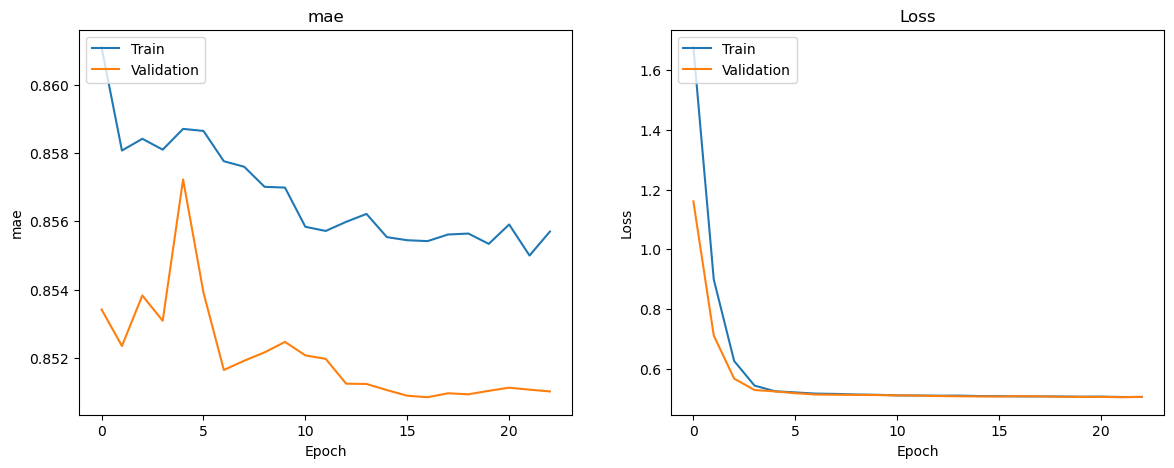

In [143]:
# Plotting the results
loss_acc_graphs(history)

prediction on the original scale of days

In [144]:
# Make predictions on the validation set
predictions_scaled = best_model.predict(X_val)

# Inverse scale the predictions
predictions_inverse_scaled = target_scaler.inverse_transform(predictions_scaled)

# Inverse the log transform
predictions_original = np.expm1(predictions_inverse_scaled).flatten()

# For the validation set, we need to inverse scale and then inverse log transform as well
y_val_inverse_scaled = target_scaler.inverse_transform(y_val.reshape(-1, 1))
y_val_original_values = np.expm1(y_val_inverse_scaled).flatten()

# Evaluate the error using MAE on the original scale
mae_original = mean_absolute_error(y_val_original_values, predictions_original)
print(f"Original Mean Absolute Error: {mae_original}")

# Compare the first few predictions to the actual values
for pred, actual in zip(predictions_original[:15], y_val_original_values[:15]):
    print(f"Predicted: {pred}, Actual: {actual}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Original Mean Absolute Error: 19.538474997395944
Predicted: 9.315526008605957, Actual: 54.000000000000014
Predicted: 9.315666198730469, Actual: 36.99999999999999
Predicted: 9.316954612731934, Actual: 84.30000000000015
Predicted: 9.290926933288574, Actual: 82.00000000000003
Predicted: 9.291142463684082, Actual: 3.0
Predicted: 9.31600284576416, Actual: 14.999999999999998
Predicted: 9.290931701660156, Actual: 5.0
Predicted: 9.31445598602295, Actual: 3.0
Predicted: 9.315498352050781, Actual: 12.999999999999996
Predicted: 9.315449714660645, Actual: 23.000000000000004
Predicted: 9.315650939941406, Actual: 2.000000000000001
Predicted: 9.31694507598877, Actual: 54.000000000000014
Predicted: 9.314684867858887, Actual: 5.999999999999998
Predicted: 9.335508346557617, Actual: 11.0
Predicted: 9.333879470825195, Actual: 14.0


## Error Analysis

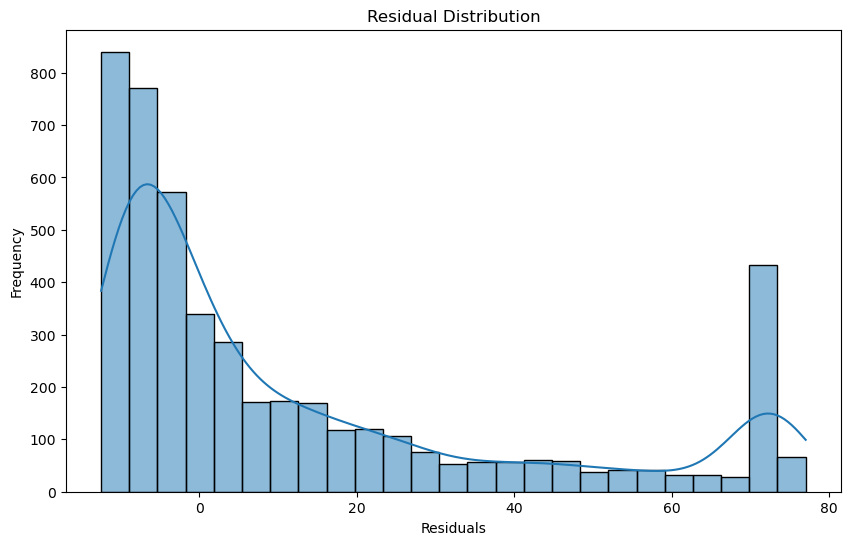

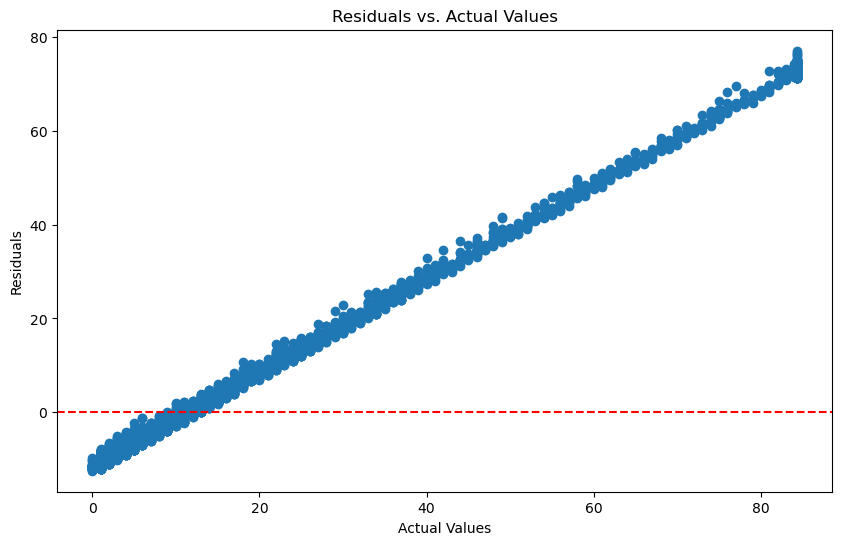

In [145]:
# Calculate residuals
residuals = y_val_original_values - predictions_original

# Plotting the residuals distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_val_original_values, residuals)
plt.title('Residuals vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at zero for reference
plt.show()

## Including the whole train dataframe and testing on the test set

In [146]:
# Check the number of missing values in each column of the DataFrame
missing_values_train = train_df_sorted.isnull().sum()
print(f"train missing values: {missing_values_train}")
print(f"train shape: {train_df_sorted.shape}")

missing_values_test = test_df_sorted.isnull().sum()
print(f"test missing values: {missing_values_test}")
print(f"test shape: {test_df_sorted.shape}") 

#train shape: (17897, 19)
#test shape: (4747, 19)

train missing values: latitude                 1226
longitude                1226
depth                    1227
mag                      1226
countries                1226
PlateName                1226
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin             0
day_of_week_cos             0
month_sin                   0
month_cos                   0
mean mag                 6544
Magnitude Difference     6544
number of earthquakes    6544
date                        0
counter                  1228
dtype: int64
train shape: (17897, 19)
test missing values: latitude                  200
longitude                 200
depth                     200
mag                       200
countries                 200
PlateName                 200
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin             0
day_of_week_cos    

remove the rows/earthquakes which are the latest recordings of a country

In [147]:
# Condition to check where 'counter' is NaN and 'latitude' is not NaN
condition = train_df_sorted['counter'].isna() & train_df_sorted['latitude'].notna()

# Count the rows meeting the condition
count_nan_counter = condition.sum()
print("Number of rows where 'counter' is NaN and 'latitude' is not NaN:", count_nan_counter)

# Optional: print rows meeting the condition
print(train_df_sorted[condition])

# Columns to fill with NaN
columns_to_fill_nan = ['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName', 'mean mag', 'Magnitude Difference', 'number of earthquakes']

# Fill specified columns with NaN for rows meeting the condition
train_df_sorted.loc[condition, columns_to_fill_nan] = pd.NA

Number of rows where 'counter' is NaN and 'latitude' is not NaN: 2
       latitude  longitude  depth  mag countries PlateName  year  month  day  \
7736     -3.471    177.628   33.0  5.8  Kiribati   Pacific  1983      3    8   
15972    12.471     40.634   11.8  5.5  Ethiopia    Arabia  2005      9   24   

       day_of_week  day_of_week_sin  day_of_week_cos  month_sin  month_cos  \
7736             1         0.781831         0.623490   0.866025        0.5   
15972            5        -0.974928        -0.222521  -0.866025       -0.5   

       mean mag  Magnitude Difference  number of earthquakes       date  \
7736   5.646154                   0.0                   13.0 1983-03-08   
15972  5.890526                   0.0                   19.0 2005-09-24   

       counter  
7736       NaN  
15972      NaN  


In [148]:
# Check for missing values in all columns
missing_values = train_df_sorted.isnull().sum()
print("Missing train in each column of val set:")
print(missing_values)

# Check for missing values in all columns
missing_values = test_df_sorted.isnull().sum()
print("Missing val in each column of val set:")
print(missing_values)

"""
train_df_sorted: 6.8% missing data
test: 4% missing data
"""

Missing train in each column of val set:
latitude                 1228
longitude                1228
depth                    1229
mag                      1228
countries                1228
PlateName                1228
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin             0
day_of_week_cos             0
month_sin                   0
month_cos                   0
mean mag                 6546
Magnitude Difference     6546
number of earthquakes    6546
date                        0
counter                  1228
dtype: int64
Missing val in each column of val set:
latitude                  200
longitude                 200
depth                     200
mag                       200
countries                 200
PlateName                 200
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin             0
day_of_

'\ntrain_df_sorted: 6.8% missing data\ntest: 4% missing data\n'

feature transformation

In [149]:
numeric_features = [ 'depth', "mag", "year", "month", "day", 'day_of_week', 'day_of_week_sin', 'day_of_week_cos', 
                    'month_sin','month_cos', 'mean mag', 'Magnitude Difference', 'number of earthquakes']

# features for cap and log
features_for_cap_and_log = [ 'depth', 'mag']
for feature in features_for_cap_and_log:
    train_df_sorted[feature] = cap_and_log_transform(train_df_sorted, feature)
    test_df_sorted[feature] = cap_and_log_transform(test_df_sorted, feature)


#standardize the features
scaler = StandardScaler()

# After the imputation of missing data we will update the columns counter, mean mag, magnitude difference and number of earthquakes and then standardize them as well
# month_sin and month_cos... which already encode the cyclical nature in a bounded range (typically -1 to 1), additional scaling might not be necessary

# List of features to be standardized excluding latitude and longitude
numeric_features_to_standardize = ['depth', "mag", "year", "month", "day", 'day_of_week', ]


# Initialize a dictionary to hold the scalers for each feature
scalers = {feature: StandardScaler() for feature in numeric_features_to_standardize}

# Fit and transform each feature separately for the training data
for feature in numeric_features_to_standardize:
    train_df_sorted[feature] = scalers[feature].fit_transform(train_df_sorted[[feature]])

# Transform each feature separately for the validation data using the fitted scalers
for feature in numeric_features_to_standardize:
    test_df_sorted[feature] = scalers[feature].transform(test_df_sorted[[feature]])

imputation of latitude and longitude

In [150]:
# Separate out rows that have complete geospatial data
complete_cases = train_df_sorted.dropna(subset=['latitude', 'longitude'])

In [151]:
# Find the index of rows with missing geospatial data
missing_geo_index = train_df_sorted[train_df_sorted['latitude'].isna() | train_df_sorted['longitude'].isna()].index

# Randomly sample non-missing coordinates for latitude and longitude
random_sample = complete_cases.sample(len(missing_geo_index), random_state=42)
print(random_sample.head())
# Temporarily fill missing values
train_df_sorted.loc[missing_geo_index, 'latitude'] = random_sample["latitude"].values
train_df_sorted.loc[missing_geo_index, 'longitude'] = random_sample["longitude"].values

# Instantiate the KNN regressor with haversine distance
knn = KNeighborsRegressor(n_neighbors=3, metric='haversine')

# Fit the KNN regressor on the non-missing data
# Convert degrees to radians for haversine distance calculation
knn.fit(np.radians(complete_cases[['latitude', 'longitude']]), complete_cases[['latitude', 'longitude']])

# Now apply KNN
imputed_values = knn.predict(np.radians(train_df_sorted.loc[missing_geo_index, ['latitude', 'longitude']]))
train_df_sorted.loc[missing_geo_index, ['latitude', 'longitude']] = imputed_values


       latitude  longitude     depth       mag       countries PlateName  \
7507     36.194    141.702  0.087079  3.025518           Japan   Okhotsk   
14970    50.007    156.164  0.826065 -0.966275          Russia   Okhotsk   
14984   -15.860   -174.380  1.551400 -0.966275           Tonga     Tonga   
10905   -59.449    -26.183 -0.037827 -0.966275  United Kingdom  Sandwich   
4765    -20.523   -173.760 -0.037827 -0.689332           Tonga     Tonga   

           year     month       day  day_of_week  day_of_week_sin  \
7507  -0.282847  0.138316  0.712561     0.000140         0.433884   
14970  1.131389  1.588143  1.280742     0.500157        -0.433884   
14984  1.202100 -1.601477 -0.651073     0.500157        -0.433884   
10905  0.353559  1.298178 -0.651073     1.500192        -0.781831   
4765  -0.777830 -1.601477  0.258016     1.000175        -0.974928   

       day_of_week_cos     month_sin  month_cos  mean mag  \
7507         -0.900969  1.224647e-16  -1.000000       NaN   
14970 

In [152]:
# check that everything is okay
print(train_df_sorted.head(10))
print("###########")
print(test_df_sorted.head(10))
print("###########")
print(f"train shape: {train_df_sorted.shape}")
print(f"test shape: {test_df_sorted.shape}")
print("############")
print(train_df_sorted.dtypes)
print(test_df_sorted.dtypes)


    latitude   longitude     depth       mag                 countries  \
0  52.112000  177.594000 -0.370763  0.064342  United States of America   
1  36.152667  141.713667       NaN       NaN                       NaN   
2  49.996667  156.179333       NaN       NaN                       NaN   
3  33.623000  135.317000  0.465385  0.838546                     Japan   
4 -15.356000 -177.611000  0.581458  0.914179                    France   
5 -15.630000 -172.436000 -0.370763  0.064342                     Samoa   
6 -15.770333 -174.285000       NaN       NaN                       NaN   
7 -59.498000  -26.203000       NaN       NaN                       NaN   
8  42.753000  145.152000  0.440809  0.481359                     Japan   
9 -20.520333 -173.815333       NaN       NaN                       NaN   

       PlateName      year     month       day  day_of_week  day_of_week_sin  \
0  North America -1.697083 -1.601477 -1.673799    -1.499913         0.000000   
1            NaN -1.69708

In [153]:
# Find the index of rows with missing geospatial data in the validation dataset
missing_geo_index_val = test_df_sorted[test_df_sorted['latitude'].isna() | test_df_sorted['longitude'].isna()].index

random_sample_val = complete_cases.sample(len(missing_geo_index_val), random_state=42)
test_df_sorted.loc[missing_geo_index_val, 'latitude'] = random_sample_val["latitude"].values
test_df_sorted.loc[missing_geo_index_val, 'longitude'] = random_sample_val["longitude"].values

# Apply the KNN model to impute missing latitude and longitude in the test dataset
# Convert degrees to radians for haversine distance calculation
imputed_values_val = knn.predict(np.radians(test_df_sorted.loc[missing_geo_index_val, ['latitude', 'longitude']]))

# Replace the missing values with the imputed values
test_df_sorted.loc[missing_geo_index_val, ['latitude', 'longitude']] = imputed_values_val

# Print for checking results
print(test_df_sorted.head(10))

   latitude  longitude     depth       mag   countries      PlateName  \
0   -26.851    -63.217  1.429736 -0.201247   Argentina  South America   
1   -38.355    -73.326 -0.419438  3.248090       Chile  South America   
2   -59.791    149.897 -1.438336 -0.689332  Antarctica     Antarctica   
3   -19.307    168.002 -1.438336 -0.966275     Vanuatu   New Hebrides   
4   -22.260    171.631  1.429736  0.635301      France   New Hebrides   
5   -19.311    167.960 -1.438336 -0.966275     Vanuatu   New Hebrides   
6     4.243     90.414 -0.827136 -0.966275       India          India   
7    -0.026    124.913  0.618573 -0.689332   Indonesia          Sunda   
8   -19.297    168.009 -1.438336 -0.966275     Vanuatu   New Hebrides   
9   -35.594    -73.064 -0.399738  0.116997       Chile  South America   

       year     month       day  day_of_week  day_of_week_sin  \
0  1.767795 -1.601477 -1.673799     1.000175        -0.974928   
1  1.767795 -1.601477 -1.560163     1.500192        -0.781831   
2

imputation of depth and mag

In [154]:
to_impute = ["depth", "mag"]
train_df_sorted, test_df_sorted = perform_knn_imputation(train_df_sorted, test_df_sorted, to_impute)

In [155]:
# check that everything is okay
print(train_df_sorted.head(10))
print("###########")
print(test_df_sorted.head(10))
print("###########")
print(f"train shape: {train_df_sorted.shape}")
print(f"test shape: {test_df_sorted.shape}")
print("############")
print(train_df_sorted.dtypes)
print(test_df_sorted.dtypes)


    latitude   longitude     depth       mag                 countries  \
0  52.112000  177.594000 -0.370763  0.064342  United States of America   
1  36.152667  141.713667 -0.113067  0.889003                       NaN   
2  49.996667  156.179333  1.551400  0.116997                       NaN   
3  33.623000  135.317000  0.465385  0.838546                     Japan   
4 -15.356000 -177.611000  0.581458  0.914179                    France   
5 -15.630000 -172.436000 -0.370763  0.064342                     Samoa   
6 -15.770333 -174.285000 -1.438336  0.378000                       NaN   
7 -59.498000  -26.203000  1.551400  0.378000                       NaN   
8  42.753000  145.152000  0.440809  0.481359                     Japan   
9 -20.520333 -173.815333 -0.037827  2.340931                       NaN   

       PlateName      year     month       day  day_of_week  day_of_week_sin  \
0  North America -1.697083 -1.601477 -1.673799    -1.499913         0.000000   
1            NaN -1.69708

mapping of imputed data to a country and a tectonic plate

In [156]:
# Identify the rows with NaN in "counter" 
missing_counter_train  = train_df_sorted['counter'].isna()
missing_counter_val  = test_df_sorted['counter'].isna()


# Create GeoDataFrames from filtered data
geo_train = gpd.GeoDataFrame(train_df_sorted.loc[missing_counter_train], 
                             geometry=gpd.points_from_xy(train_df_sorted.loc[missing_counter_train, 'longitude'], train_df_sorted.loc[missing_counter_train, 'latitude']), 
                             crs="EPSG:4326")
geo_val = gpd.GeoDataFrame(test_df_sorted.loc[missing_counter_val], geometry=gpd.points_from_xy(test_df_sorted.loc[missing_counter_val, 'longitude'], test_df_sorted.loc[missing_counter_val, 'latitude']), crs="EPSG:4326")


# Perform the mapping using the apply function
geo_train['countries'] = geo_train.geometry.apply(lambda x: find_nearest_country(x, gdf_countries))
geo_train['PlateName'] = geo_train.geometry.apply(lambda x: find_nearest_plate(x, gdf_plates))
geo_val['countries'] = geo_val.geometry.apply(lambda x: find_nearest_country(x, gdf_countries))
geo_val['PlateName'] = geo_val.geometry.apply(lambda x: find_nearest_plate(x, gdf_plates))

# Update the original dataframes
train_df_sorted.update(geo_train[['countries', 'PlateName']])
test_df_sorted.update(geo_val[['countries', 'PlateName']])

In [157]:
# Check for missing values in all columns
missing_values = train_df_sorted.isnull().sum()
print("Missing train in each column of val set:")
print(missing_values)

# Check for missing values in all columns
missing_values = test_df_sorted.isnull().sum()
print("Missing test_df_sorted in each column of val set:")
print(missing_values)

Missing train in each column of val set:
latitude                    0
longitude                   0
depth                       0
mag                         0
countries                   0
PlateName                   0
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin             0
day_of_week_cos             0
month_sin                   0
month_cos                   0
mean mag                 6546
Magnitude Difference     6546
number of earthquakes    6546
date                        0
counter                  1228
dtype: int64
Missing test_df_sorted in each column of val set:
latitude                    0
longitude                   0
depth                       0
mag                         0
countries                   0
PlateName                   0
year                        0
month                       0
day                         0
day_of_week                 0
day_of_week_sin           

In [158]:
# check that everything is okay
print(train_df_sorted.head(10))
print("###########")
print(test_df_sorted.head(10))
print("###########")
print(f"train shape: {train_df_sorted.shape}")
print(f"test shape: {test_df_sorted.shape}")
print("############")
print(train_df_sorted.dtypes)
print(test_df_sorted.dtypes)

    latitude   longitude     depth       mag                 countries  \
0  52.112000  177.594000 -0.370763  0.064342  United States of America   
1  36.152667  141.713667 -0.113067  0.889003                     Japan   
2  49.996667  156.179333  1.551400  0.116997                    Russia   
3  33.623000  135.317000  0.465385  0.838546                     Japan   
4 -15.356000 -177.611000  0.581458  0.914179                    France   
5 -15.630000 -172.436000 -0.370763  0.064342                     Samoa   
6 -15.770333 -174.285000 -1.438336  0.378000                     Tonga   
7 -59.498000  -26.203000  1.551400  0.378000            United Kingdom   
8  42.753000  145.152000  0.440809  0.481359                     Japan   
9 -20.520333 -173.815333 -0.037827  2.340931                     Tonga   

       PlateName      year     month       day  day_of_week  day_of_week_sin  \
0  North America -1.697083 -1.601477 -1.673799    -1.499913         0.000000   
1        Okhotsk -1.69708

standardizing latitude and longitude

scale latitude and longitude

In [159]:
lat_long_scale = StandardScaler()

# Fit the scaler on the training data's 'counter' column
train_df_sorted[['latitude', 'longitude']] = lat_long_scale.fit_transform(train_df_sorted[['latitude', 'longitude']])

# Transform the 'counter' column in the validation dataset using the fitted scaler
test_df_sorted[['latitude', 'longitude']] = lat_long_scale.transform(test_df_sorted[['latitude', 'longitude']])

# Optional: View the first few rows to verify the scaling
print(train_df_sorted[['latitude', 'longitude']].head())
print(test_df_sorted[['latitude', 'longitude']].head())

   latitude  longitude
0  1.691311   1.080979
1  1.160851   0.800953
2  1.621001   0.913849
3  1.076770   0.751031
4 -0.551204  -1.691193
   latitude  longitude
0 -0.933277  -0.798414
1 -1.315649  -0.877309
2 -2.028143   0.864819
3 -0.682528   1.006118
4 -0.780681   1.034441


## update columns that are derived from the data itself and standardize them.

In [160]:
# Extract mean and scale for 'mag'
mag_mean = scalers['mag'].mean_[0]  # the mean of 'mag'
mag_scale = scalers['mag'].scale_[0]  # the scale of 'mag'

# Function to calculate new features after reversing transformations
def calculate_new_features(df, mean, scale):
    # Manually reverse transformations for 'mag' accurately
    df['mag_original'] = np.expm1(df['mag'] * scale + mean)
    
    # Calculate new features based on 'mag_original'
    df['mean mag'] = df.groupby('countries')['mag_original'].expanding().mean().reset_index(level=0, drop=True)
    df['prev_mag'] = df.groupby('countries')['mag_original'].shift(1)
    df['Magnitude Difference'] = df['mag_original'] - df['prev_mag']
    df['Magnitude Difference'].fillna(0, inplace=True)
    df['number of earthquakes'] = df.groupby('countries').cumcount() + 1
    
    # Calculate the number of days until the next earthquake
    df['next_date'] = df.groupby('countries')['date'].shift(-1)
    df['counter'] = (df['next_date'] - df['date']).dt.days
    df['counter'].fillna(0, inplace=True)  # Fill NaN if no next date is available

    # Drop temporary columns
    df.drop(['prev_mag', 'mag_original', 'next_date'], axis=1, inplace=True)
    
    return df

# Apply the function using the manually specified mean and scale
train_df_sorted = calculate_new_features(train_df_sorted, mag_mean, mag_scale)
test_df_sorted = calculate_new_features(test_df_sorted, mag_mean, mag_scale)

#check if the new features are corect
train_df_sorted.to_csv("check train_df_sorted of new_features function.csv")

# Define the features to be scaled separately
features_to_scale_separately = ['mean mag', 'Magnitude Difference', 'number of earthquakes']

# Initialize a dictionary to hold the scalers for each feature
individual_scalers = {feature: StandardScaler() for feature in features_to_scale_separately}

# Fit and transform each feature separately for the training data
for feature in features_to_scale_separately:
    train_df_sorted[feature] = individual_scalers[feature].fit_transform(train_df_sorted[[feature]])

# Transform each feature separately for the validation data using the fitted scalers
for feature in features_to_scale_separately:
    test_df_sorted[feature] = individual_scalers[feature].transform(test_df_sorted[[feature]])

In [161]:
# Check for missing values in all columns
missing_values = train_df_sorted.isnull().sum()
print("Missing train in each column of val set:")
print(missing_values)

# Check for missing values in all columns
missing_values = test_df_sorted.isnull().sum()
print("Missing test_df_sorted in each column of val set:")
print(missing_values)

Missing train in each column of val set:
latitude                 0
longitude                0
depth                    0
mag                      0
countries                0
PlateName                0
year                     0
month                    0
day                      0
day_of_week              0
day_of_week_sin          0
day_of_week_cos          0
month_sin                0
month_cos                0
mean mag                 0
Magnitude Difference     0
number of earthquakes    0
date                     0
counter                  0
dtype: int64
Missing test_df_sorted in each column of val set:
latitude                 0
longitude                0
depth                    0
mag                      0
countries                0
PlateName                0
year                     0
month                    0
day                      0
day_of_week              0
day_of_week_sin          0
day_of_week_cos          0
month_sin                0
month_cos                0
mean 

## Semivariogram Analysis for the whole train set

In [162]:
# Create Temporary DataFrames with Reverted Latitude and Longitude

# Create temporary dataframes for semivariogram analysis
temp_train = train_df_sorted.copy()
temp_val = test_df_sorted.copy()

# Function to revert standardization
def revert_standardization(df, features, scalers):
    for feature, scaler in zip(features, scalers):
        df[feature] = scaler.inverse_transform(df[[feature]])
    return df

# Reverting transformations for latitude and longitude
temp_train = revert_standardization(temp_train, ['latitude', 'longitude'], [latitude_scale, longitude_scale])
temp_val = revert_standardization(temp_val, ['latitude', 'longitude'], [latitude_scale, longitude_scale])


# reverting also the depth mag features
# Function to revert standardization and log transformation
def revert_transformations(df, feature_name, scaler):
    # Inverse transform standardization
    df[feature_name] = scaler.inverse_transform(df[[feature_name]])
    # Inverse log transformation
    df[feature_name] = np.expm1(df[feature_name])
    return df[feature_name]

# Reverting transformations for depth and mag
features_to_revert = ['depth', 'mag']
for feature in features_to_revert:
    revert_transformations(temp_train, feature, scalers[feature])
    revert_transformations(temp_val, feature, scalers[feature])
    
print(temp_train.columns)

Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter'],
      dtype='object')


In [163]:
print(temp_val.head())
print(test_df_sorted.head())

    latitude   longitude    depth   mag   countries      PlateName      year  \
0 -26.078170  -60.985368  109.925  5.78   Argentina  South America  1.767795   
1 -37.660334  -71.081572   24.000  7.20       Chile  South America  1.767795   
2 -59.241982  151.858862   10.000  5.60  Antarctica     Antarctica  1.767795   
3 -18.482912  169.940943   10.000  5.50     Vanuatu   New Hebrides  1.767795   
4 -21.455976  173.565350  109.925  6.10      France   New Hebrides  1.767795   

      month       day  day_of_week  day_of_week_sin  day_of_week_cos  \
0 -1.601477 -1.673799     1.000175        -0.974928        -0.222521   
1 -1.601477 -1.560163     1.500192        -0.781831         0.623490   
2 -1.601477 -1.446526    -1.499913         0.000000         1.000000   
3 -1.601477 -1.332890    -0.999895         0.781831         0.623490   
4 -1.601477 -1.219254    -0.499878         0.974928        -0.222521   

   month_sin  month_cos   mean mag  Magnitude Difference  \
0        0.0        1.0  -

calculating dynamic global semivariogram parameters. To calculate dynamic semivariogram parameters we also have to set a time window.

In [ ]:
#CORRECT but this is yearly

""" # Features of interest for semivariogram analysis
features_of_interest = ['depth', 'mag']


def calculate_yearly_variogram_params_global(df, features):
    grouped = df.groupby('month')  # Group data by month
    yearly_params = {}

    for month, group in grouped:
        yearly_results = {}
        for feature in features:
            valid_data = group[['latitude', 'longitude', feature]].dropna()
            if len(valid_data) < 3:
                print(f"Not enough data to calculate variogram for {feature} in {month}")
                yearly_results[f'{feature}_nugget_global'] = np.nan
                yearly_results[f'{feature}_sill_global'] = np.nan
                yearly_results[f'{feature}_range_global'] = np.nan
                continue

            coordinates = valid_data[['latitude', 'longitude']].values
            values = valid_data[feature].values

            try:
                OK = OrdinaryKriging(
                    coordinates[:, 0], coordinates[:, 1], values,
                    variogram_model='spherical',
                    verbose=False,
                    enable_plotting=False
                )

                if OK.variogram_model_parameters is not None:
                    nugget, sill, range_ = OK.variogram_model_parameters
                    yearly_results[f'{feature}_nugget_global'] = nugget
                    yearly_results[f'{feature}_sill_global'] = sill + nugget
                    yearly_results[f'{feature}_range_global'] = range_
                else:
                    print(f"Failed to compute variogram parameters for {feature} in {month}")
                    yearly_results[f'{feature}_nugget_global'] = np.nan
                    yearly_results[f'{feature}_sill_global'] = np.nan
                    yearly_results[f'{feature}_range_global'] = np.nan
            except Exception as e:
                print(f"Error computing variogram for {feature} in {month}: {e}")
                yearly_results[f'{feature}_nugget_global'] = np.nan
                yearly_results[f'{feature}_sill_global'] = np.nan
                yearly_results[f'{feature}_range_global'] = np.nan

        yearly_params[month] = yearly_results

    return pd.DataFrame(yearly_params).transpose().reset_index().rename(columns={'index': 'month'})

# Computing global variogram parameters for training and validation datasets
global_params_train = calculate_yearly_variogram_params_global(temp_train, features_of_interest)
global_params_val = calculate_yearly_variogram_params_global(temp_val, features_of_interest)

# Merging global parameters into the training and validation datasets
temp_train = temp_train.merge(global_params_train, on='month', how='left')
temp_val = temp_val.merge(global_params_val, on='month', how='left')

# Function to compute interaction terms with semivariogram parameters
def compute_interactions(df, features):
    for feature in features:
        for param in ['nugget_global', 'sill_global', 'range_global']:
            param_name = f'{feature}_{param}'
            interaction_name = f'{param_name}_interaction'
            df[interaction_name] = df[feature] * df[param_name]
    return df

# Applying interaction computation
temp_train = compute_interactions(temp_train, features_of_interest)
temp_val = compute_interactions(temp_val, features_of_interest) """

In [164]:
from pykrige.ok import OrdinaryKriging
import numpy as np
import pandas as pd

# Features of interest for semivariogram analysis
features_of_interest = ['depth', 'mag']

def calculate_monthly_variogram_params_global(df, features):
    # Group by both year and month
    grouped = df.groupby(['year', 'month'])
    monthly_params = {}
    empirical_variograms = {}  # Store empirical variograms

    for (year, month), group in grouped:
        monthly_results = {}
        for feature in features:
            valid_data = group[['latitude', 'longitude', feature]].dropna()
            if len(valid_data) < 3:
                print(f"Not enough data to calculate variogram for {feature} in {year}-{month}")
                continue

            coordinates = valid_data[['latitude', 'longitude']].values
            values = valid_data[feature].values

            try:
                OK = OrdinaryKriging(
                    coordinates[:, 0], coordinates[:, 1], values,
                    variogram_model='spherical',
                    verbose=False,
                    enable_plotting=False
                )
                if OK.variogram_model_parameters is not None:
                    nugget, sill, range_ = OK.variogram_model_parameters
                    monthly_results[f'{feature}_nugget_global'] = nugget
                    monthly_results[f'{feature}_sill_global'] = sill + nugget
                    monthly_results[f'{feature}_range_global'] = range_
                    empirical_variograms[f"{feature}_{year}_{month}"] = (OK.lags, OK.semivariance)  # Storing lags and semivariance
                else:
                    print(f"Failed to compute variogram parameters for {feature} in {year}-{month}")
            except Exception as e:
                print(f"Error computing variogram for {feature} in {year}-{month}: {e}")

        monthly_params[(year, month)] = monthly_results

    # Convert results to DataFrame and reset index
    result_df = pd.DataFrame.from_dict(monthly_params, orient='index').reset_index()
    result_df.columns = ['year', 'month'] + list(result_df.columns[2:])
    return result_df, empirical_variograms

# Use the function to compute and retrieve empirical variograms
global_params_train, empirical_variograms_train = calculate_monthly_variogram_params_global(temp_train, features_of_interest)
global_params_val, _ = calculate_monthly_variogram_params_global(temp_val, features_of_interest)

# Merging global parameters into the training and validation datasets
temp_train = temp_train.merge(global_params_train, on=['year', 'month'], how='left')
temp_val = temp_val.merge(global_params_val, on=['year', 'month'], how='left')

# Function to compute interaction terms with semivariogram parameters
def compute_interactions(df, features):
    for feature in features:
        for param in ['nugget_global', 'sill_global', 'range_global']:
            param_name = f'{feature}_{param}'
            interaction_name = f'{param_name}_interaction'
            df[interaction_name] = df[feature] * df[param_name]
    return df

# Applying interaction computation
temp_train = compute_interactions(temp_train, features_of_interest)
temp_val = compute_interactions(temp_val, features_of_interest)

In [165]:
# Sum of NaN values in the temp train dataset
print("Missing data in temp train dataset:")
print(temp_train.isna().sum())

# Sum of NaN values in the temp  val dataset
print("Missing data in temp val dataset:")
print(temp_val.isna().sum())

Missing data in temp train dataset:
latitude                           0
longitude                          0
depth                              0
mag                                0
countries                          0
PlateName                          0
year                               0
month                              0
day                                0
day_of_week                        0
day_of_week_sin                    0
day_of_week_cos                    0
month_sin                          0
month_cos                          0
mean mag                           0
Magnitude Difference               0
number of earthquakes              0
date                               0
counter                            0
depth_nugget_global                0
depth_sill_global                  0
depth_range_global                 0
mag_nugget_global                  0
mag_sill_global                    0
mag_range_global                   0
depth_nugget_global_interaction    0
de

In [166]:
# Identifying new columns with "_global" and "_interaction" suffixes
new_columns = [col for col in temp_train.columns if '_global' in col or '_interaction' in col]
print(new_columns)

# Transferring these new columns to the original train and validation DataFrames
train_df_sorted[new_columns] = temp_train[new_columns]
test_df_sorted[new_columns] = temp_val[new_columns]

print(train_df_sorted.shape)
print(test_df_sorted.shape)

['depth_nugget_global', 'depth_sill_global', 'depth_range_global', 'mag_nugget_global', 'mag_sill_global', 'mag_range_global', 'depth_nugget_global_interaction', 'depth_sill_global_interaction', 'depth_range_global_interaction', 'mag_nugget_global_interaction', 'mag_sill_global_interaction', 'mag_range_global_interaction']
(17897, 31)
(4747, 31)


In [167]:
print(train_df_sorted.columns)
print(test_df_sorted.columns)

Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter',
       'depth_nugget_global', 'depth_sill_global', 'depth_range_global',
       'mag_nugget_global', 'mag_sill_global', 'mag_range_global',
       'depth_nugget_global_interaction', 'depth_sill_global_interaction',
       'depth_range_global_interaction', 'mag_nugget_global_interaction',
       'mag_sill_global_interaction', 'mag_range_global_interaction'],
      dtype='object')
Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter',
       'depth_nugget_global', 'depth_sill_global', 'depth_rang

In [168]:
print(temp_train.columns)

Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter',
       'depth_nugget_global', 'depth_sill_global', 'depth_range_global',
       'mag_nugget_global', 'mag_sill_global', 'mag_range_global',
       'depth_nugget_global_interaction', 'depth_sill_global_interaction',
       'depth_range_global_interaction', 'mag_nugget_global_interaction',
       'mag_sill_global_interaction', 'mag_range_global_interaction'],
      dtype='object')


Calculating dynamic semivariogram params for each country and each tectonic plate

In [169]:
# Features of interest for semivariogram analysis
features_of_interest = ['depth', 'mag']

def calculate_variogram_params_for_groups(df, features):
    results = {}
    for feature in features:
        valid_data = df[['latitude', 'longitude', feature]].dropna()
        if len(valid_data) < 3:  
            print(f"Not enough data to calculate variogram for {feature}")
            results[f'{feature}_nugget'] = np.nan
            results[f'{feature}_sill'] = np.nan
            results[f'{feature}_range'] = np.nan
            continue
        
        coordinates = valid_data[['latitude', 'longitude']].values
        values = valid_data[feature].values

        try:
            OK = OrdinaryKriging(
                coordinates[:, 0], coordinates[:, 1], values,
                variogram_model='spherical',
                verbose=True,  # Enable verbose to see logs
                enable_plotting=False
            )

            if OK.variogram_model_parameters is not None:
                nugget = OK.variogram_model_parameters[0]
                sill = OK.variogram_model_parameters[1]
                range_ = OK.variogram_model_parameters[2]

                results[f'{feature}_nugget'] = nugget
                results[f'{feature}_sill'] = sill + nugget
                results[f'{feature}_range'] = range_
            else:
                print(f"Failed to compute variogram parameters for {feature}")
                results[f'{feature}_nugget'] = np.nan
                results[f'{feature}_sill'] = np.nan
                results[f'{feature}_range'] = np.nan
        except Exception as e:
            print(f"Error computing variogram for {feature}: {e}")
            results[f'{feature}_nugget'] = np.nan
            results[f'{feature}_sill'] = np.nan
            results[f'{feature}_range'] = np.nan
    
    return results

#for train set
# Apply the function year-wise for each country
country_train_semivariogram_params = temp_train.groupby(['countries', 'year']).apply(lambda df: calculate_variogram_params_for_groups(df, features_of_interest))
print(country_train_semivariogram_params)

# Apply the function year-wise for each PlateName
plate_train_semivariogram_params = temp_train.groupby(['PlateName', 'year']).apply(lambda df: calculate_variogram_params_for_groups(df, features_of_interest))
print(plate_train_semivariogram_params)

# for val set
# Apply the function year-wise for each country
country_val_semivariogram_params = temp_val.groupby(['countries', 'year']).apply(lambda df: calculate_variogram_params_for_groups(df, features_of_interest))

# Apply the function year-wise for each PlateName
plate_val_semivariogram_params = temp_val.groupby(['PlateName', 'year']).apply(lambda df: calculate_variogram_params_for_groups(df, features_of_interest))

Not enough data to calculate variogram for depth
Not enough data to calculate variogram for mag
Not enough data to calculate variogram for depth
Not enough data to calculate variogram for mag
Adjusting data for anisotropy...
Initializing variogram model...


Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 3444.579601827944
Full Sill: 4306.901419964803
Range: 0.24997698371821028
Nugget: 862.3218181368587 

Calculating statistics on variogram model fit...
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.5362336979561556
Full Sill: 0.5362336979561556
Range: 0.2615905683337916
Nugget: 2.616919732130243e-17 

Calculating statistics on variogram model fit...
Not enough data to calculate variogram for depth
Not enough data to calculate variogram for mag
Not enough data to calculate variogram for depth
Not enough data to calculate variogram for mag
Not enough data to calculate variogram for depth
Not enough data to calculate variogram for mag
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 2419.3639647974264
Full Sill: 4501.

In [170]:
#train set
# Convert the Series of dictionaries into a DataFrame
df_train_params_country = country_train_semivariogram_params.apply(pd.Series)
df_train_params_plate = plate_train_semivariogram_params.apply(pd.Series)

#val set
# Convert the Series of dictionaries into a DataFrame
df_val_params_country = country_val_semivariogram_params.apply(pd.Series)
df_val_params_plate = plate_val_semivariogram_params.apply(pd.Series)


# Reseting index to make 'countries' and 'year' columns
df_train_params_country.reset_index(inplace=True)
df_train_params_plate.reset_index(inplace=True)
df_val_params_country.reset_index(inplace=True)
df_val_params_plate.reset_index(inplace=True)

print(df_train_params_country.head())
print(df_val_params_country.head())

     countries      year  depth_nugget   depth_sill  depth_range  mag_nugget  \
0  Afghanistan -1.697083           NaN          NaN          NaN         NaN   
1  Afghanistan -1.626371           NaN          NaN          NaN         NaN   
2  Afghanistan -1.555659   3444.579602  3444.829579   862.321818    0.536234   
3  Afghanistan -1.484947           NaN          NaN          NaN         NaN   
4  Afghanistan -1.414236           NaN          NaN          NaN         NaN   

   mag_sill     mag_range  
0       NaN           NaN  
1       NaN           NaN  
2  0.797824  2.616920e-17  
3       NaN           NaN  
4       NaN           NaN  
     countries      year  depth_nugget   depth_sill  depth_range  mag_nugget  \
0  Afghanistan  1.767795           NaN          NaN          NaN    0.036147   
1  Afghanistan  1.838506   2782.732113  2783.324106    21.627635    0.008750   
2  Afghanistan  1.909218           NaN          NaN          NaN         NaN   
3  Afghanistan  1.979930       

In [171]:
# Sum of NaN values in the train params
print("Missing data in country dataset:")
print(df_train_params_country.isna().sum())

# Sum of NaN values in the val params
print("Missing data in plate dataset:")
print(df_val_params_country.isna().sum())

Missing data in country dataset:
countries         0
year              0
depth_nugget    525
depth_sill      525
depth_range     525
mag_nugget      454
mag_sill        454
mag_range       454
dtype: int64
Missing data in plate dataset:
countries         0
year              0
depth_nugget    140
depth_sill      140
depth_range     140
mag_nugget      118
mag_sill        118
mag_range       118
dtype: int64


In [172]:
# Merge country parameters
temp_train = temp_train.merge(df_train_params_country, on=['countries', 'year'], how='left')
temp_val = temp_val.merge(df_val_params_country, on=['countries', 'year'], how='left')

# Merge plate parameters
temp_train = temp_train.merge(df_train_params_plate, on=['PlateName', 'year'], how='left', suffixes=('_country', '_plate'))
temp_val = temp_val.merge(df_val_params_plate, on=['PlateName', 'year'], how='left', suffixes=('_country', '_plate'))

Creating new features with the interaction of features and their semivariogram params. For example mag_range_country_interaction = mag * mag_range_country

In [173]:
def compute_interactions_for_groups(df, features, suffixes):
    """Computing interaction terms for each semivariogram parameter and a given suffix."""
    for feature in features:
        for suffix in suffixes:
            for param in ['nugget', 'sill', 'range']:
                param_name = f'{feature}_{param}{suffix}'
                interaction_name = f'{param_name}_interaction'
                if param_name in df.columns:
                    df[interaction_name] = df[feature] * df[param_name]
    return df

# Define suffixes corresponding to each parameter group
suffixes = ['_country', '_plate'] 

# Apply the interaction computation for each dataset
temp_train = compute_interactions_for_groups(temp_train, features_of_interest, suffixes)
temp_val = compute_interactions_for_groups(temp_val, features_of_interest, suffixes)

print(temp_train.head())
print(temp_val.head())


    latitude   longitude   depth   mag                 countries  \
0  53.421347  179.520801   25.00  5.88  United States of America   
1  37.353577  143.685887   31.00  6.20                     Japan   
2  51.291641  158.133242  121.35  5.90                    Russia   
3  34.806723  137.297318   50.00  6.18                     Japan   
4 -14.505067 -175.234563   55.00  6.21                    France   

       PlateName      year     month       day  day_of_week  ...  \
0  North America -1.697083 -1.601477 -1.673799    -1.499913  ...   
1        Okhotsk -1.697083 -1.601477 -1.560163    -0.999895  ...   
2        Okhotsk -1.697083 -1.601477 -1.446526    -0.499878  ...   
3           Amur -1.697083 -1.601477 -1.332890     0.000140  ...   
4         Futuna -1.697083 -1.601477 -1.219254     0.500157  ...   

   depth_range_country_interaction  depth_nugget_plate_interaction  \
0                     29184.276877                    16731.056411   
1                     15066.849374        

In [174]:
print(temp_train.columns)
print(temp_val.columns)

print(temp_train.shape)
print(temp_val.shape)

Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter',
       'depth_nugget_global', 'depth_sill_global', 'depth_range_global',
       'mag_nugget_global', 'mag_sill_global', 'mag_range_global',
       'depth_nugget_global_interaction', 'depth_sill_global_interaction',
       'depth_range_global_interaction', 'mag_nugget_global_interaction',
       'mag_sill_global_interaction', 'mag_range_global_interaction',
       'depth_nugget_country', 'depth_sill_country', 'depth_range_country',
       'mag_nugget_country', 'mag_sill_country', 'mag_range_country',
       'depth_nugget_plate', 'depth_sill_plate', 'depth_range_plate',
       'mag_nugget_plate', 'mag_sill_plate', 'mag_range_plate',
       'depth_nugget_country_interaction', 'depth_sill_country_interaction',
      

In [175]:
# Sum of NaN values in the temp train dataset
print("Missing data in temp train dataset:")
print(temp_train.isna().sum())

# Sum of NaN values in the temp val dataset
print("Missing data in temp val dataset:")
print(temp_val.isna().sum())

Missing data in temp train dataset:
latitude                               0
longitude                              0
depth                                  0
mag                                    0
countries                              0
PlateName                              0
year                                   0
month                                  0
day                                    0
day_of_week                            0
day_of_week_sin                        0
day_of_week_cos                        0
month_sin                              0
month_cos                              0
mean mag                               0
Magnitude Difference                   0
number of earthquakes                  0
date                                   0
counter                                0
depth_nugget_global                    0
depth_sill_global                      0
depth_range_global                     0
mag_nugget_global                      0
mag_sill_global      

Merging the features we extracted from semivariogram analysis to our original dataframes

In [176]:
# List of columns in temp_train that are not in train
columns_to_add = ['depth_nugget_country', 'depth_sill_country', 'depth_range_country',
       'mag_nugget_country', 'mag_sill_country', 'mag_range_country',
       'depth_nugget_plate', 'depth_sill_plate', 'depth_range_plate',
       'mag_nugget_plate', 'mag_sill_plate', 'mag_range_plate',
       'depth_nugget_country_interaction', 'depth_sill_country_interaction',
       'depth_range_country_interaction', 'depth_nugget_plate_interaction',
       'depth_sill_plate_interaction', 'depth_range_plate_interaction',
       'mag_nugget_country_interaction', 'mag_sill_country_interaction',
       'mag_range_country_interaction', 'mag_nugget_plate_interaction',
       'mag_sill_plate_interaction', 'mag_range_plate_interaction']

# Filter columns from temp_train
additional_data_train = temp_train[columns_to_add]
# Filter columns from temp_val
additional_data_val = temp_val[columns_to_add]

# Add the columns to the original dataframes
train_df_sorted = pd.concat([train_df_sorted, additional_data_train], axis=1)
test_df_sorted = pd.concat([test_df_sorted, additional_data_val], axis=1)

In [177]:
print(train_df_sorted.columns)
print(test_df_sorted.columns)

Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'date', 'counter',
       'depth_nugget_global', 'depth_sill_global', 'depth_range_global',
       'mag_nugget_global', 'mag_sill_global', 'mag_range_global',
       'depth_nugget_global_interaction', 'depth_sill_global_interaction',
       'depth_range_global_interaction', 'mag_nugget_global_interaction',
       'mag_sill_global_interaction', 'mag_range_global_interaction',
       'depth_nugget_country', 'depth_sill_country', 'depth_range_country',
       'mag_nugget_country', 'mag_sill_country', 'mag_range_country',
       'depth_nugget_plate', 'depth_sill_plate', 'depth_range_plate',
       'mag_nugget_plate', 'mag_sill_plate', 'mag_range_plate',
       'depth_nugget_country_interaction', 'depth_sill_country_interaction',
      

imputting the missing data of semivariogram parameters (for the grouped by country and tectonic plate)

In [178]:
# Sum of NaN values in the train dataset
print("Missing data in train dataset:")
print(train_df_sorted.isna().sum())

# Sum of NaN values in the test dataset
print("Missing data in test dataset:")
print(test_df_sorted.isna().sum())

Missing data in train dataset:
latitude                               0
longitude                              0
depth                                  0
mag                                    0
countries                              0
PlateName                              0
year                                   0
month                                  0
day                                    0
day_of_week                            0
day_of_week_sin                        0
day_of_week_cos                        0
month_sin                              0
month_cos                              0
mean mag                               0
Magnitude Difference                   0
number of earthquakes                  0
date                                   0
counter                                0
depth_nugget_global                    0
depth_sill_global                      0
depth_range_global                     0
mag_nugget_global                      0
mag_sill_global           

In [179]:
# Knn imputer
imputer = KNNImputer(n_neighbors=3)

# Perform imputation on the train dataset
train_df_sorted[columns_to_add] = imputer.fit_transform(train_df_sorted[columns_to_add])

# Perform imputation on the test dataset using the same imputer fitted on the train data
test_df_sorted[columns_to_add] = imputer.transform(test_df_sorted[columns_to_add])

# Check if imputation was successful
print("After imputation, missing values in train dataset:")
print(train_df_sorted[columns_to_add].isna().sum())

print("After imputation, missing values in val dataset:")
print(test_df_sorted[columns_to_add].isna().sum())

After imputation, missing values in train dataset:
depth_nugget_country                0
depth_sill_country                  0
depth_range_country                 0
mag_nugget_country                  0
mag_sill_country                    0
mag_range_country                   0
depth_nugget_plate                  0
depth_sill_plate                    0
depth_range_plate                   0
mag_nugget_plate                    0
mag_sill_plate                      0
mag_range_plate                     0
depth_nugget_country_interaction    0
depth_sill_country_interaction      0
depth_range_country_interaction     0
depth_nugget_plate_interaction      0
depth_sill_plate_interaction        0
depth_range_plate_interaction       0
mag_nugget_country_interaction      0
mag_sill_country_interaction        0
mag_range_country_interaction       0
mag_nugget_plate_interaction        0
mag_sill_plate_interaction          0
mag_range_plate_interaction         0
dtype: int64
After imputation, missin

Standardizing the new features we extracted from semivariogram analysies

In [180]:
scalers = {col: StandardScaler() for col in columns_to_add}

# Standardize each feature with its own scaler
for col in columns_to_add:
    # Fit on train data
    train_df_sorted[col] = scalers[col].fit_transform(train_df_sorted[[col]])
    # Transform test data
    test_df_sorted[col] = scalers[col].transform(test_df_sorted[[col]])

scaling the target feature as well

In [181]:
# scale the "counter"
train_df_sorted["counter"] = cap_and_log_transform(train_df_sorted, "counter")
test_df_sorted["counter"] = cap_and_log_transform(test_df_sorted, "counter")

# Initialize a scaler for the target variable
target_scaler = StandardScaler()

# Fiting the scaler on the training data's 'counter' column
train_df_sorted['counter'] = target_scaler.fit_transform(train_df_sorted[['counter']])
# Transforming the 'counter' column in the test dataset using the fitted scaler
test_df_sorted['counter'] = target_scaler.transform(test_df_sorted[['counter']])

In [182]:
# dropping the column date as we no longer need it
train_df_sorted = train_df_sorted.drop(columns=["date"])
test_df_sorted = test_df_sorted.drop(columns=["date"])

In [183]:
print(train_df_sorted.columns)
print(test_df_sorted.columns)

Index(['latitude', 'longitude', 'depth', 'mag', 'countries', 'PlateName',
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 'counter',
       'depth_nugget_global', 'depth_sill_global', 'depth_range_global',
       'mag_nugget_global', 'mag_sill_global', 'mag_range_global',
       'depth_nugget_global_interaction', 'depth_sill_global_interaction',
       'depth_range_global_interaction', 'mag_nugget_global_interaction',
       'mag_sill_global_interaction', 'mag_range_global_interaction',
       'depth_nugget_country', 'depth_sill_country', 'depth_range_country',
       'mag_nugget_country', 'mag_sill_country', 'mag_range_country',
       'depth_nugget_plate', 'depth_sill_plate', 'depth_range_plate',
       'mag_nugget_plate', 'mag_sill_plate', 'mag_range_plate',
       'depth_nugget_country_interaction', 'depth_sill_country_interaction',
       'depth_

In [184]:
# Check for missing values in all columns
missing_values = train_df_sorted.isnull().sum()
print("Missing train in each column of val set:")
print(missing_values)

# Check for missing values in all columns
missing_values = test_df_sorted.isnull().sum()
print("Missing test_df_sorted in each column of val set:")
print(missing_values)

Missing train in each column of val set:
latitude                            0
longitude                           0
depth                               0
mag                                 0
countries                           0
PlateName                           0
year                                0
month                               0
day                                 0
day_of_week                         0
day_of_week_sin                     0
day_of_week_cos                     0
month_sin                           0
month_cos                           0
mean mag                            0
Magnitude Difference                0
number of earthquakes               0
counter                             0
depth_nugget_global                 0
depth_sill_global                   0
depth_range_global                  0
mag_nugget_global                   0
mag_sill_global                     0
mag_range_global                    0
depth_nugget_global_interaction     0
depth_sil

## model for test set

encode categorical data

In [185]:
train_df_sorted = encode_data(encoder, train_df_sorted)
test_df_sorted = encode_data(encoder, test_df_sorted)

In [186]:
""" # Preprocess data - One hot encoding
train_df_sorted, test_df_sorted = one_hot_encoding(train_df_sorted, test_df_sorted)   """
""" 
# Ensure all required features are selected
feature_columns = train_df_sorted.columns.tolist()

# Create sequences for LSTM
X_train, y_train = create_sequences(train_df_sorted[feature_columns].values, train_df_sorted['counter'].values.flatten(), time_steps)
X_val, y_val = create_sequences(test_df_sorted[feature_columns].values, test_df_sorted['counter'].values.flatten(), time_steps) """

" \n# Ensure all required features are selected\nfeature_columns = train_df_sorted.columns.tolist()\n\n# Create sequences for LSTM\nX_train, y_train = create_sequences(train_df_sorted[feature_columns].values, train_df_sorted['counter'].values.flatten(), time_steps)\nX_val, y_val = create_sequences(test_df_sorted[feature_columns].values, test_df_sorted['counter'].values.flatten(), time_steps) "

In [187]:
# Ensure 'counter' is excluded from feature columns
feature_columns = [col for col in train_df_sorted.columns if col != 'counter']

# Print to verify feature columns
print("Feature columns:", feature_columns)
print("Number of features in feature_columns:", len(feature_columns))

# Recreate sequences for LSTM with correct features
X_train, y_train = create_sequences(train_df_sorted[feature_columns].values, train_df_sorted['counter'].values.flatten(), time_steps)
X_val, y_val = create_sequences(test_df_sorted[feature_columns].values, test_df_sorted['counter'].values.flatten(), time_steps)

Feature columns: ['latitude', 'longitude', 'depth', 'mag', 'year', 'month', 'day', 'day_of_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag', 'Magnitude Difference', 'number of earthquakes', 'depth_nugget_global', 'depth_sill_global', 'depth_range_global', 'mag_nugget_global', 'mag_sill_global', 'mag_range_global', 'depth_nugget_global_interaction', 'depth_sill_global_interaction', 'depth_range_global_interaction', 'mag_nugget_global_interaction', 'mag_sill_global_interaction', 'mag_range_global_interaction', 'depth_nugget_country', 'depth_sill_country', 'depth_range_country', 'mag_nugget_country', 'mag_sill_country', 'mag_range_country', 'depth_nugget_plate', 'depth_sill_plate', 'depth_range_plate', 'mag_nugget_plate', 'mag_sill_plate', 'mag_range_plate', 'depth_nugget_country_interaction', 'depth_sill_country_interaction', 'depth_range_country_interaction', 'depth_nugget_plate_interaction', 'depth_sill_plate_interaction', 'depth_range_plate_interaction

In [188]:
# Rebuild the model with the best hyperparameters
best_model = hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[EarlyStopping(monitor='val_mae', patience=6, restore_best_weights=True)])

c:\Anacoda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 1.8927 - mae: 0.8629 - val_loss: 0.9519 - val_mae: 0.8582
Epoch 2/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.8211 - mae: 0.8577 - val_loss: 0.5969 - val_mae: 0.8569
Epoch 3/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.5686 - mae: 0.8571 - val_loss: 0.5333 - val_mae: 0.8585
Epoch 4/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.5254 - mae: 0.8571 - val_loss: 0.5229 - val_mae: 0.8572
Epoch 5/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.5176 - mae: 0.8542 - val_loss: 0.5215 - val_mae: 0.8580
Epoch 6/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.5175 - mae: 0.8569 - val_loss: 0.5202 - val_mae: 0.8581
Epoch 7/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.5145 - mae: 0.8554 - val_loss: 0.5191 - val_mae: 0.8585
Epoch 8/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.5149 - mae: 0.8565 - val_loss: 0.5178 - val_mae: 0.8581


In [189]:
best_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 7, 64)          │        54,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ seq_self_attention_3            │ (None, 7, 64)          │         4,161 │
│ (SeqSelfAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 8)              │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,104 (715.25 KB)

 Trainable params: 61,034 (238.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 122,070 (476.84 KB)

In [190]:
print("Best hyperparameters:")
print(f"Units: {best_hps.get('units')}")
print(f"L2 Regularization: {best_hps.get('l2_reg')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Huber Delta: {best_hps.get('delta')}")
print(f"Batch Size: {best_hps.get('batch_size')}")

Best hyperparameters:
Units: 64
L2 Regularization: 0.01
Learning Rate: 0.0001
Huber Delta: 5
Batch Size: 16


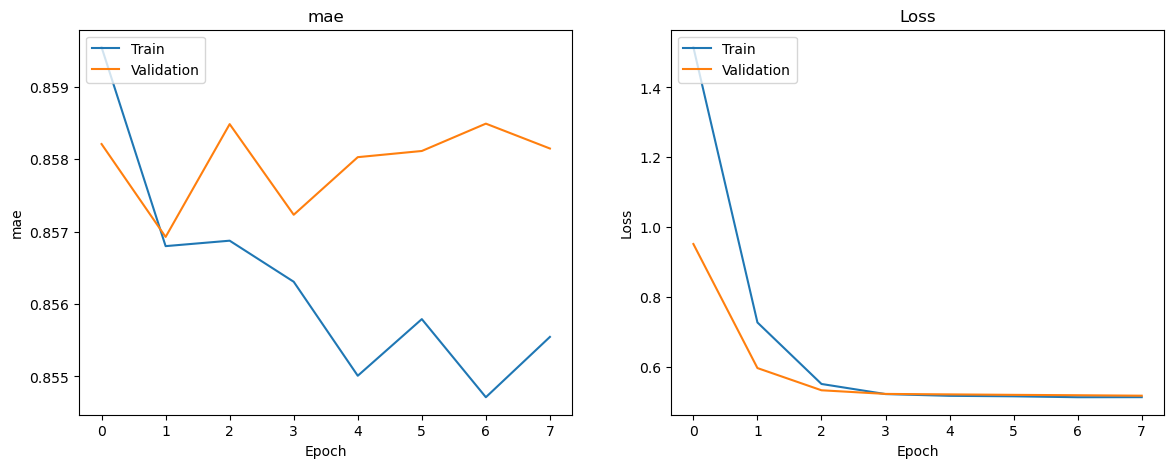

In [191]:
# Plotting the results
loss_acc_graphs(history)

In [192]:
# Make predictions on the validation set
predictions_scaled = best_model.predict(X_val)

# Inverse scale the predictions
predictions_inverse_scaled = target_scaler.inverse_transform(predictions_scaled)

# Inverse the log transform
predictions_original = np.expm1(predictions_inverse_scaled).flatten()

# For the validation set, we need to inverse scale and then inverse log transform as well
y_val_inverse_scaled = target_scaler.inverse_transform(y_val.reshape(-1, 1))
y_val_original_values = np.expm1(y_val_inverse_scaled).flatten()

# Evaluate the error using MAE on the original scale
mae_original = mean_absolute_error(y_val_original_values, predictions_original)
print(f"Original Mean Absolute Error: {mae_original}")

# Compare the first few predictions to the actual values
for pred, actual in zip(predictions_original[:50], y_val_original_values[:50]):
    print(f"Predicted: {pred}, Actual: {actual}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Original Mean Absolute Error: 19.410608897028144
Predicted: 11.726841926574707, Actual: 9.000000000000002
Predicted: 11.730435371398926, Actual: 2.0000000000000004
Predicted: 11.830562591552734, Actual: 10.000000000000002
Predicted: 11.739392280578613, Actual: 3.999999999999999
Predicted: 11.644865036010742, Actual: 56.00000000000001
Predicted: 11.655719757080078, Actual: 1.0
Predicted: 11.643795013427734, Actual: 83.40000000000053
Predicted: 11.645770072937012, Actual: 1.0
Predicted: 11.6569242477417, Actual: 3.0
Predicted: 11.557217597961426, Actual: 5.0
Predicted: 11.564249038696289, Actual: 10.000000000000002
Predicted: 11.609975814819336, Actual: 16.0
Predicted: 11.865437507629395, Actual: 16.0
Predicted: 11.555508613586426, Actual: 5.999999999999999
Predicted: 11.555532455444336, Actual: 3.0
Predicted: 11.555612564086914, Actual: 1.0
Predicted: 11.556221008300781, Actual: 6.999999999999998
Predicted: 11.560567855834961, Actual: 1.0
Predict

## Feature Importance

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MAE change for countries (categorical): -1.7618026411980736e-05
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MAE change for PlateName (categorical): 8.40299743387618e-06
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE change for latitude (numeric): 1.8614756918111652e-06
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE change for longitude (numeric): 2.0761530109325577e-05
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MAE change for depth (numeric): -3.1177303458918004e-05
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE change for mag (numeric): -1.779990860484304e-06
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE change for year (numeric): 3.378662882269623e-05
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE change for month (numeric): -1.3628891245787145e-05
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE change for day (numeric): -5.384034729161158e-07
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MAE change for day_of_week (numeric): 3.367637280149438e-06
149/149 ━━━━━━━━━

C:\Users\Harrys\AppData\Local\Temp\ipykernel_16428\3408229802.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mae_differences.keys(), rotation=45, ha="right")


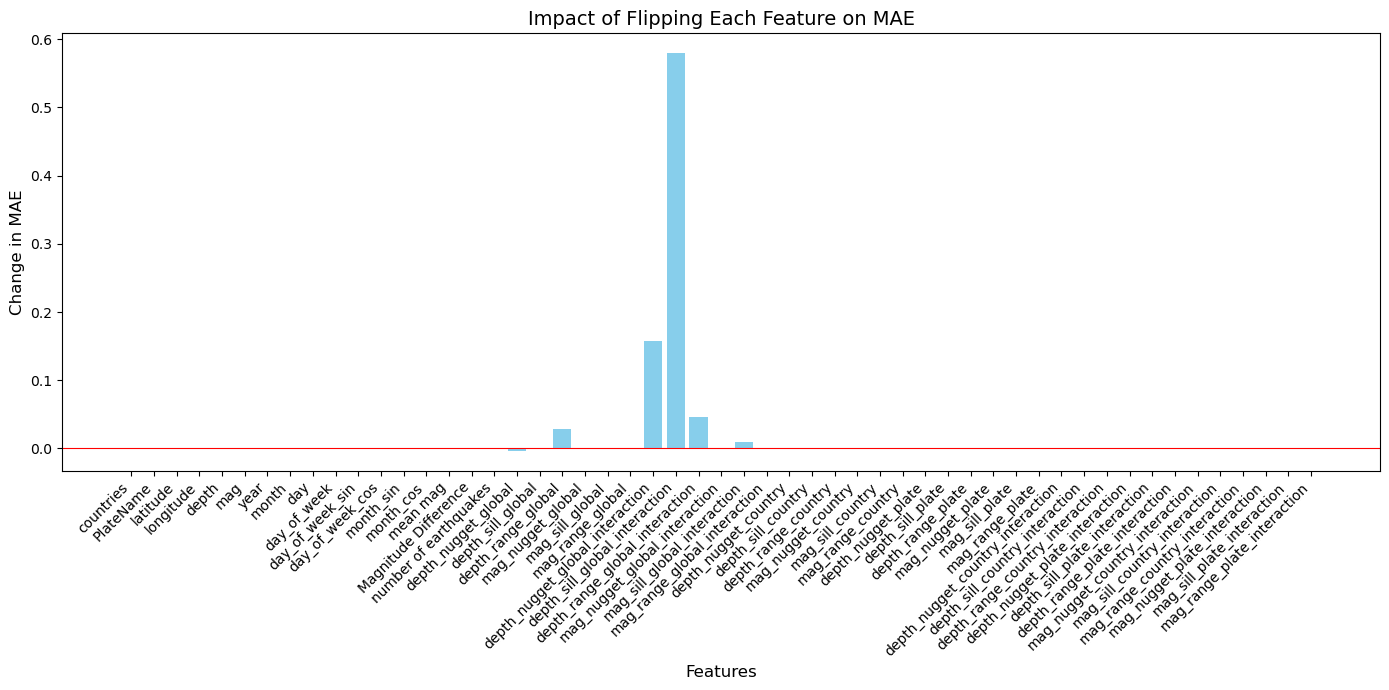

In [193]:
import numpy as np
import matplotlib.pyplot as plt


#'countries_freq', 'PlateName_freq'
#feature_columns = ['latitude', 'longitude', 'depth', 'mag', 'year', 'month', 'day', 'day_of_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag', 'Magnitude Difference', 'number of earthquakes', 'counter','countries_freq', 'PlateName_freq']

# Define and map categorical features based on their encoded prefixes
categorical_features = {
    'countries': [index for index, name in enumerate(feature_columns) if 'countries_' in name],
    'PlateName': [index for index, name in enumerate(feature_columns) if 'PlateName_' in name]
}

# Include numeric features
numeric_features = ['latitude', 'longitude', 'depth', 'mag', 
       'year', 'month', 'day', 'day_of_week', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'mean mag',
       'Magnitude Difference', 'number of earthquakes', 
       'depth_nugget_global', 'depth_sill_global', 'depth_range_global',
       'mag_nugget_global', 'mag_sill_global', 'mag_range_global',
       'depth_nugget_global_interaction', 'depth_sill_global_interaction',
       'depth_range_global_interaction', 'mag_nugget_global_interaction',
       'mag_sill_global_interaction', 'mag_range_global_interaction',
       'depth_nugget_country', 'depth_sill_country', 'depth_range_country',
       'mag_nugget_country', 'mag_sill_country', 'mag_range_country',
       'depth_nugget_plate', 'depth_sill_plate', 'depth_range_plate',
       'mag_nugget_plate', 'mag_sill_plate', 'mag_range_plate',
       'depth_nugget_country_interaction', 'depth_sill_country_interaction',
       'depth_range_country_interaction', 'depth_nugget_plate_interaction',
       'depth_sill_plate_interaction', 'depth_range_plate_interaction',
       'mag_nugget_country_interaction', 'mag_sill_country_interaction',
       'mag_range_country_interaction', 'mag_nugget_plate_interaction',
       'mag_sill_plate_interaction', 'mag_range_plate_interaction']

def flip_features_and_evaluate(model, X, feature_indices):
    """
    Flip features by setting all specified indices in the sequences to zero and evaluate the model.
    
    Parameters:
        model: Trained model to use for predictions.
        X: Original validation data sequences.
        feature_indices: List of indices of the features to flip to zero.
        
    Returns:
        Modified MAE after flipping the features.
    """
    X_flipped = np.copy(X)
    # Set all specified feature indices to zero
    X_flipped[:, :, feature_indices] = 0
    # Predict and calculate MAE
    predictions_flipped_scaled = model.predict(X_flipped)
    predictions_flipped_inverse_scaled = target_scaler.inverse_transform(predictions_flipped_scaled)
    predictions_flipped_original = np.expm1(predictions_flipped_inverse_scaled).flatten()
    new_mae = mean_absolute_error(y_val_original_values, predictions_flipped_original)
    return new_mae

# Calculate MAE for each feature when flipped
mae_differences = {}
for feature, indices in categorical_features.items():
    new_mae = flip_features_and_evaluate(best_model, X_val, indices)
    mae_differences[feature] = new_mae - mae_original
    print(f"MAE change for {feature} (categorical): {new_mae - mae_original}")

for feature in numeric_features:
    feature_index = feature_columns.index(feature)
    new_mae = flip_features_and_evaluate(best_model, X_val, [feature_index])
    mae_differences[feature] = new_mae - mae_original
    print(f"MAE change for {feature} (numeric): {new_mae - mae_original}")

# Plot the results with better handling for visibility
fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(mae_differences.keys(), mae_differences.values(), color='skyblue')
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Change in MAE', fontsize=12)
ax.set_title('Impact of Flipping Each Feature on MAE', fontsize=14)
ax.set_xticklabels(mae_differences.keys(), rotation=45, ha="right")
ax.axhline(0, color='red', linewidth=0.8)  # Adds a horizontal line at zero change for reference
plt.tight_layout()
plt.show()


In [194]:
# Example split of features into two categories for clarity
basic_features = ['latitude', 'longitude', 'depth', 'mag', 'year', 'month', 'day',
                  'day_of_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
                  'mean mag', 'Magnitude Difference', 'number of earthquakes']

advanced_features = ['depth_nugget_global', 'depth_sill_global', 'depth_range_global',
                     'mag_nugget_global', 'mag_sill_global', 'mag_range_global',
                     'depth_nugget_global_interaction', 'depth_sill_global_interaction',
                     'depth_range_global_interaction', 'mag_nugget_global_interaction',
                     'mag_sill_global_interaction', 'mag_range_global_interaction',
                     'depth_nugget_country', 'depth_sill_country', 'depth_range_country',
                     'mag_nugget_country', 'mag_sill_country', 'mag_range_country',
                     'depth_nugget_plate', 'depth_sill_plate', 'depth_range_plate',
                     'mag_nugget_plate', 'mag_sill_plate', 'mag_range_plate',
                     'depth_nugget_country_interaction', 'depth_sill_country_interaction',
                     'depth_range_country_interaction', 'depth_nugget_plate_interaction',
                     'depth_sill_plate_interaction', 'depth_range_plate_interaction',
                     'mag_nugget_country_interaction', 'mag_sill_country_interaction',
                     'mag_range_country_interaction', 'mag_nugget_plate_interaction',
                     'mag_sill_plate_interaction', 'mag_range_plate_interaction']

C:\Users\Harrys\AppData\Local\Temp\ipykernel_16428\2020785779.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mae_differences.keys(), rotation=45, ha="right")


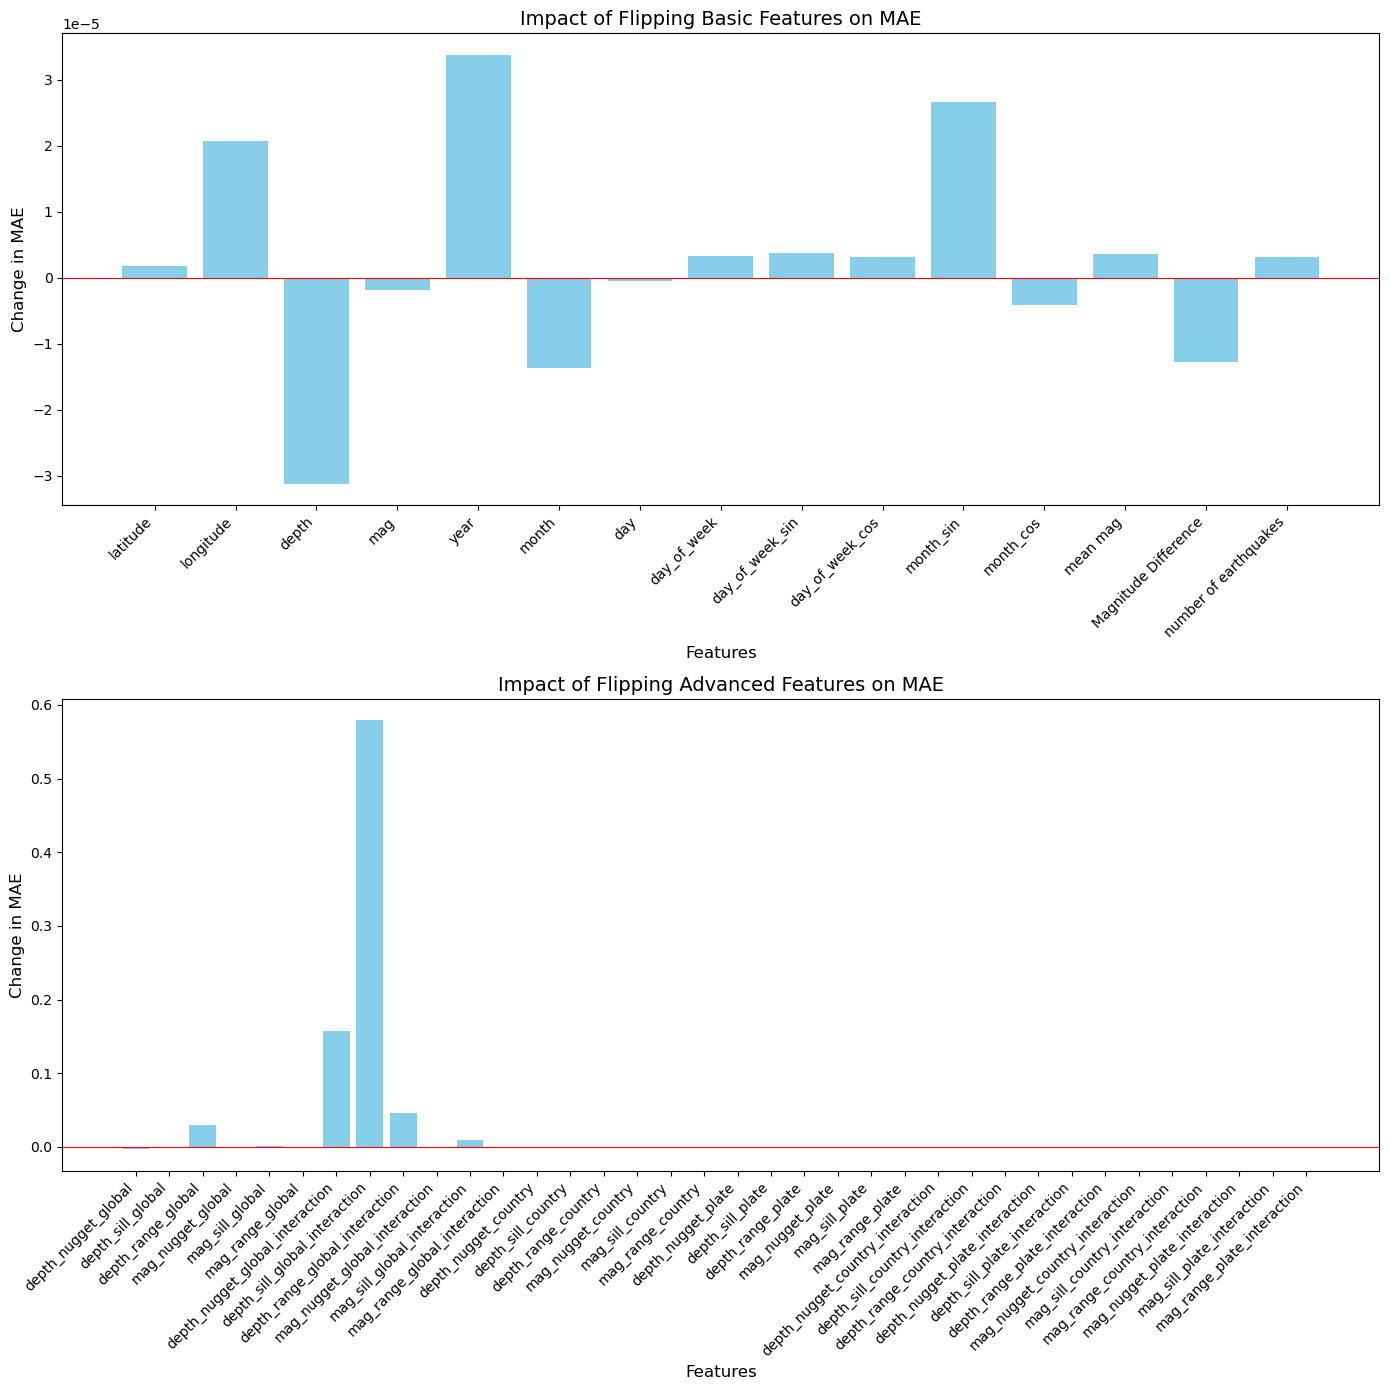

In [195]:
# Split MAE differences into two dictionaries based on these categories
basic_mae_differences = {k: v for k, v in mae_differences.items() if k in basic_features}
advanced_mae_differences = {k: v for k, v in mae_differences.items() if k in advanced_features}

# Plotting function
def plot_mae_differences(mae_differences, title, ax):
    ax.bar(mae_differences.keys(), mae_differences.values(), color='skyblue')
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Change in MAE', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticklabels(mae_differences.keys(), rotation=45, ha="right")
    ax.axhline(0, color='red', linewidth=0.8)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))

# Plot basic features
plot_mae_differences(basic_mae_differences, 'Impact of Flipping Basic Features on MAE', ax1)

# Plot advanced features
plot_mae_differences(advanced_mae_differences, 'Impact of Flipping Advanced Features on MAE', ax2)

plt.tight_layout()
plt.show()

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
149/149 ━━━━━━━━

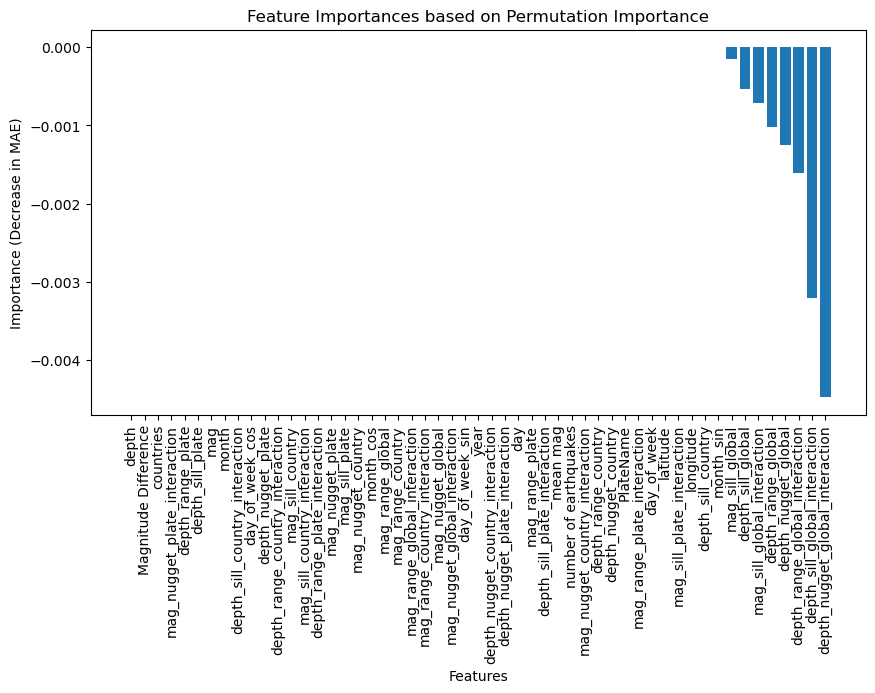

In [196]:
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error

original_score = mean_absolute_error(best_model.predict(X_val), y_val)
feature_importances = {}

# Numeric features indices
numeric_feature_indices = {name: i for i, name in enumerate(feature_columns) if name in numeric_features}

# Shuffle and evaluate each numeric feature
for feature_name, index in numeric_feature_indices.items():
    X_val_permuted = np.copy(X_val)
    X_val_permuted[:, :, index] = shuffle(X_val_permuted[:, :, index])

    permuted_score = mean_absolute_error(best_model.predict(X_val_permuted), y_val)
    feature_importances[feature_name] = original_score - permuted_score

# Shuffle and evaluate each one-hot encoded categorical feature as a block
for feature_name, indices in categorical_features.items():
    X_val_permuted = np.copy(X_val)
    shuffled_indices = shuffle(np.arange(X_val.shape[0]))
    
    for index in indices:
        X_val_permuted[:, :, index] = X_val_permuted[shuffled_indices, :, index]

    permuted_score = mean_absolute_error(best_model.predict(X_val_permuted), y_val)
    feature_importances[feature_name] = original_score - permuted_score

# Sorting features by importance
sorted_features = sorted(feature_importances, key=feature_importances.get, reverse=True)

# Plotting feature importances
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(feature_importances)), [feature_importances[feature] for feature in sorted_features])
plt.xticks(range(len(feature_importances)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance (Decrease in MAE)')
plt.title('Feature Importances based on Permutation Importance')
plt.show()

C:\Users\Harrys\AppData\Local\Temp\ipykernel_16428\3661222757.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_importances.keys(), rotation=90, ha="right")


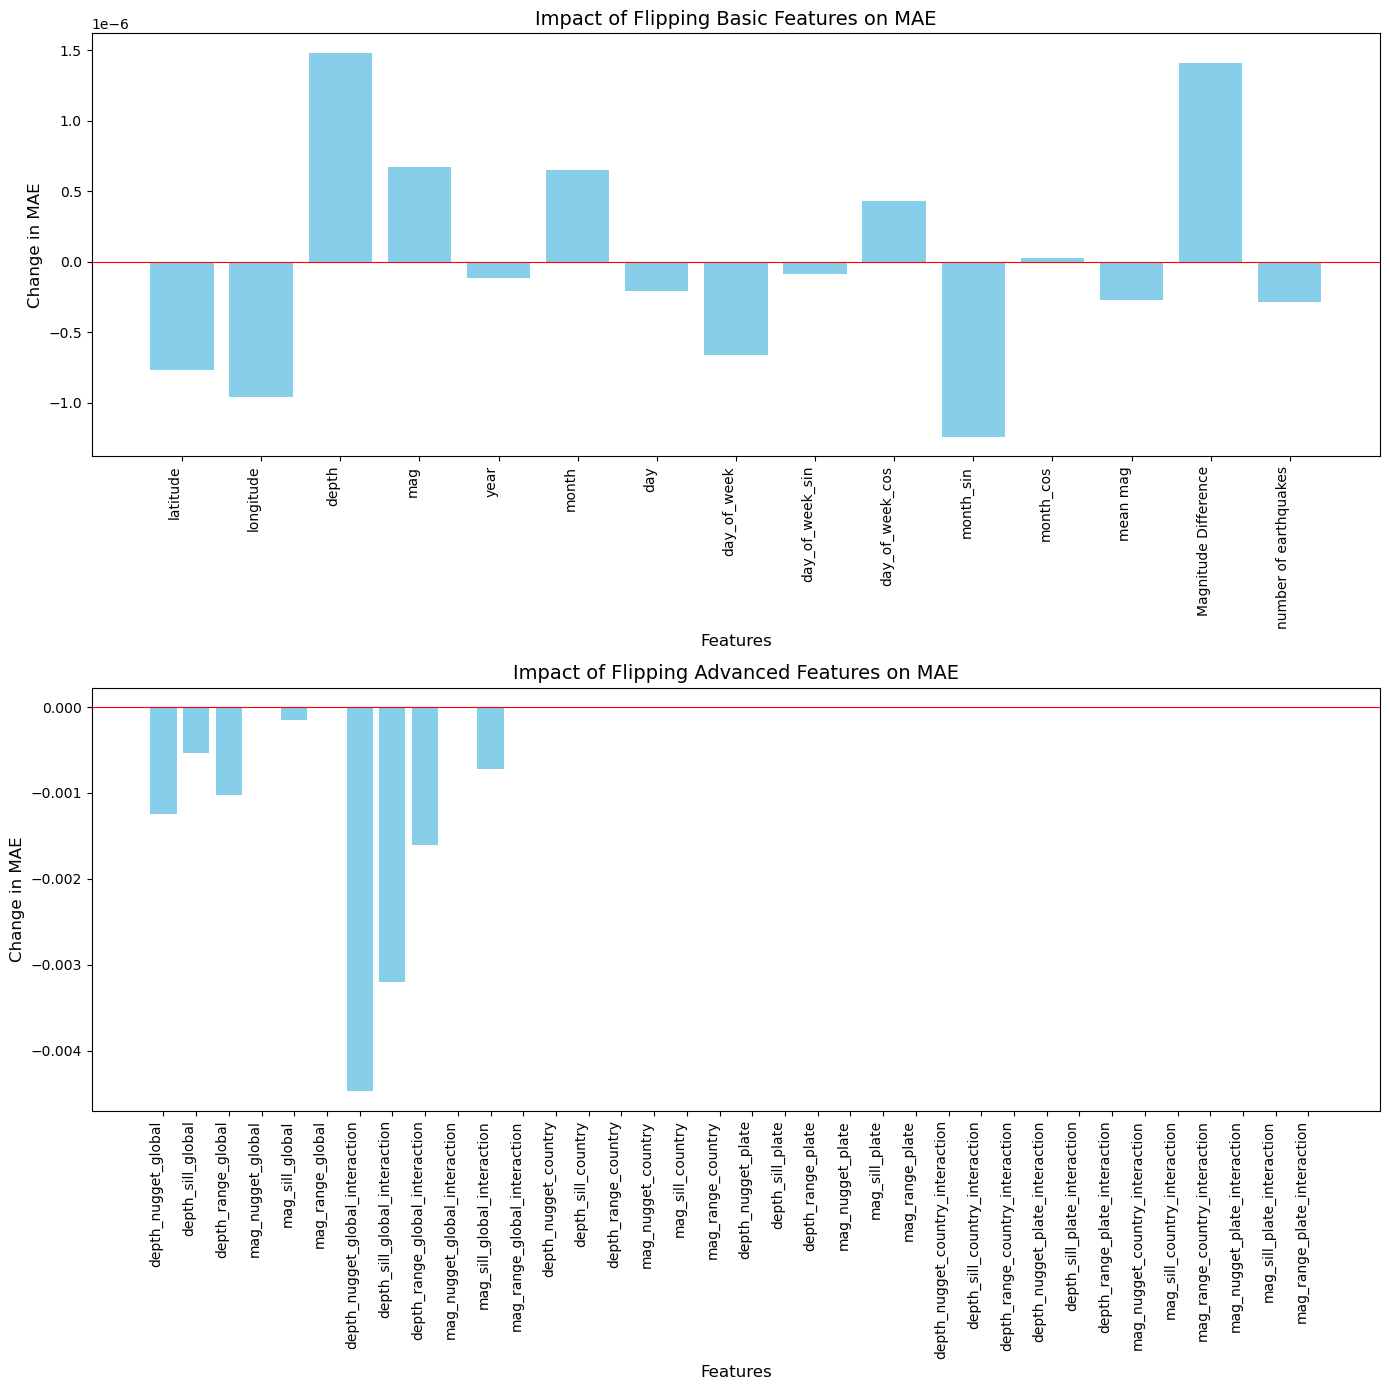

In [197]:
# Split MAE differences into two dictionaries based on these categories
basic_mae_differences_flip = {k: v for k, v in feature_importances.items() if k in basic_features}
advanced_mae_differences_flip = {k: v for k, v in feature_importances.items() if k in advanced_features}

# Plotting function
def plot_mae_differences(feature_importances, title, ax):
    ax.bar(feature_importances.keys(), feature_importances.values(), color='skyblue')
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Change in MAE', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticklabels(feature_importances.keys(), rotation=90, ha="right")
    ax.axhline(0, color='red', linewidth=0.8)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))

# Plot basic features
plot_mae_differences(basic_mae_differences_flip, 'Impact of Flipping Basic Features on MAE', ax1)

# Plot advanced features
plot_mae_differences(advanced_mae_differences_flip, 'Impact of Flipping Advanced Features on MAE', ax2)

plt.tight_layout()
plt.show()

combine feature importance graphs

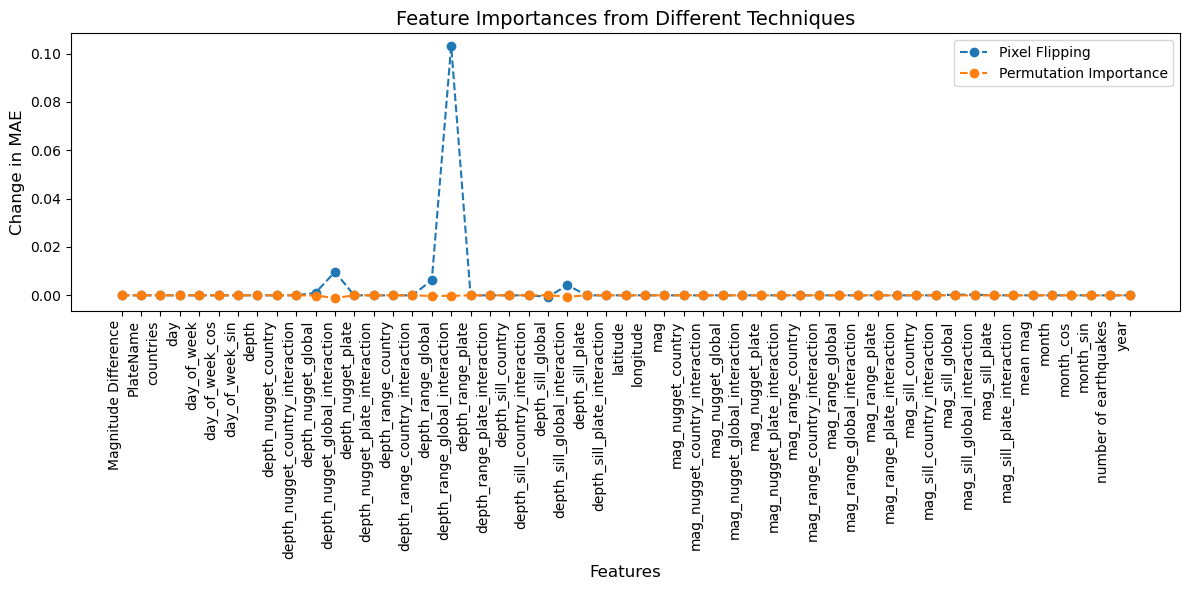

In [ ]:
# convert the dictionaries to sorted lists for plotting
features = sorted(mae_differences.keys())
pixel_flipping_values = [mae_differences[feature] for feature in features]
permutation_importance_values = [feature_importances[feature] for feature in features]

# Plot the simulated feature importances
plt.figure(figsize=(12, 6))

# Plotting both methods on the same graph
plt.plot(features, pixel_flipping_values, marker='o', linestyle='--', label='Pixel Flipping')
plt.plot(features, permutation_importance_values, marker='o', linestyle='--', label='Permutation Importance')

plt.xlabel('Features', fontsize=12)
plt.ylabel('Change in MAE', fontsize=12)
plt.title('Feature Importances from Different Techniques', fontsize=14)
plt.legend()
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()

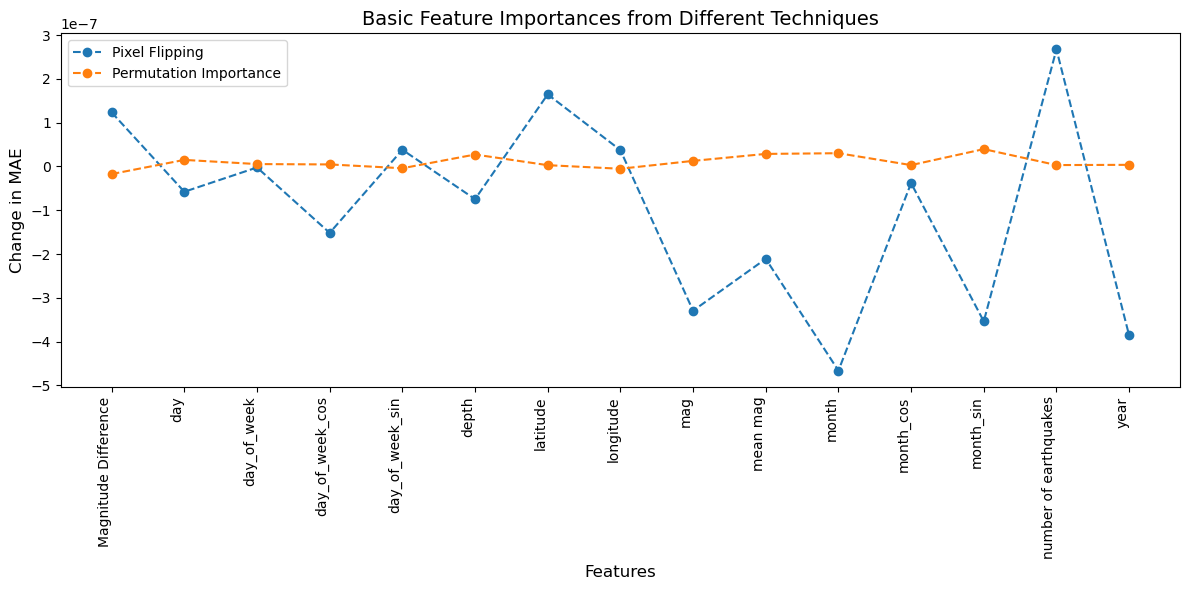

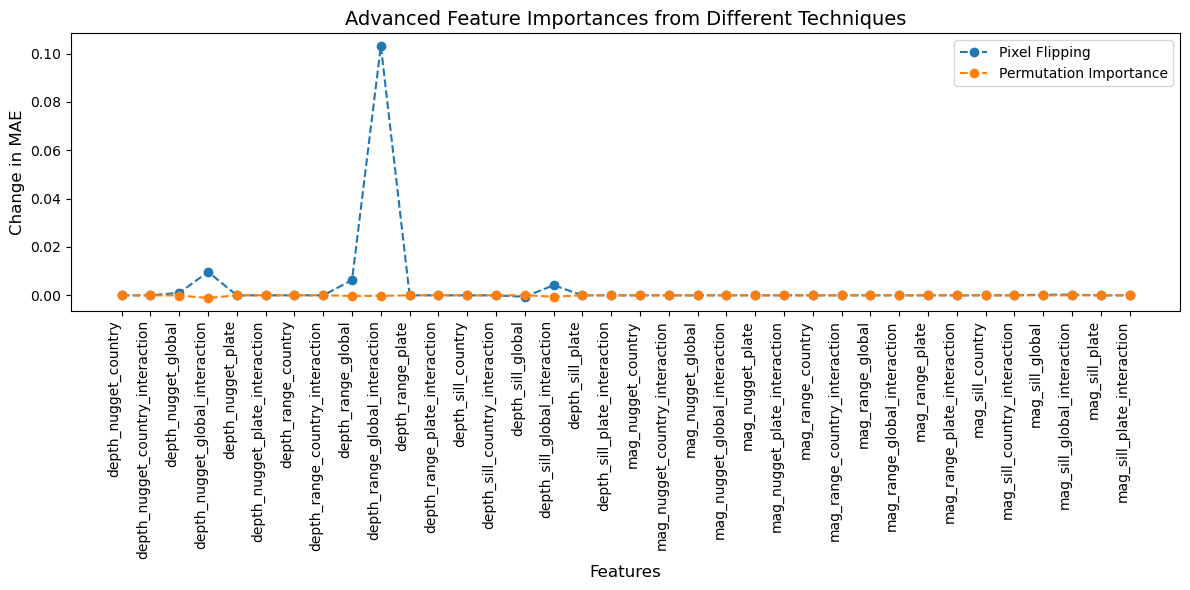

In [ ]:
# Filter dictionaries for basic and advanced features
basic_pixel_flipping = {k: v for k, v in mae_differences.items() if k in basic_features}
basic_permutation_importance = {k: v for k, v in feature_importances.items() if k in basic_features}

advanced_pixel_flipping = {k: v for k, v in mae_differences.items() if k in advanced_features}
advanced_permutation_importance = {k: v for k, v in feature_importances.items() if k in advanced_features}

# Function to plot data
def plot_feature_importances(features, pixel_values, permutation_values, title):
    plt.figure(figsize=(12, 6))
    plt.plot(features, pixel_values, marker='o', linestyle='--', label='Pixel Flipping')
    plt.plot(features, permutation_values, marker='o', linestyle='--', label='Permutation Importance')
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Change in MAE', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend()
    plt.xticks(rotation=90, ha="right")
    plt.tight_layout()
    plt.show()

# Prepare data for plotting
sorted_basic_features = sorted(basic_features)
basic_pixel_values = [basic_pixel_flipping[feature] for feature in sorted_basic_features if feature in basic_pixel_flipping]
basic_permutation_values = [basic_permutation_importance[feature] for feature in sorted_basic_features if feature in basic_permutation_importance]

sorted_advanced_features = sorted(advanced_features)
advanced_pixel_values = [advanced_pixel_flipping[feature] for feature in sorted_advanced_features if feature in advanced_pixel_flipping]
advanced_permutation_values = [advanced_permutation_importance[feature] for feature in sorted_advanced_features if feature in advanced_permutation_importance]

# Plot for basic features
plot_feature_importances(sorted_basic_features, basic_pixel_values, basic_permutation_values, 'Basic Feature Importances from Different Techniques')

# Plot for advanced features
plot_feature_importances(sorted_advanced_features, advanced_pixel_values, advanced_permutation_values, 'Advanced Feature Importances from Different Techniques')

## Error Analysis

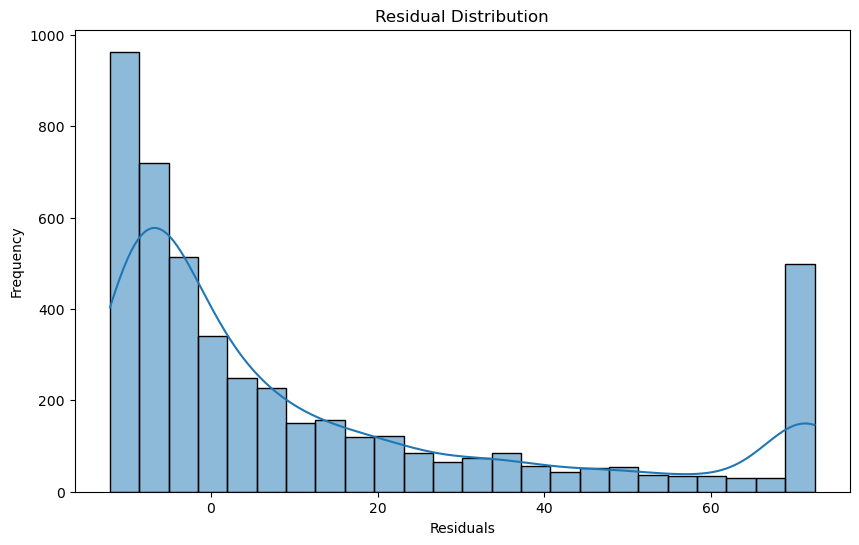

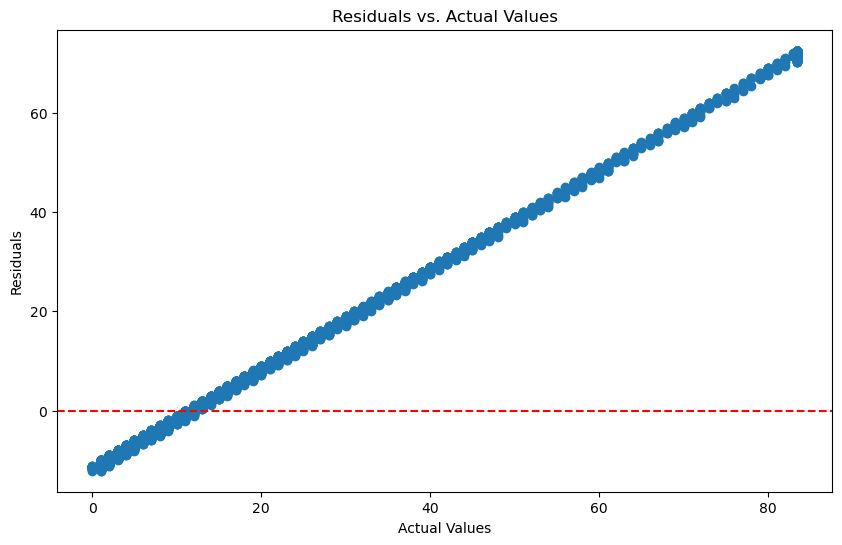

In [ ]:
# Calculate residuals
residuals = y_val_original_values - predictions_original

# Plotting the residuals distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_val_original_values, residuals)
plt.title('Residuals vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at zero for reference
plt.show()